## Set up

In [1]:
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import keras as tfk
import tensorflow as tf
from sklearn.model_selection import train_test_split

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-12 23:10:56.373593: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 23:10:56.373842: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 23:10:56.377023: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 23:10:56.410040: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to u

In [2]:
VALIDATION_SPLIT = 0.2
SEED = 42
RNG = np.random.default_rng(SEED)

In [3]:
RESULTS_DIR = Path().absolute().parent / "results"
BIG_ROCK_EXPERIMENT = "119"
GENERIC_EXPERIMENT = "o25"

BIG_ROCK_DIR = RESULTS_DIR / BIG_ROCK_EXPERIMENT
GENERIC_DIR = RESULTS_DIR / GENERIC_EXPERIMENT

print(BIG_ROCK_DIR)
print(GENERIC_DIR)

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-2/results/119
/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/homework-2/results/o25


In [4]:
CLASS_MAP = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}

In [5]:
def mean_iou(y_true, y_pred):
    metric = tfk.metrics.MeanIoU(num_classes=5, ignore_class=0, sparse_y_pred=True, sparse_y_true=True)
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

### Load data

In [6]:
DATA_ROOT = Path("/kaggle/input/an2dl-hw2-clean")
if not DATA_ROOT.exists():
    DATA_ROOT = Path().absolute().parent / "data" / "clean"

with np.load(DATA_ROOT / "train.npz") as data:
    original_x_train = data["x"]
    original_y_train = data["y"]
with np.load(DATA_ROOT / "test.npz") as data:
    original_x_test = data["x"]

original_x_train = original_x_train[..., np.newaxis] / 255.0
original_y_train = original_y_train[..., np.newaxis]
original_x_test = original_x_test[..., np.newaxis] / 255.0

X_train = original_x_train
y_train = original_y_train
X_test = original_x_test

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128, 1)
Training y shape: (2505, 64, 128, 1)
Test X shape: (10022, 64, 128, 1)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALIDATION_SPLIT, random_state=SEED
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2004, 64, 128, 1) (2004, 64, 128, 1)
(501, 64, 128, 1) (501, 64, 128, 1)


### Load models

#### Big Rock

Loss function needs to be included as a custom object for Keras to properly load the model.

In [8]:
from scipy.ndimage import distance_transform_edt as distance


def dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor, weights: list[float]) -> tf.Tensor:
    dice_loss_per_image = tf.constant(0.0, shape=y_true.shape[0])
    for class_, weight in enumerate(weights):
        y_true_class = y_true[:, :, :, class_]
        y_pred_class = y_pred[:, :, :, class_]
        numerator = 2 * tf.reduce_sum(y_true_class * y_pred_class, axis=(1, 2))
        denominator = tf.reduce_sum(y_true_class + y_pred_class, axis=(1, 2))
        dice_loss_per_image += weight * (
            1 - numerator / (denominator + tfk.backend.epsilon())
        )
    # Return the mean Dice loss across the batch
    return tf.cast(tf.reduce_mean(dice_loss_per_image), tf.float32)


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true) -> np.ndarray:
    y_true_numpy = y_true.numpy()
    return (
        np.array([calc_dist_map(y) for y in y_true_numpy])
        .reshape(y_true.shape)
        .astype(np.float32)
    )


def boundary_loss(y_true, y_pred):
    y_true_dist_map = tf.py_function(
        func=calc_dist_map_batch, inp=[y_true], Tout=tf.float32
    )
    multiplied = y_pred * y_true_dist_map
    return tf.reduce_mean(multiplied)


def big_rock_loss(
    weights: list[float],
    dice_weight: float,
    focal_weight: float,
    categorical_crossentropy_weight: float,
    boundary_weight: float,
    alpha: float | list[float],
    gamma: float,
):
    def loss(y_true, y_pred):
        # One-hot encode class labels since they are dense
        # but predictions are sparse
        y_true = tf.squeeze(y_true, axis=-1)
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(weights))

        categorical_crossentropy_value = tfk.losses.categorical_crossentropy(
            y_true,
            y_pred,
        )
        dice_loss_value = dice_loss(y_true, y_pred, weights)
        focal_loss_value = tf.cast(
            tfk.losses.categorical_focal_crossentropy(
                y_true,
                y_pred,
                alpha=alpha,
                gamma=gamma,
            ),
            tf.float32,
        )

        boundary_loss_value = 0.0
        if boundary_weight > 0.0:
            boundary_loss_value = boundary_loss(y_true, y_pred)

        return (
            dice_weight * dice_loss_value
            + focal_weight * focal_loss_value
            + categorical_crossentropy_weight * categorical_crossentropy_value
            + boundary_weight * boundary_loss_value
        )

    return loss

In [9]:
big_rock_model: tfk.Model = tfk.saving.load_model(
    BIG_ROCK_DIR / "model.keras",
    custom_objects={"loss": big_rock_loss},
)
big_rock_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 64, 128,   │          0 │ input_layer_1[0]… │
│ (GaussianNoise)     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 128,   │        640 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_25[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 128,   │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 128,   │        128 │ conv2d_26[0][0]   │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 64, 128,   │          0 │ layer_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 64, 128,   │        128 │ gaussian_noise_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 64, 128,   │          0 │ activation_15[0]… │
│                     │ 64)               │            │ conv2d_27[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 64,    │          0 │ add_10[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_28[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 64,    │          0 │ layer_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 64,    │    147,584 │ activation_16[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 32, 64,    │        256 │ conv2d_29[0][0]   │
│ (LayerNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 64,    │          0 │ layer_normalizat

 Total params: 22,079,240 (84.23 MB)

 Trainable params: 7,359,746 (28.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,719,494 (56.15 MB)

#### Combined

In [10]:
combined_model: tfk.Model = tfk.saving.load_model(GENERIC_DIR / "model.h5")
combined_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ conv2d_1[0][0],   │
│                     │ 64)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │    147,584 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ conv2d_4[0][0],   │
│                     │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ add_1[0][0]       │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 32,    │     33,024 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 16, 32,    │          0 │ conv2d_7[0][0],   │
│                     │ 256)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 16,     │  1,180,160 │ max_pooling2d_2[

 Total params: 8,041,926 (30.68 MB)

 Trainable params: 8,041,924 (30.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

## Compute predictions

In [11]:
combined_val_predictions: np.ndarray = combined_model.predict(X_val)
big_rock_val_predictions: np.ndarray = big_rock_model.predict(X_val)

print(combined_val_predictions.shape, big_rock_val_predictions.shape)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 482ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step
(501, 64, 128, 4) (501, 64, 128, 2)


In [12]:
combined_val_argmax: np.ndarray = np.argmax(combined_val_predictions, axis=-1)
print(combined_val_argmax.shape)
print(np.unique(combined_val_argmax, return_counts=True))

(501, 64, 128)
(array([0, 1, 2, 3]), array([ 909220, 1543204,  824437,  827331]))


We need to convert back from (0, 1) labels used to train Big Rock model to actual labels (0 for background and 4 for big rock).

In [13]:
big_rock_val_argmax: np.ndarray = np.argmax(big_rock_val_predictions, axis=-1)
big_rock_val_argmax = np.where(big_rock_val_argmax == 1, 4, big_rock_val_argmax)
print(big_rock_val_argmax.shape)
print(np.unique(big_rock_val_argmax, return_counts=True))

(501, 64, 128)
(array([0, 4]), array([3985752,  118440]))


## Analyse individual predictions

In [14]:
def plot_predictions(x, y, combined, big_rock, n=10):
    _, axes = plt.subplots(nrows=n, ncols=4, figsize=(10, 2 * n))
    for ax in axes.flat:
        ax.set_axis_off()
    for image, mask, combined_mask, big_rock_mask, ax in zip(
        x, y, combined, big_rock, axes
    ):
        ax[0].set_title("Image")
        ax[0].imshow(image, cmap="gray")
        ax[1].set_title("Mask")
        ax[1].imshow(mask, cmap="viridis", vmin=0, vmax=4)
        ax[2].set_title("Combined Mask")
        ax[2].imshow(combined_mask, cmap="viridis", vmin=0, vmax=4)
        ax[3].set_title("Big Rock Mask")
        ax[3].imshow(big_rock_mask, cmap="viridis", vmin=0, vmax=4)

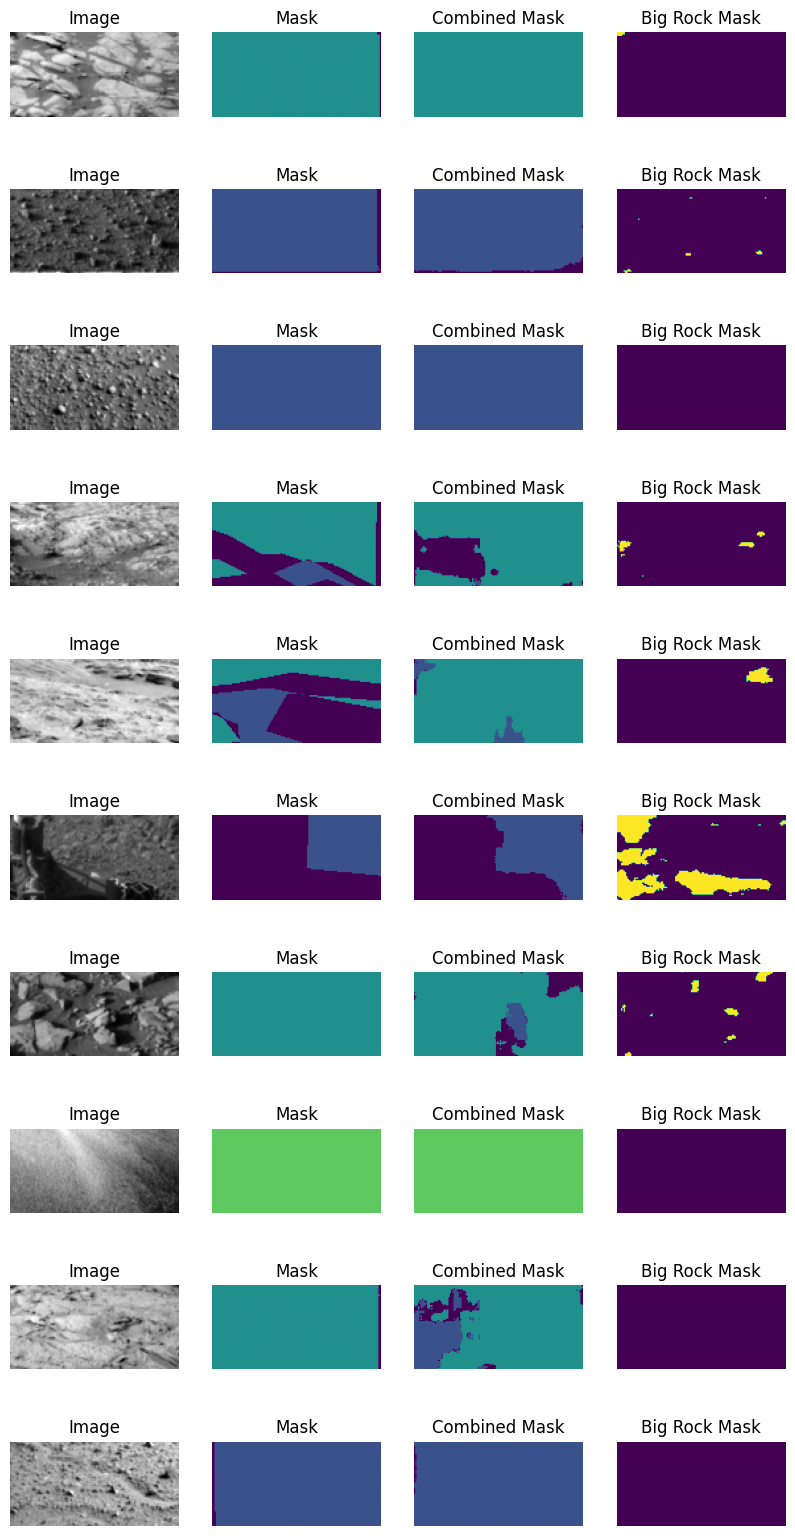

In [15]:
plot_predictions(X_val, y_val, combined_val_argmax, big_rock_val_argmax)

In [16]:
big_rock_mask: np.ndarray = (y_val == 4).any(axis=(1, 2)).ravel()
big_rock_mask.mean()

0.013972055888223553

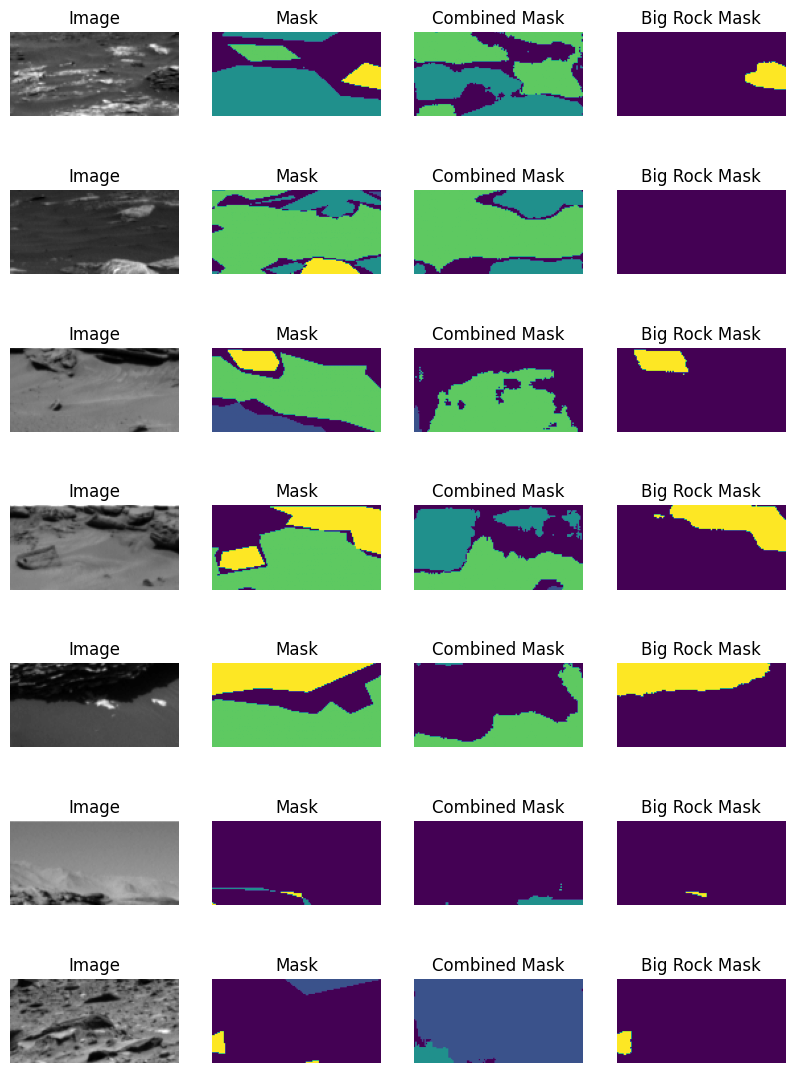

In [17]:
plot_predictions(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    combined_val_argmax[big_rock_mask],
    big_rock_val_argmax[big_rock_mask],
    n=big_rock_mask.sum(),
)

### Probabilities

In [18]:
big_rock_probas = big_rock_val_predictions[:, :, :, 1]
big_rock_probas = big_rock_probas[..., np.newaxis]
big_rock_probas.shape

(501, 64, 128, 1)

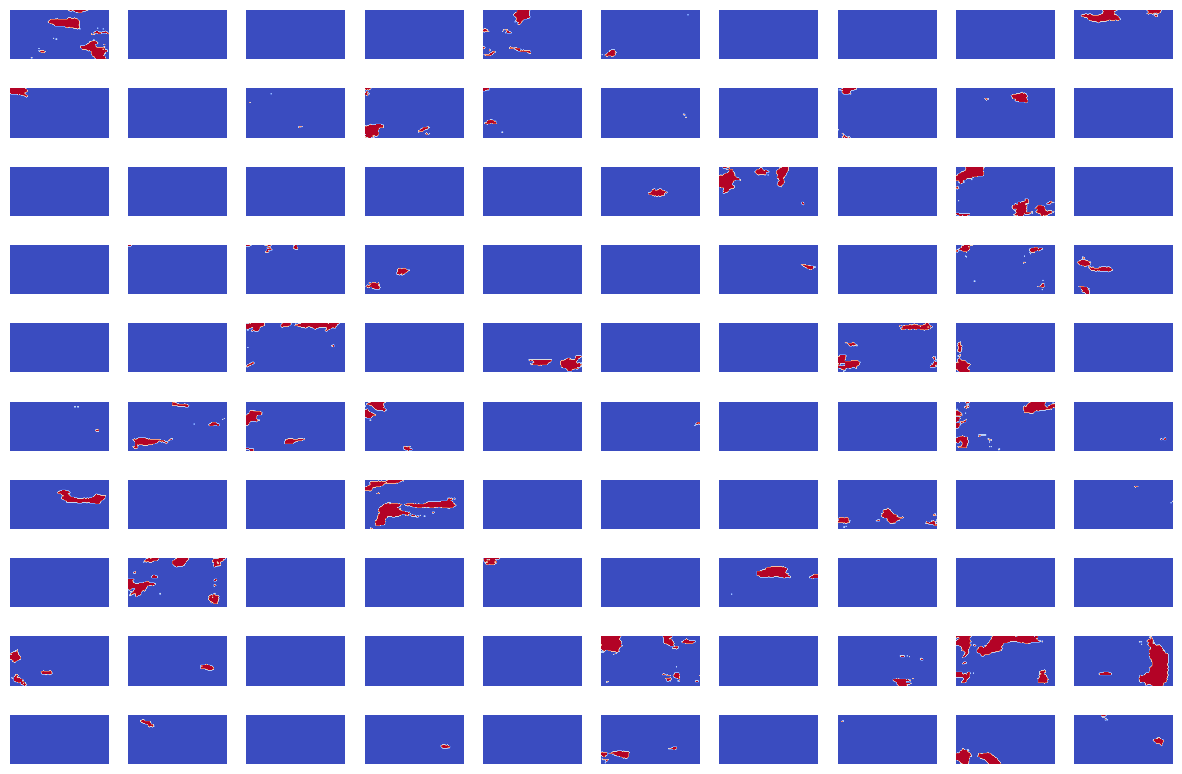

In [19]:
THRESHOLD = 0.99

_, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 10))
for big_rock_proba, ax in zip(RNG.permutation(big_rock_probas), axes.flat):
    ax.set_axis_off()
    ax.imshow(np.where(big_rock_proba > THRESHOLD, big_rock_proba, 0), cmap="coolwarm")

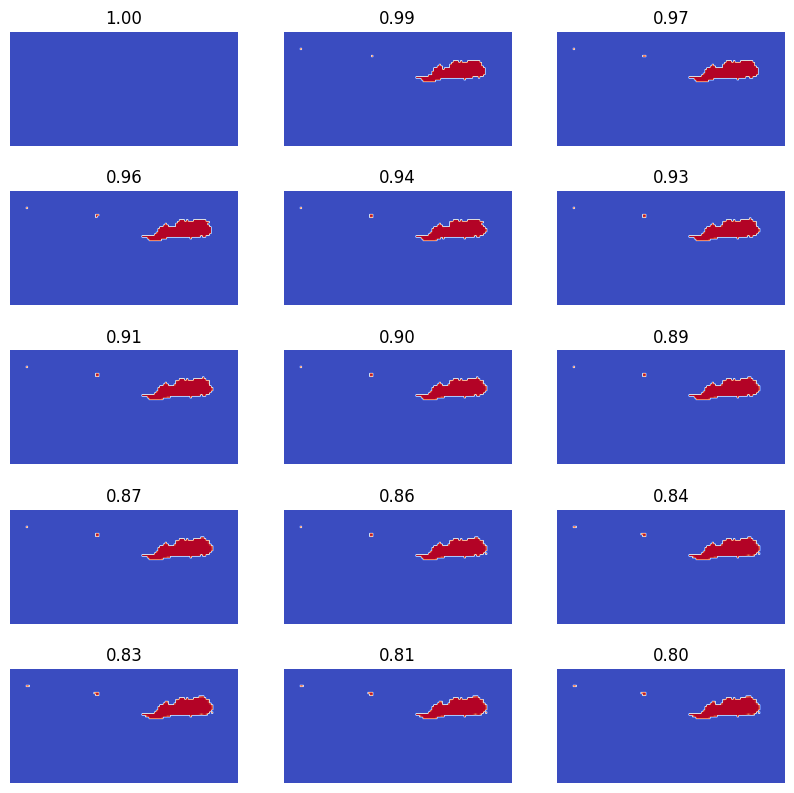

In [20]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 10))
big_rock_proba_sample = RNG.choice(big_rock_probas)
for threshold, ax in zip(np.linspace(1, 0.8, axes.size), axes.flat):
    ax.set_axis_off()
    ax.set_title(f"{threshold:.2f}")
    ax.imshow(np.where(big_rock_proba_sample > threshold, big_rock_proba_sample, 0), cmap="coolwarm")

In [21]:
def plot_probabilities(x, y, combined, big_rock, n=10, combined_threshold=0.99, big_rock_threshold=0.99):
    _, axes = plt.subplots(nrows=n, ncols=7, figsize=(20, 2 * n))
    for ax in axes.flat:
        ax.set_axis_off()

    combined = np.where(combined > combined_threshold, combined, 0.0)
    big_rock = np.where(big_rock > big_rock_threshold, big_rock, 0.0)

    for image, mask, combined_mask, big_rock_mask, row_axes in zip(
        x, y, combined, big_rock, axes
    ):
        for i, ax in enumerate(row_axes[:4]):
            ax.set_title(CLASS_MAP[i])
            ax.imshow(combined_mask[:, :, i], cmap="coolwarm")
        row_axes[4].set_title(CLASS_MAP[4])
        row_axes[4].imshow(big_rock_mask, cmap="coolwarm")
        row_axes[5].set_title("Mask")
        row_axes[5].imshow(mask, cmap="viridis", vmin=0, vmax=4)
        row_axes[6].set_title("Image")
        row_axes[6].imshow(image, cmap="gray")

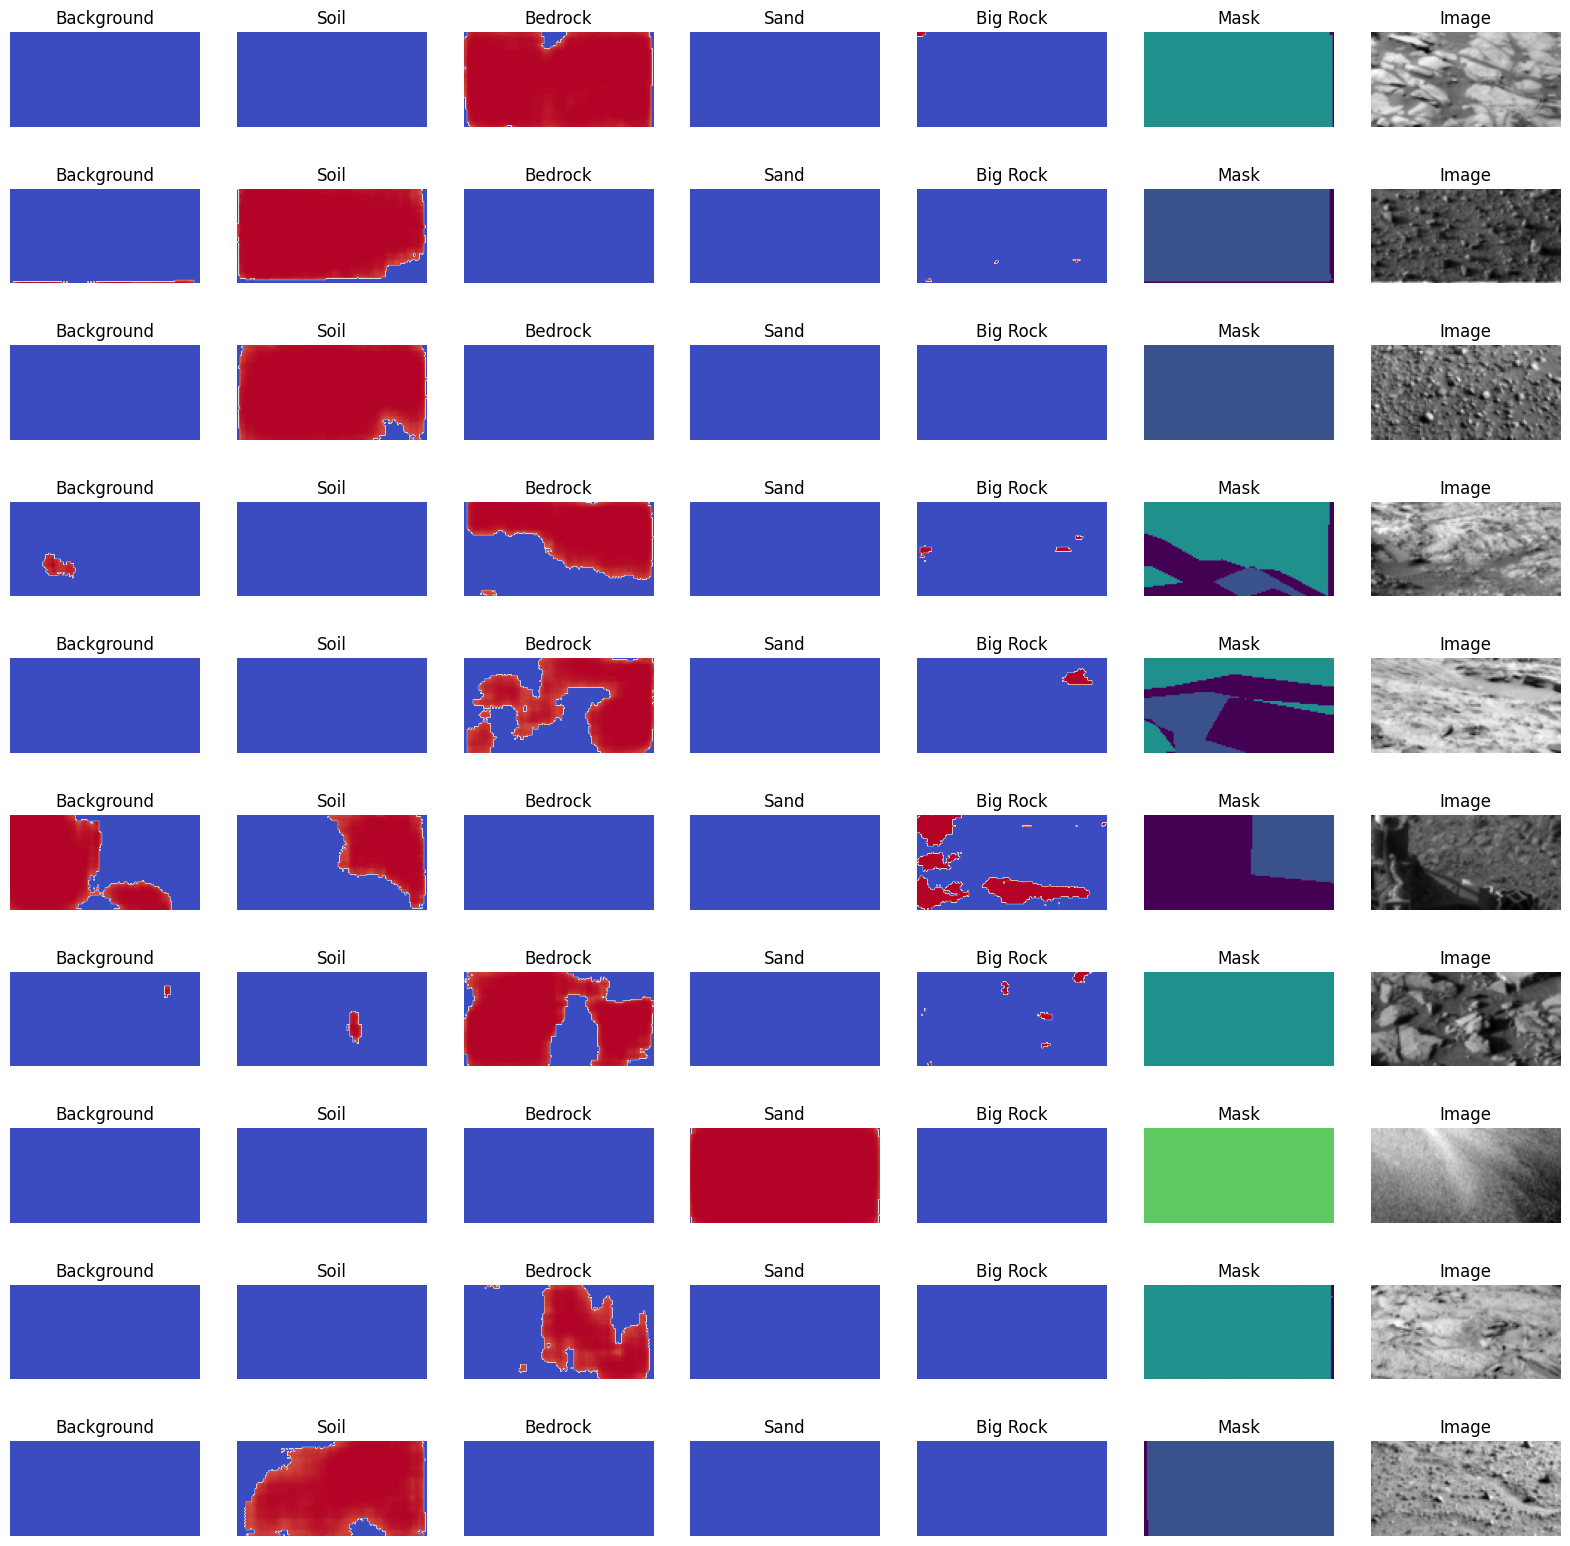

In [22]:
plot_probabilities(
    X_val,
    y_val,
    combined_val_predictions,
    big_rock_probas,
    combined_threshold=0.90,
    big_rock_threshold=0.95,
)

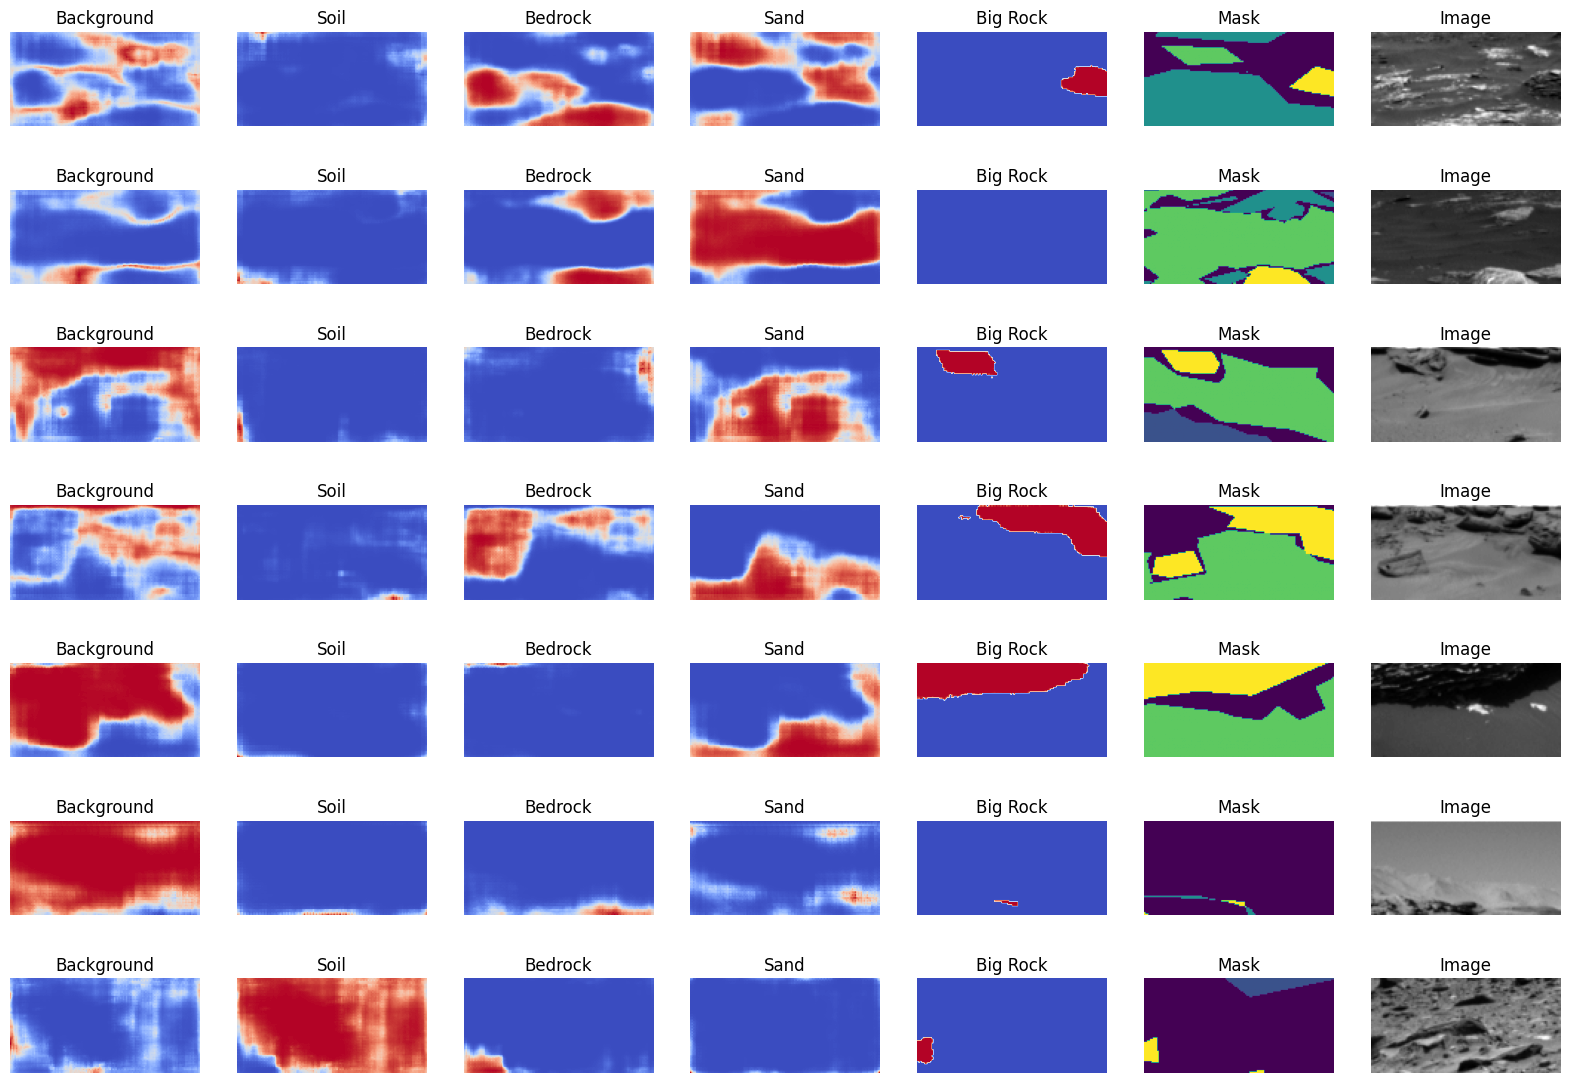

In [23]:
plot_probabilities(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    combined_val_predictions[big_rock_mask],
    big_rock_probas[big_rock_mask],
    n=big_rock_mask.sum(),
    combined_threshold=0.00,
    big_rock_threshold=0.75,
)

## Aggregate predictions

In [24]:
baseline = mean_iou(y_val, combined_val_argmax)
baseline

0.46799555

In [25]:
def evaluate_aggregation(agg_fn, mask, combined, big_rock) -> np.ndarray:
    final = agg_fn(combined, big_rock)
    plot_predictions(X_val, y_val, final, np.zeros_like(final))
    aggregated_mean_iou = mean_iou(mask, final)
    print(f"Aggregated mean IoU {aggregated_mean_iou} ", end="")
    if aggregated_mean_iou <= baseline:
        print("is lower than baseline")
    else:
        print("is higher than baseline")
    return final

### Always replace with big rock

Aggregated mean IoU 0.48058563470840454 is higher than baseline


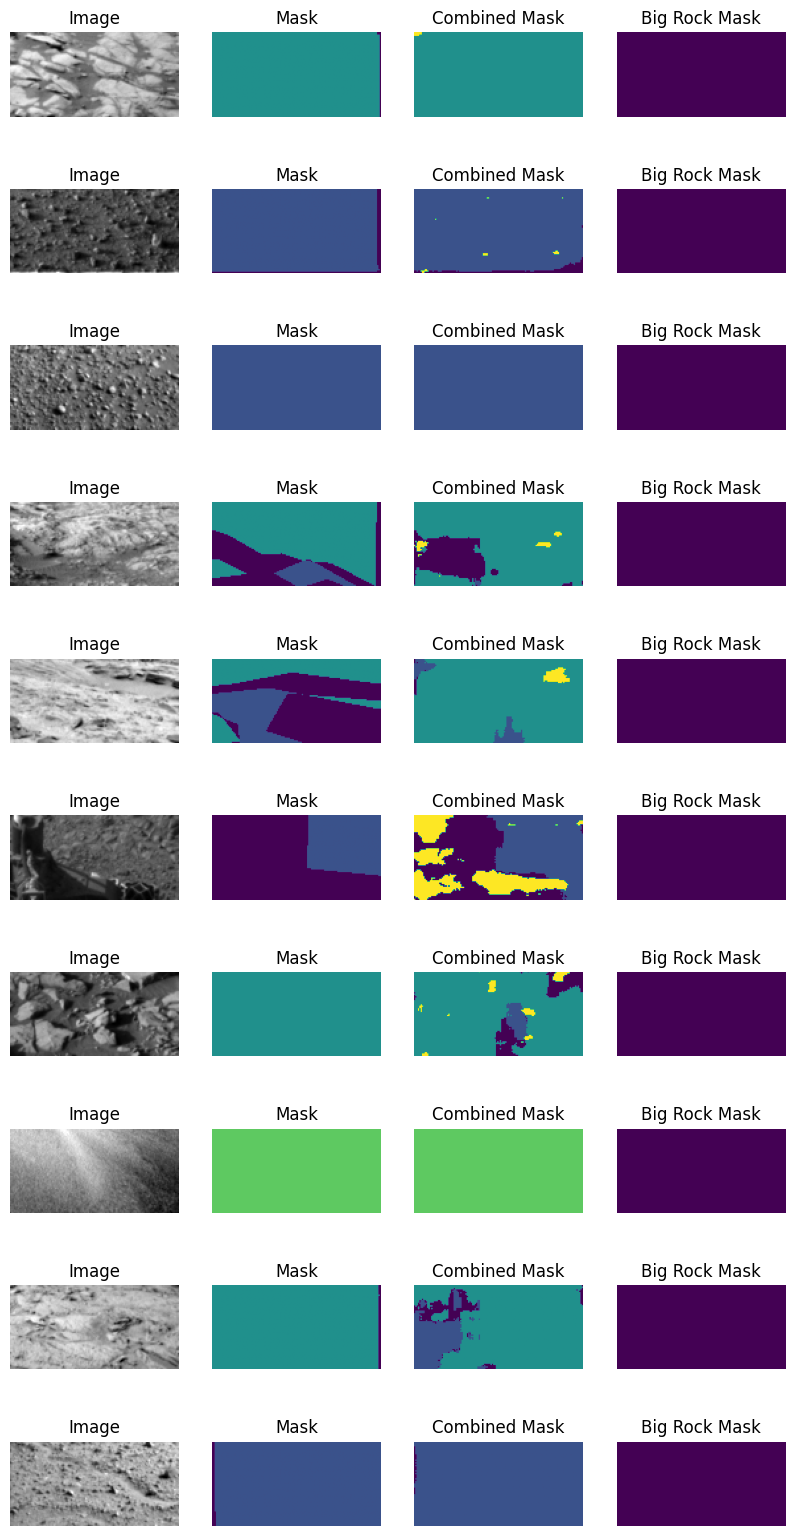

In [27]:
_ = evaluate_aggregation(
    lambda combined, big_rock: np.where(big_rock == 4, big_rock, combined),
    y_val,
    combined_val_argmax,
    big_rock_val_argmax,
)

### Always replace background with big rock

Aggregated mean IoU 0.5070605874061584 is higher than baseline


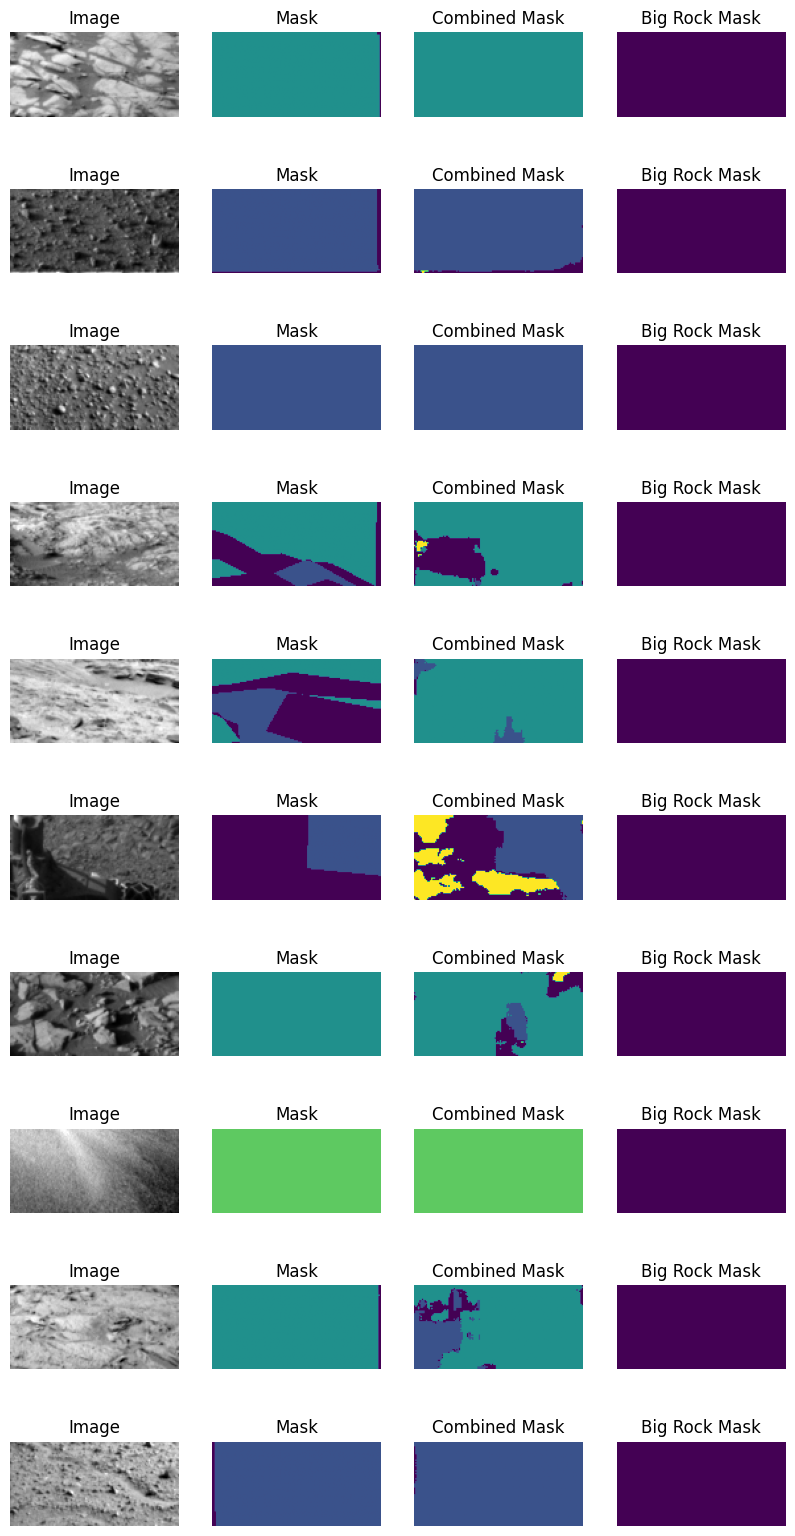

In [43]:
def replace_background(combined, big_rock) -> np.ndarray:
    return np.where(combined == 0, big_rock, combined)


_ = evaluate_aggregation(
    replace_background,
    y_val,
    combined_val_argmax,
    big_rock_val_argmax,
)

### Replace given threshold

In [29]:
def weighted_threshold_merge(
    combined,
    big_rock,
    always_replace_background=False,
    combined_threshold=0.99,
    big_rock_threshold=0.99,
    big_rock_weight=0.5,
) -> np.ndarray:
    optimisation_combined_prediction = combined[:, :, :, :4]
    optimisation_combined_prediction = np.where(
        optimisation_combined_prediction > combined_threshold,
        optimisation_combined_prediction,
        0.0,
    )

    optimisation_big_rock_prediction = np.where(
        big_rock > big_rock_threshold,
        big_rock,
        0.0,
    )

    optimisation_prediction = np.concatenate(
        [
            (1 - big_rock_weight) * optimisation_combined_prediction,
            big_rock_weight * optimisation_big_rock_prediction,
        ],
        axis=-1,
    )
    optimisation_prediction = np.argmax(optimisation_prediction, axis=-1)
    if always_replace_background:
        optimisation_prediction = np.where(
            np.logical_and(optimisation_prediction == 0, (optimisation_big_rock_prediction > 0.5).squeeze()),
            4,
            optimisation_prediction,
        )

    return optimisation_prediction


In [30]:
def optimize(trial: optuna.Trial) -> float:
    always_replace_background = trial.suggest_categorical("always_replace_background", [True, False])
    big_rock_weight = trial.suggest_float("big_rock_weight", 0.1, 0.8)
    big_rock_threshold = trial.suggest_float("big_rock_threshold", 0.5, 0.99)
    combined_threshold = trial.suggest_float("combined_threshold", 0.0, 1.0)

    number_samples = combined_val_predictions.shape[0]

    mean_iou_list = []
    for _ in range(10):
        i = RNG.choice(number_samples, number_samples, replace=True)
        fold_predictions = weighted_threshold_merge(
            combined_val_predictions[i],
            big_rock_probas[i],
            always_replace_background=always_replace_background,
            combined_threshold=combined_threshold,
            big_rock_threshold=big_rock_threshold,
            big_rock_weight=big_rock_weight,
        )

        # Calculate the accuracy score
        mean_iou_list.append(mean_iou(y_val[i], fold_predictions))

    return np.mean(mean_iou_list)

sampler = optuna.samplers.TPESampler(
    n_startup_trials=50,
    multivariate=True,
    seed=SEED,
)

study = optuna.create_study(
    sampler=sampler,
    direction="maximize",
)
study.optimize(
    optimize,
    n_trials=1000,
    show_progress_bar=True,
    n_jobs=-1,
)

/home/tomaz/git/Politecnico/Subjects/deep-learning/an2dl/.venv/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2024-12-12 23:14:57,866] A new study created in memory with name: no-name-a44f9a1d-e1d7-4a6b-b084-d3fd1569e2ec
Best trial: 6. Best value: 0.505295:   0%|          | 3/1000 [00:10<44:08,  2.66s/it]  

[I 2024-12-12 23:15:07,818] Trial 13 finished with value: 0.48173999786376953 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3645255206287623, 'big_rock_threshold': 0.6849707992376065, 'combined_threshold': 0.32357957670155635}. Best is trial 13 with value: 0.48173999786376953.
[I 2024-12-12 23:15:07,860] Trial 5 finished with value: 0.47955408692359924 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3701998444688974, 'big_rock_threshold': 0.7733139465909951, 'combined_threshold': 0.05403283002006565}. Best is trial 13 with value: 0.48173999786376953.
[I 2024-12-12 23:15:08,033] Trial 6 finished with value: 0.5052953958511353 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24551313287156476, 'big_rock_threshold': 0.6797728033431997, 'combined_threshold': 0.30506930942388044}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,039] Trial 0 finished with value: 0.49103984236717224 and parame

[I 2024-12-12 23:15:08,041] Trial 2 finished with value: 0.4355878233909607 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6169280863704342, 'big_rock_threshold': 0.5301689043718926, 'combined_threshold': 0.7788186802604368}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,052] Trial 8 finished with value: 0.4720306396484375 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4933254175884041, 'big_rock_threshold': 0.5329374920737932, 'combined_threshold': 0.5757906830422055}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,062] Trial 3 finished with value: 0.4971030652523041 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28068245769500866, 'big_rock_threshold': 0.8209623751767773, 'combined_threshold': 0.5752366094841903}. Best is trial 6 with value: 0.5052953958511353.


[I 2024-12-12 23:15:08,086] Trial 4 finished with value: 0.46411147713661194 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19644489168032025, 'big_rock_threshold': 0.7039927901192877, 'combined_threshold': 0.7561683048574436}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,163] Trial 14 finished with value: 0.47624149918556213 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6707703814811947, 'big_rock_threshold': 0.5681952535085328, 'combined_threshold': 0.40372093386440866}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,178] Trial 15 finished with value: 0.2272331416606903 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6542503563488836, 'big_rock_threshold': 0.7464024597262598, 'combined_threshold': 0.9906385807735985}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,382] Trial 12 finished with value: 0.4752016067504883 and parameters: 

Best trial: 6. Best value: 0.505295:   1%|▏         | 14/1000 [00:10<05:00,  3.28it/s]

[I 2024-12-12 23:15:08,453] Trial 11 finished with value: 0.48291224241256714 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6970624816893184, 'big_rock_threshold': 0.7319986927816355, 'combined_threshold': 0.3331496296346088}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,470] Trial 1 finished with value: 0.4425002634525299 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.46279652144323535, 'big_rock_threshold': 0.93230883214772, 'combined_threshold': 0.7959294288482229}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:08,475] Trial 9 finished with value: 0.4800639748573303 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6596435506532786, 'big_rock_threshold': 0.9127676330968029, 'combined_threshold': 0.3585593722728704}. Best is trial 6 with value: 0.5052953958511353.


Best trial: 6. Best value: 0.505295:   2%|▏         | 15/1000 [00:10<03:58,  4.13it/s]

[I 2024-12-12 23:15:08,486] Trial 7 finished with value: 0.4663865566253662 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.22685342179501633, 'big_rock_threshold': 0.5371494017859706, 'combined_threshold': 0.02981030415468111}. Best is trial 6 with value: 0.5052953958511353.


[I 2024-12-12 23:15:17,598] Trial 17 finished with value: 0.48098117113113403 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12690334312009538, 'big_rock_threshold': 0.8230118129547945, 'combined_threshold': 0.6714031713672194}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:17,752] Trial 18 finished with value: 0.48054131865501404 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7146365824232954, 'big_rock_threshold': 0.5951519263089462, 'combined_threshold': 0.03919716017337216}. Best is trial 6 with value: 0.5052953958511353.


[I 2024-12-12 23:15:17,801] Trial 16 finished with value: 0.45485344529151917 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11563732044286365, 'big_rock_threshold': 0.7607271323435268, 'combined_threshold': 0.7843820208513828}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:17,866] Trial 20 finished with value: 0.44356805086135864 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6535134418033083, 'big_rock_threshold': 0.6346638004883635, 'combined_threshold': 0.7862745043511891}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:17,887] Trial 19 finished with value: 0.4777129292488098 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6893994049134055, 'big_rock_threshold': 0.924958496732626, 'combined_threshold': 0.5217474960056728}. Best is trial 6 with value: 0.5052953958511353.


Best trial: 6. Best value: 0.505295:   2%|▎         | 25/1000 [00:20<07:59,  2.04it/s]

[I 2024-12-12 23:15:17,901] Trial 21 finished with value: 0.47584089636802673 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4776968381004012, 'big_rock_threshold': 0.7977748886904196, 'combined_threshold': 0.017981795510677356}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:17,979] Trial 26 finished with value: 0.4789807200431824 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6907600793457188, 'big_rock_threshold': 0.7737162929133824, 'combined_threshold': 0.2781494871853889}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,081] Trial 22 finished with value: 0.471801221370697 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5198311997274101, 'big_rock_threshold': 0.7904395935590591, 'combined_threshold': 0.6031830724667782}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,095] Trial 28 finished with value: 0.47678837180137634 and parameters:

[I 2024-12-12 23:15:18,105] Trial 25 finished with value: 0.47266751527786255 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5316316288198056, 'big_rock_threshold': 0.6852172003694577, 'combined_threshold': 0.5651822630771798}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,131] Trial 24 finished with value: 0.46165329217910767 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.36056560281625194, 'big_rock_threshold': 0.5955472267742759, 'combined_threshold': 0.6823597404792598}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,195] Trial 27 finished with value: 0.4678197503089905 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.19648250478210177, 'big_rock_threshold': 0.8585893560584272, 'combined_threshold': 0.17069556770262195}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,389] Trial 31 finished with value: 0.46610575914382935 and paramet

Best trial: 6. Best value: 0.505295:   3%|▎         | 32/1000 [00:20<03:05,  5.23it/s]

[I 2024-12-12 23:15:18,625] Trial 29 finished with value: 0.4982775151729584 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3548658717903045, 'big_rock_threshold': 0.7248335320126871, 'combined_threshold': 0.21319514893272318}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:18,666] Trial 30 finished with value: 0.37541890144348145 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.679731545240535, 'big_rock_threshold': 0.5673249569715241, 'combined_threshold': 0.9200832198526903}. Best is trial 6 with value: 0.5052953958511353.


Best trial: 6. Best value: 0.505295:   3%|▎         | 32/1000 [00:29<03:05,  5.23it/s]

[I 2024-12-12 23:15:27,694] Trial 32 finished with value: 0.4674322009086609 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7021743078542081, 'big_rock_threshold': 0.6834886202252095, 'combined_threshold': 0.6034538468900246}. Best is trial 6 with value: 0.5052953958511353.


Best trial: 6. Best value: 0.505295:   4%|▎         | 35/1000 [00:30<20:07,  1.25s/it]

[I 2024-12-12 23:15:27,959] Trial 33 finished with value: 0.46001893281936646 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7847851244468368, 'big_rock_threshold': 0.6603764910438557, 'combined_threshold': 0.5866596626510577}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:28,077] Trial 38 finished with value: 0.48061084747314453 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5610233371932802, 'big_rock_threshold': 0.6993870725869031, 'combined_threshold': 0.11809026878864637}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:28,115] Trial 34 finished with value: 0.4994215965270996 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.45988833087616154, 'big_rock_threshold': 0.8994344697970693, 'combined_threshold': 0.09995439363063063}. Best is trial 6 with value: 0.5052953958511353.


Best trial: 36. Best value: 0.514161:   4%|▍         | 39/1000 [00:30<11:44,  1.36it/s]

[I 2024-12-12 23:15:28,179] Trial 39 finished with value: 0.4654543995857239 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.36280683575390726, 'big_rock_threshold': 0.8537173073579387, 'combined_threshold': 0.6338424350931119}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:28,204] Trial 35 finished with value: 0.24105174839496613 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34022569928302004, 'big_rock_threshold': 0.8729884096143525, 'combined_threshold': 0.9896959880954725}. Best is trial 6 with value: 0.5052953958511353.
[I 2024-12-12 23:15:28,245] Trial 36 finished with value: 0.5141609907150269 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11910772019237578, 'big_rock_threshold': 0.7197094677812945, 'combined_threshold': 0.2911608549881668}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,251] Trial 37 finished with value: 0.4719524383544922 and parameters

Best trial: 36. Best value: 0.514161:   4%|▍         | 43/1000 [00:30<06:23,  2.50it/s]

[I 2024-12-12 23:15:28,253] Trial 40 finished with value: 0.47587719559669495 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6398016796213354, 'big_rock_threshold': 0.6995820790460877, 'combined_threshold': 0.47603702770490075}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,374] Trial 42 finished with value: 0.4513019621372223 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7261687814544122, 'big_rock_threshold': 0.7363062372637826, 'combined_threshold': 0.7405382078396919}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,419] Trial 41 finished with value: 0.4980542063713074 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2770198240435497, 'big_rock_threshold': 0.7397030000171599, 'combined_threshold': 0.5420844564462135}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,484] Trial 43 finished with value: 0.48250967264175415 and paramete

[I 2024-12-12 23:15:28,517] Trial 47 finished with value: 0.46800416707992554 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.10717216887797286, 'big_rock_threshold': 0.7618719266667551, 'combined_threshold': 0.47115430367671973}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,546] Trial 44 finished with value: 0.4799880087375641 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5065035541659002, 'big_rock_threshold': 0.728714969408081, 'combined_threshold': 0.05231654723342516}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:28,597] Trial 45 finished with value: 0.4787323474884033 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6902161584670783, 'big_rock_threshold': 0.7395725470681381, 'combined_threshold': 0.17711953854981666}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   5%|▍         | 48/1000 [00:31<03:09,  5.01it/s]

[I 2024-12-12 23:15:28,668] Trial 46 finished with value: 0.44410771131515503 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6064228343387381, 'big_rock_threshold': 0.6324134975985586, 'combined_threshold': 0.745485037439797}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   5%|▌         | 50/1000 [00:39<22:41,  1.43s/it]

[I 2024-12-12 23:15:37,685] Trial 50 finished with value: 0.4733414649963379 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.35154730628065434, 'big_rock_threshold': 0.8053047245955416, 'combined_threshold': 0.09996198135180667}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:37,700] Trial 49 finished with value: 0.4744414687156677 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7665216953426033, 'big_rock_threshold': 0.8773669810548964, 'combined_threshold': 0.5405953300404147}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:37,747] Trial 48 finished with value: 0.45017489790916443 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5151790008581599, 'big_rock_threshold': 0.8524063943598639, 'combined_threshold': 0.7232640671399536}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   5%|▌         | 53/1000 [00:40<16:34,  1.05s/it]

[I 2024-12-12 23:15:37,935] Trial 51 finished with value: 0.46636995673179626 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.14124242933902192, 'big_rock_threshold': 0.8233321612108906, 'combined_threshold': 0.01826126143292217}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,112] Trial 54 finished with value: 0.5088930130004883 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2048139511032961, 'big_rock_threshold': 0.8588425313258002, 'combined_threshold': 0.353411174929243}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,204] Trial 52 finished with value: 0.5037566423416138 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19476754352120018, 'big_rock_threshold': 0.7747383794381731, 'combined_threshold': 0.3452502582132516}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   6%|▌         | 57/1000 [00:40<08:42,  1.81it/s]

[I 2024-12-12 23:15:38,241] Trial 58 finished with value: 0.4799674451351166 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7755297100807003, 'big_rock_threshold': 0.6952650029573644, 'combined_threshold': 0.42794083317261367}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,243] Trial 57 finished with value: 0.2521572709083557 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5814415547961443, 'big_rock_threshold': 0.5023002292808101, 'combined_threshold': 0.9857975881832904}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,261] Trial 53 finished with value: 0.5035451650619507 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11623978271540357, 'big_rock_threshold': 0.851257502824184, 'combined_threshold': 0.06071832074778105}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,326] Trial 60 finished with value: 0.4872731566429138 and parameters

Best trial: 36. Best value: 0.514161:   6%|▌         | 59/1000 [00:40<06:23,  2.45it/s]

[I 2024-12-12 23:15:38,350] Trial 56 finished with value: 0.5095957517623901 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3552957148999193, 'big_rock_threshold': 0.7101129646722344, 'combined_threshold': 0.4607774834527878}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,655] Trial 59 finished with value: 0.4827985167503357 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7494726407253858, 'big_rock_threshold': 0.7472737780012026, 'combined_threshold': 0.4703363432928015}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   6%|▌         | 62/1000 [00:41<03:54,  4.00it/s]

[I 2024-12-12 23:15:38,674] Trial 61 finished with value: 0.5079706907272339 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3936395412392044, 'big_rock_threshold': 0.5408513796957832, 'combined_threshold': 0.16491771646424758}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,709] Trial 62 finished with value: 0.4858081340789795 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3666281679471761, 'big_rock_threshold': 0.5449684613285724, 'combined_threshold': 0.1323044782956595}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:38,712] Trial 55 finished with value: 0.43390733003616333 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7129004636631967, 'big_rock_threshold': 0.647319533014583, 'combined_threshold': 0.7975953281326257}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   6%|▋         | 64/1000 [00:41<03:12,  4.85it/s]

[I 2024-12-12 23:15:38,931] Trial 63 finished with value: 0.46045437455177307 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4977375290114644, 'big_rock_threshold': 0.8286697889513105, 'combined_threshold': 0.6924777327247701}. Best is trial 36 with value: 0.5141609907150269.


[I 2024-12-12 23:15:47,497] Trial 64 finished with value: 0.4950655400753021 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1395740657400555, 'big_rock_threshold': 0.7152440848054958, 'combined_threshold': 0.16941448829875522}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:47,592] Trial 66 finished with value: 0.5107263326644897 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15049658535004523, 'big_rock_threshold': 0.6868149509515195, 'combined_threshold': 0.32902139802420727}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   7%|▋         | 67/1000 [00:50<18:31,  1.19s/it]

[I 2024-12-12 23:15:47,667] Trial 65 finished with value: 0.5057927370071411 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19953251825762508, 'big_rock_threshold': 0.6352048347235775, 'combined_threshold': 0.25835560508387956}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:47,870] Trial 68 finished with value: 0.49917370080947876 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17931375978178965, 'big_rock_threshold': 0.6700921461924115, 'combined_threshold': 0.3753807591885958}. Best is trial 36 with value: 0.5141609907150269.


Best trial: 36. Best value: 0.514161:   7%|▋         | 70/1000 [00:50<09:50,  1.58it/s]

[I 2024-12-12 23:15:47,999] Trial 67 finished with value: 0.5021117329597473 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2334939850458567, 'big_rock_threshold': 0.6861023714218268, 'combined_threshold': 0.28442109184049924}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:48,116] Trial 70 finished with value: 0.5071957111358643 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11482271424006096, 'big_rock_threshold': 0.8050272983545561, 'combined_threshold': 0.19509705692093196}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:48,125] Trial 73 finished with value: 0.49748826026916504 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16078765820322016, 'big_rock_threshold': 0.6370885243129507, 'combined_threshold': 0.18073904328958085}. Best is trial 36 with value: 0.5141609907150269.


[I 2024-12-12 23:15:48,205] Trial 69 finished with value: 0.5076204538345337 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10691446411644931, 'big_rock_threshold': 0.8730800518876263, 'combined_threshold': 0.3086185249226987}. Best is trial 36 with value: 0.5141609907150269.
[I 2024-12-12 23:15:48,293] Trial 71 finished with value: 0.5186351537704468 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13416187807939617, 'big_rock_threshold': 0.6882410080377543, 'combined_threshold': 0.19913707904241762}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   8%|▊         | 75/1000 [00:50<03:46,  4.08it/s]

[I 2024-12-12 23:15:48,526] Trial 72 finished with value: 0.49149656295776367 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12285294662239608, 'big_rock_threshold': 0.8759822425059229, 'combined_threshold': 0.11366191310699922}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:48,532] Trial 74 finished with value: 0.5051364898681641 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1530116199321105, 'big_rock_threshold': 0.9285383022669299, 'combined_threshold': 0.06681786825231004}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:48,578] Trial 76 finished with value: 0.5027335286140442 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1163739299208453, 'big_rock_threshold': 0.7365446860894561, 'combined_threshold': 0.1154642878513869}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   8%|▊         | 78/1000 [00:51<02:45,  5.58it/s]

[I 2024-12-12 23:15:48,815] Trial 77 finished with value: 0.4921388626098633 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11730062635044045, 'big_rock_threshold': 0.7585343086794629, 'combined_threshold': 0.2538562702613568}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:48,926] Trial 78 finished with value: 0.5095726847648621 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10450489418264271, 'big_rock_threshold': 0.7506211587205238, 'combined_threshold': 0.10922496321161362}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:49,055] Trial 75 finished with value: 0.5003125071525574 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10121088425135119, 'big_rock_threshold': 0.6272162130228652, 'combined_threshold': 0.26813351235774147}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   8%|▊         | 80/1000 [00:51<02:45,  5.55it/s]

[I 2024-12-12 23:15:49,293] Trial 79 finished with value: 0.500304639339447 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14982976875509746, 'big_rock_threshold': 0.830161415596069, 'combined_threshold': 0.23829798648559125}. Best is trial 71 with value: 0.5186351537704468.


[I 2024-12-12 23:15:57,611] Trial 80 finished with value: 0.5107331871986389 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2438508640710464, 'big_rock_threshold': 0.9549238827771431, 'combined_threshold': 0.3256405730048327}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:57,685] Trial 81 finished with value: 0.5026339888572693 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3021183262823257, 'big_rock_threshold': 0.5546361804285792, 'combined_threshold': 0.27621129395506916}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:57,702] Trial 82 finished with value: 0.5019391775131226 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32174121823388596, 'big_rock_threshold': 0.5633131683937352, 'combined_threshold': 0.07585691476373646}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   8%|▊         | 85/1000 [01:00<13:26,  1.13it/s]

[I 2024-12-12 23:15:57,784] Trial 84 finished with value: 0.5002014636993408 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2554043732162713, 'big_rock_threshold': 0.5208838657121789, 'combined_threshold': 0.304497015530687}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:57,964] Trial 83 finished with value: 0.5030463933944702 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19852695572429985, 'big_rock_threshold': 0.520972988402942, 'combined_threshold': 0.3820070894734954}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   9%|▉         | 88/1000 [01:00<07:30,  2.03it/s]

[I 2024-12-12 23:15:58,316] Trial 85 finished with value: 0.503096342086792 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1905873886711543, 'big_rock_threshold': 0.9061193850740081, 'combined_threshold': 0.3115234603938071}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:58,351] Trial 86 finished with value: 0.5067789554595947 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3361123862716716, 'big_rock_threshold': 0.5253352267857846, 'combined_threshold': 0.0612904421523085}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:58,392] Trial 87 finished with value: 0.4967842996120453 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.42381993449595945, 'big_rock_threshold': 0.5855551596431652, 'combined_threshold': 0.021804412680504787}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:58,448] Trial 88 finished with value: 0.4983554482460022 and parameters:

Best trial: 71. Best value: 0.518635:   9%|▉         | 91/1000 [01:00<05:13,  2.90it/s]

[I 2024-12-12 23:15:58,468] Trial 91 finished with value: 0.5177032351493835 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3448212653310876, 'big_rock_threshold': 0.508485893627743, 'combined_threshold': 0.11224067159864884}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:58,544] Trial 89 finished with value: 0.5014662742614746 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4501806373597191, 'big_rock_threshold': 0.5501853370642964, 'combined_threshold': 0.3457308734545441}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:58,649] Trial 90 finished with value: 0.4882284998893738 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4998441059205726, 'big_rock_threshold': 0.5487434912630834, 'combined_threshold': 0.15015153212471635}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:   9%|▉         | 93/1000 [01:01<03:58,  3.80it/s]

[I 2024-12-12 23:15:58,780] Trial 92 finished with value: 0.502711832523346 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21201322399107478, 'big_rock_threshold': 0.9166781554988905, 'combined_threshold': 0.4876591692382015}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:59,008] Trial 93 finished with value: 0.5105941295623779 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35826690894759305, 'big_rock_threshold': 0.5965457600753563, 'combined_threshold': 0.3910866948639395}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 71. Best value: 0.518635:  10%|▉         | 96/1000 [01:01<02:52,  5.23it/s]

[I 2024-12-12 23:15:59,183] Trial 95 finished with value: 0.502204954624176 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3994438193026596, 'big_rock_threshold': 0.5855170466067815, 'combined_threshold': 0.10367499784277324}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:15:59,285] Trial 94 finished with value: 0.5006949305534363 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2786906206689497, 'big_rock_threshold': 0.5059524151981841, 'combined_threshold': 0.06403215731403138}. Best is trial 71 with value: 0.5186351537704468.


Best trial: 97. Best value: 0.525182:  10%|▉         | 98/1000 [01:10<24:04,  1.60s/it]

[I 2024-12-12 23:16:07,757] Trial 96 finished with value: 0.5177817344665527 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2730335638872788, 'big_rock_threshold': 0.9289293613590763, 'combined_threshold': 0.35384460716262467}. Best is trial 71 with value: 0.5186351537704468.
[I 2024-12-12 23:16:07,876] Trial 97 finished with value: 0.5251815319061279 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2200665828700122, 'big_rock_threshold': 0.9758038105559307, 'combined_threshold': 0.3916627576215354}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:07,927] Trial 99 finished with value: 0.5111844539642334 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3153936710427946, 'big_rock_threshold': 0.9823826262911276, 'combined_threshold': 0.48764652907272704}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  10%|█         | 101/1000 [01:10<15:09,  1.01s/it]

[I 2024-12-12 23:16:08,197] Trial 100 finished with value: 0.5033164620399475 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2865742716283214, 'big_rock_threshold': 0.948731765881979, 'combined_threshold': 0.45939712714478265}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,215] Trial 98 finished with value: 0.5007917881011963 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1915426931783882, 'big_rock_threshold': 0.859634167550904, 'combined_threshold': 0.5288304247984684}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,311] Trial 104 finished with value: 0.5021634101867676 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22901336086853055, 'big_rock_threshold': 0.916468697288149, 'combined_threshold': 0.4521954758272799}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  10%|█         | 104/1000 [01:10<07:04,  2.11it/s]

[I 2024-12-12 23:16:08,512] Trial 105 finished with value: 0.5012614727020264 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2554053264068844, 'big_rock_threshold': 0.8968067109438873, 'combined_threshold': 0.4335322243451933}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,639] Trial 102 finished with value: 0.49909958243370056 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20171348500698452, 'big_rock_threshold': 0.9669015269922914, 'combined_threshold': 0.35241111319744645}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,684] Trial 101 finished with value: 0.4985728859901428 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2990866750114013, 'big_rock_threshold': 0.8758510841530518, 'combined_threshold': 0.5467314307116424}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  11%|█         | 107/1000 [01:11<05:04,  2.93it/s]

[I 2024-12-12 23:16:08,699] Trial 103 finished with value: 0.4521113336086273 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24596393811075964, 'big_rock_threshold': 0.5159839933325147, 'combined_threshold': 0.8105884527711024}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,729] Trial 106 finished with value: 0.5003904104232788 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.48342388237273093, 'big_rock_threshold': 0.6959939734516333, 'combined_threshold': 0.4434118900152389}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:08,940] Trial 109 finished with value: 0.5053063631057739 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4443367362386599, 'big_rock_threshold': 0.6167828209877875, 'combined_threshold': 0.49314592644829364}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  11%|█         | 110/1000 [01:11<03:08,  4.72it/s]

[I 2024-12-12 23:16:09,038] Trial 108 finished with value: 0.48089224100112915 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.39608895796600235, 'big_rock_threshold': 0.6137469805572594, 'combined_threshold': 0.6848571822560974}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:09,061] Trial 110 finished with value: 0.4885556101799011 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3640927236525162, 'big_rock_threshold': 0.681424821339033, 'combined_threshold': 0.5652317714404782}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:09,226] Trial 107 finished with value: 0.4873310923576355 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3664511561453988, 'big_rock_threshold': 0.7218192380329698, 'combined_threshold': 0.6382005631468067}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  11%|█         | 112/1000 [01:11<02:42,  5.47it/s]

[I 2024-12-12 23:16:09,357] Trial 111 finished with value: 0.49653536081314087 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3756215501234807, 'big_rock_threshold': 0.6690704488190031, 'combined_threshold': 0.5124533741828827}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  11%|█▏        | 113/1000 [01:20<24:56,  1.69s/it]

[I 2024-12-12 23:16:17,813] Trial 112 finished with value: 0.5080788731575012 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28899493370977813, 'big_rock_threshold': 0.8872556414118918, 'combined_threshold': 0.3355922088007899}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  12%|█▏        | 116/1000 [01:20<13:10,  1.12it/s]

[I 2024-12-12 23:16:18,121] Trial 113 finished with value: 0.5109087228775024 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37364516411539006, 'big_rock_threshold': 0.929310506852331, 'combined_threshold': 0.2796411602644749}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,146] Trial 116 finished with value: 0.5104697346687317 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3868281602135507, 'big_rock_threshold': 0.9788289667123238, 'combined_threshold': 0.1809791880302452}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,212] Trial 114 finished with value: 0.5060261487960815 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31208700392494404, 'big_rock_threshold': 0.9736627181841327, 'combined_threshold': 0.11905006000567159}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  12%|█▏        | 117/1000 [01:20<10:59,  1.34it/s]

[I 2024-12-12 23:16:18,415] Trial 115 finished with value: 0.5222455263137817 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24151477272306537, 'big_rock_threshold': 0.977801503766673, 'combined_threshold': 0.3135371115925166}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,579] Trial 117 finished with value: 0.5002588033676147 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4229069703799547, 'big_rock_threshold': 0.9547227913999045, 'combined_threshold': 0.40285090321190986}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  12%|█▏        | 121/1000 [01:21<07:11,  2.04it/s]

[I 2024-12-12 23:16:18,583] Trial 119 finished with value: 0.5198733806610107 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33864763842730167, 'big_rock_threshold': 0.9592729244987527, 'combined_threshold': 0.18383725370770013}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,669] Trial 121 finished with value: 0.4975718557834625 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3974477339796836, 'big_rock_threshold': 0.9874431797331314, 'combined_threshold': 0.6491476550564255}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,721] Trial 118 finished with value: 0.4975912570953369 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4234410634176592, 'big_rock_threshold': 0.6617362195841993, 'combined_threshold': 0.4555080382533711}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,792] Trial 120 finished with value: 0.4975183606147766 and paramet

[I 2024-12-12 23:16:18,946] Trial 122 finished with value: 0.5113117098808289 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3886585786634397, 'big_rock_threshold': 0.9651788092080159, 'combined_threshold': 0.3358756561410324}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:18,978] Trial 125 finished with value: 0.5215431451797485 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3221423239557034, 'big_rock_threshold': 0.9520241892275156, 'combined_threshold': 0.17416911192049017}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  13%|█▎        | 126/1000 [01:21<02:36,  5.58it/s]

[I 2024-12-12 23:16:19,087] Trial 126 finished with value: 0.5016991496086121 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3241669131147402, 'big_rock_threshold': 0.979173327215031, 'combined_threshold': 0.5884096206309207}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:19,160] Trial 123 finished with value: 0.4859861433506012 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11913563692110697, 'big_rock_threshold': 0.6491829266165022, 'combined_threshold': 0.6096042846238308}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  13%|█▎        | 127/1000 [01:21<02:36,  5.58it/s]

[I 2024-12-12 23:16:19,450] Trial 124 finished with value: 0.49477189779281616 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.39665118245180697, 'big_rock_threshold': 0.9876544167576946, 'combined_threshold': 0.5737517302300519}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:19,536] Trial 127 finished with value: 0.48899856209754944 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.44065033987414515, 'big_rock_threshold': 0.9860370942190161, 'combined_threshold': 0.6409640724030892}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  13%|█▎        | 129/1000 [01:30<23:52,  1.64s/it]

[I 2024-12-12 23:16:27,874] Trial 128 finished with value: 0.46203726530075073 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1143980226274167, 'big_rock_threshold': 0.6638311090019229, 'combined_threshold': 0.14863093658827298}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:27,927] Trial 132 finished with value: 0.46900972723960876 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.12896562154270694, 'big_rock_threshold': 0.9748337821822464, 'combined_threshold': 0.4901207073967031}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  13%|█▎        | 132/1000 [01:30<13:53,  1.04it/s]

[I 2024-12-12 23:16:28,328] Trial 131 finished with value: 0.4825782775878906 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5026614169057284, 'big_rock_threshold': 0.9622382662368616, 'combined_threshold': 0.2837513993557377}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:28,439] Trial 137 finished with value: 0.48243433237075806 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.41997799700962224, 'big_rock_threshold': 0.9728475285098973, 'combined_threshold': 0.12636977143445516}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:28,473] Trial 129 finished with value: 0.48612838983535767 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4994825987155511, 'big_rock_threshold': 0.9438344183454505, 'combined_threshold': 0.3019665130108231}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  14%|█▎        | 136/1000 [01:30<06:24,  2.25it/s]

[I 2024-12-12 23:16:28,486] Trial 130 finished with value: 0.49405330419540405 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4795411110076171, 'big_rock_threshold': 0.9675474708369131, 'combined_threshold': 0.2993946406513028}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:28,603] Trial 135 finished with value: 0.4712391793727875 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.30195049497297966, 'big_rock_threshold': 0.9711552551066173, 'combined_threshold': 0.33347110581681766}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:28,695] Trial 138 finished with value: 0.48473405838012695 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.40003461327651757, 'big_rock_threshold': 0.971715687159029, 'combined_threshold': 0.4744707105521865}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:28,762] Trial 136 finished with value: 0.5006728172302246 and par

Best trial: 97. Best value: 0.525182:  14%|█▍        | 138/1000 [01:31<04:47,  3.00it/s]

[I 2024-12-12 23:16:28,812] Trial 134 finished with value: 0.5136096477508545 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.39666895552671844, 'big_rock_threshold': 0.9061103380141646, 'combined_threshold': 0.2685951466877099}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:29,047] Trial 133 finished with value: 0.4996069073677063 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4202895266913971, 'big_rock_threshold': 0.8803377620132404, 'combined_threshold': 0.20445485551525622}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  14%|█▍        | 142/1000 [01:31<03:07,  4.58it/s]

[I 2024-12-12 23:16:29,250] Trial 139 finished with value: 0.5049618482589722 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32981985034832906, 'big_rock_threshold': 0.848155187613409, 'combined_threshold': 0.010653418681883242}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:29,317] Trial 140 finished with value: 0.5016096234321594 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32106223193826444, 'big_rock_threshold': 0.9517976279618274, 'combined_threshold': 0.3625407471499244}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:29,378] Trial 141 finished with value: 0.5131341218948364 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4014752992109019, 'big_rock_threshold': 0.8727451095193571, 'combined_threshold': 0.2697597467536666}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  14%|█▍        | 144/1000 [01:32<03:01,  4.71it/s]

[I 2024-12-12 23:16:29,726] Trial 143 finished with value: 0.49812203645706177 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3039451133282509, 'big_rock_threshold': 0.9869579153637041, 'combined_threshold': 0.3653122683726865}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:29,828] Trial 142 finished with value: 0.4998641014099121 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.419301545319787, 'big_rock_threshold': 0.8303842189795614, 'combined_threshold': 0.18861894173508192}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  14%|█▍        | 145/1000 [01:40<23:19,  1.64s/it]

[I 2024-12-12 23:16:37,923] Trial 144 finished with value: 0.5060716867446899 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3579424524264745, 'big_rock_threshold': 0.8537196926922016, 'combined_threshold': 0.10150186906688291}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:37,928] Trial 145 finished with value: 0.5132410526275635 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2966315545665278, 'big_rock_threshold': 0.9184964314858707, 'combined_threshold': 0.18327066810424644}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  15%|█▍        | 147/1000 [01:40<16:09,  1.14s/it]

[I 2024-12-12 23:16:38,307] Trial 147 finished with value: 0.5087655782699585 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30123824693333245, 'big_rock_threshold': 0.9016953936818674, 'combined_threshold': 0.15054827908841142}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:38,319] Trial 146 finished with value: 0.5017770528793335 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3978228842461565, 'big_rock_threshold': 0.8299373662545405, 'combined_threshold': 0.21628390888854623}. Best is trial 97 with value: 0.5251815319061279.


[I 2024-12-12 23:16:38,608] Trial 150 finished with value: 0.504902720451355 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31452937560576477, 'big_rock_threshold': 0.948813241555356, 'combined_threshold': 0.1735961697829092}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:38,702] Trial 151 finished with value: 0.5042800903320312 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35049585273480505, 'big_rock_threshold': 0.8416622817467898, 'combined_threshold': 0.31168615831346164}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  15%|█▌        | 153/1000 [01:41<06:09,  2.29it/s]

[I 2024-12-12 23:16:38,798] Trial 148 finished with value: 0.49728649854660034 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29477255213006354, 'big_rock_threshold': 0.9598673662704241, 'combined_threshold': 0.2736551935463529}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:38,890] Trial 149 finished with value: 0.5074361562728882 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33087163075456916, 'big_rock_threshold': 0.9148120003528979, 'combined_threshold': 0.28672895767975726}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:38,940] Trial 154 finished with value: 0.5014199018478394 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1423715721447783, 'big_rock_threshold': 0.9747085426728131, 'combined_threshold': 0.2695744505988386}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  15%|█▌        | 154/1000 [01:41<05:24,  2.61it/s]

[I 2024-12-12 23:16:39,105] Trial 152 finished with value: 0.5098698735237122 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36416455345019394, 'big_rock_threshold': 0.8720744366161481, 'combined_threshold': 0.22958271282951237}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:39,332] Trial 153 finished with value: 0.502762496471405 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3834513438370047, 'big_rock_threshold': 0.8281787160081457, 'combined_threshold': 0.19189854450311636}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  16%|█▌        | 158/1000 [01:41<02:50,  4.93it/s]

[I 2024-12-12 23:16:39,360] Trial 155 finished with value: 0.4935625493526459 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4698157227869668, 'big_rock_threshold': 0.8178576572449215, 'combined_threshold': 0.2590890906171024}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:39,375] Trial 156 finished with value: 0.49656885862350464 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3321463773828085, 'big_rock_threshold': 0.8881842772852047, 'combined_threshold': 0.265252846013839}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:39,518] Trial 157 finished with value: 0.4992588460445404 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36823174421952787, 'big_rock_threshold': 0.8691360335341672, 'combined_threshold': 0.23561927781979475}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  16%|█▌        | 160/1000 [01:42<02:24,  5.80it/s]

[I 2024-12-12 23:16:39,665] Trial 159 finished with value: 0.5070448517799377 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19912765474978128, 'big_rock_threshold': 0.9780402629194795, 'combined_threshold': 0.3686386181308442}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:39,809] Trial 158 finished with value: 0.5062664747238159 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33613196157937186, 'big_rock_threshold': 0.8885909946287801, 'combined_threshold': 0.24071977123145977}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  16%|█▌        | 162/1000 [01:50<20:19,  1.46s/it]

[I 2024-12-12 23:16:48,135] Trial 160 finished with value: 0.49908217787742615 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40354184207708693, 'big_rock_threshold': 0.8450641173194017, 'combined_threshold': 0.31342712322098687}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:48,261] Trial 163 finished with value: 0.4982793927192688 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26697405526222606, 'big_rock_threshold': 0.9705704735699834, 'combined_threshold': 0.23211283320586812}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  16%|█▋        | 164/1000 [01:50<12:06,  1.15it/s]

[I 2024-12-12 23:16:48,454] Trial 162 finished with value: 0.5106324553489685 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25707590134658725, 'big_rock_threshold': 0.9592815223894947, 'combined_threshold': 0.24455870585027434}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:48,501] Trial 161 finished with value: 0.5146556496620178 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18846971431142095, 'big_rock_threshold': 0.9706953555994752, 'combined_threshold': 0.23335912935004255}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  17%|█▋        | 167/1000 [01:51<06:19,  2.19it/s]

[I 2024-12-12 23:16:48,972] Trial 164 finished with value: 0.5025004744529724 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14376337898818914, 'big_rock_threshold': 0.9767065979855601, 'combined_threshold': 0.27374261483403844}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,017] Trial 167 finished with value: 0.5127094984054565 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16320271705537504, 'big_rock_threshold': 0.9869299549513019, 'combined_threshold': 0.5792023969907493}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,080] Trial 165 finished with value: 0.5071020126342773 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13158240291961645, 'big_rock_threshold': 0.7255259555159634, 'combined_threshold': 0.3297902834233478}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  17%|█▋        | 169/1000 [01:51<05:35,  2.48it/s]

[I 2024-12-12 23:16:49,347] Trial 170 finished with value: 0.5050817728042603 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10318709497738848, 'big_rock_threshold': 0.7341778020986954, 'combined_threshold': 0.4301050946590697}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,367] Trial 166 finished with value: 0.5074861645698547 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14885787096188563, 'big_rock_threshold': 0.9610016643261009, 'combined_threshold': 0.5032688430668464}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,441] Trial 172 finished with value: 0.4994986057281494 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10137154713890884, 'big_rock_threshold': 0.7170681785777572, 'combined_threshold': 0.3463948385092049}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  17%|█▋        | 172/1000 [01:51<02:45,  5.01it/s]

[I 2024-12-12 23:16:49,549] Trial 169 finished with value: 0.5071552991867065 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13546298430501344, 'big_rock_threshold': 0.7579500871857611, 'combined_threshold': 0.41619595239170704}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,610] Trial 168 finished with value: 0.5092706680297852 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2897995843337453, 'big_rock_threshold': 0.9473492391107075, 'combined_threshold': 0.2405465501461183}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,738] Trial 171 finished with value: 0.4902583062648773 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.135766010148375, 'big_rock_threshold': 0.961732298945066, 'combined_threshold': 0.6394897101460052}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  17%|█▋        | 174/1000 [01:52<02:14,  6.13it/s]

[I 2024-12-12 23:16:49,779] Trial 175 finished with value: 0.49982962012290955 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12125459263475342, 'big_rock_threshold': 0.673194796859611, 'combined_threshold': 0.2399483911798343}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:49,831] Trial 174 finished with value: 0.5115277171134949 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1010486913037875, 'big_rock_threshold': 0.7195175362275509, 'combined_threshold': 0.3782713062319059}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  18%|█▊        | 176/1000 [01:52<02:15,  6.08it/s]

[I 2024-12-12 23:16:50,107] Trial 173 finished with value: 0.5197693109512329 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2670012697275229, 'big_rock_threshold': 0.7193256976813386, 'combined_threshold': 0.23229887716291928}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  18%|█▊        | 177/1000 [02:00<22:30,  1.64s/it]

[I 2024-12-12 23:16:58,072] Trial 177 finished with value: 0.5019628405570984 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16500872360974833, 'big_rock_threshold': 0.7082783754107127, 'combined_threshold': 0.28311786761572216}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  18%|█▊        | 178/1000 [02:00<18:43,  1.37s/it]

[I 2024-12-12 23:16:58,427] Trial 178 finished with value: 0.5132808089256287 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23970722066866723, 'big_rock_threshold': 0.9624521913485253, 'combined_threshold': 0.024251510884540306}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:58,525] Trial 176 finished with value: 0.5040634870529175 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14894085805677806, 'big_rock_threshold': 0.6633577759477511, 'combined_threshold': 0.39507563153732517}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  18%|█▊        | 180/1000 [02:01<12:46,  1.07it/s]

[I 2024-12-12 23:16:58,935] Trial 180 finished with value: 0.3781650960445404 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14726905362666703, 'big_rock_threshold': 0.9396458815810275, 'combined_threshold': 0.9341152101171726}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:58,984] Trial 179 finished with value: 0.4954240918159485 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11656125660977337, 'big_rock_threshold': 0.7800024996895808, 'combined_threshold': 0.48601989514410854}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  18%|█▊        | 183/1000 [02:01<07:30,  1.81it/s]

[I 2024-12-12 23:16:59,224] Trial 182 finished with value: 0.499045193195343 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11815357777526343, 'big_rock_threshold': 0.9837504925841314, 'combined_threshold': 0.5678419816066878}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,249] Trial 181 finished with value: 0.47166627645492554 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21959926885738307, 'big_rock_threshold': 0.9536339507800762, 'combined_threshold': 0.7560861565514838}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,322] Trial 185 finished with value: 0.5054535269737244 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3352277656338527, 'big_rock_threshold': 0.966581299527196, 'combined_threshold': 0.36321336704729645}. Best is trial 97 with value: 0.5251815319061279.


[I 2024-12-12 23:16:59,358] Trial 184 finished with value: 0.5003131628036499 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23167085884377997, 'big_rock_threshold': 0.9884823540245657, 'combined_threshold': 0.6079488294555807}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,440] Trial 187 finished with value: 0.4828243851661682 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.75989793819101, 'big_rock_threshold': 0.9421474225714449, 'combined_threshold': 0.03753079609424592}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,502] Trial 188 finished with value: 0.46234598755836487 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22186347535290585, 'big_rock_threshold': 0.9603484524395638, 'combined_threshold': 0.7245749536616486}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  19%|█▉        | 188/1000 [02:02<03:41,  3.66it/s]

[I 2024-12-12 23:16:59,523] Trial 186 finished with value: 0.5053704977035522 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24520310736557938, 'big_rock_threshold': 0.9688367936768566, 'combined_threshold': 0.600787761861118}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,614] Trial 183 finished with value: 0.4866989552974701 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2176044307837267, 'big_rock_threshold': 0.9237627583419645, 'combined_threshold': 0.6346317248260883}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  19%|█▉        | 191/1000 [02:02<02:26,  5.54it/s]

[I 2024-12-12 23:16:59,816] Trial 190 finished with value: 0.49831002950668335 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37774014203359285, 'big_rock_threshold': 0.974917878314525, 'combined_threshold': 0.3497738333312008}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:16:59,944] Trial 189 finished with value: 0.49765992164611816 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3052903038466433, 'big_rock_threshold': 0.9673469797367665, 'combined_threshold': 0.5226265668580992}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:17:00,094] Trial 191 finished with value: 0.5140252113342285 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3088559219353465, 'big_rock_threshold': 0.700012530019163, 'combined_threshold': 0.07362748731609448}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  19%|█▉        | 193/1000 [02:10<18:28,  1.37s/it]

[I 2024-12-12 23:17:07,991] Trial 192 finished with value: 0.4343932271003723 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23360441463469137, 'big_rock_threshold': 0.8991487974614779, 'combined_threshold': 0.8550934830080175}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 97. Best value: 0.525182:  19%|█▉        | 194/1000 [02:10<15:54,  1.18s/it]

[I 2024-12-12 23:17:08,343] Trial 193 finished with value: 0.5003938674926758 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23518440504302984, 'big_rock_threshold': 0.9134794603997536, 'combined_threshold': 0.06933068815033583}. Best is trial 97 with value: 0.5251815319061279.


Best trial: 197. Best value: 0.530342:  20%|█▉        | 196/1000 [02:11<11:19,  1.18it/s]

[I 2024-12-12 23:17:08,922] Trial 194 finished with value: 0.5091021060943604 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2414314436906912, 'big_rock_threshold': 0.6868198872545298, 'combined_threshold': 0.0562823048476592}. Best is trial 97 with value: 0.5251815319061279.
[I 2024-12-12 23:17:09,018] Trial 197 finished with value: 0.5303422212600708 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26092209659241994, 'big_rock_threshold': 0.9262340966242134, 'combined_threshold': 0.015623258885925258}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:09,263] Trial 195 finished with value: 0.5037835836410522 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3307799753040807, 'big_rock_threshold': 0.9688408512368352, 'combined_threshold': 0.027227105718966665}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:09,362] Trial 196 finished with value: 0.49841633439064026 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23474226465191778, 'big_rock_threshold': 0.979497640360903, 'combined_threshold': 0.12326942941594692}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:09,370] Trial 198 finished with value: 0.5029160976409912 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21719632003138561, 'big_rock_threshold': 0.9262712472973531, 'combined_threshold': 0.020689395608511005}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  20%|██        | 201/1000 [02:11<04:17,  3.11it/s]

[I 2024-12-12 23:17:09,390] Trial 199 finished with value: 0.5098671913146973 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21412308223899973, 'big_rock_threshold': 0.942041003472706, 'combined_threshold': 0.018558524397275733}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:09,691] Trial 200 finished with value: 0.5104265213012695 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15253606913161755, 'big_rock_threshold': 0.9684155666115152, 'combined_threshold': 0.0551505310042697}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:09,770] Trial 204 finished with value: 0.5109277367591858 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29345228252728617, 'big_rock_threshold': 0.9896374205762203, 'combined_threshold': 0.06949299605654596}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:09,850] Trial 203 finished with value: 0.4940602779388428 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13723893278297206, 'big_rock_threshold': 0.965829015570137, 'combined_threshold': 0.09249625131589162}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:09,852] Trial 201 finished with value: 0.5117375254631042 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2519000491308976, 'big_rock_threshold': 0.775397701115676, 'combined_threshold': 0.1804919444371393}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██        | 206/1000 [02:12<02:17,  5.75it/s]

[I 2024-12-12 23:17:09,855] Trial 202 finished with value: 0.5114473700523376 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21323197451637177, 'big_rock_threshold': 0.6908439379581013, 'combined_threshold': 0.0903898078667762}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:10,105] Trial 207 finished with value: 0.5105509757995605 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2946680052185342, 'big_rock_threshold': 0.7513671325823443, 'combined_threshold': 0.02102898482208028}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:10,144] Trial 206 finished with value: 0.4927155375480652 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3930807179683477, 'big_rock_threshold': 0.6679659220033299, 'combined_threshold': 0.21567849819486037}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██        | 207/1000 [02:12<01:53,  7.00it/s]

[I 2024-12-12 23:17:10,203] Trial 205 finished with value: 0.5108577609062195 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32643314502404636, 'big_rock_threshold': 0.9145560236796917, 'combined_threshold': 0.00099063282335915}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██        | 209/1000 [02:19<18:11,  1.38s/it]

[I 2024-12-12 23:17:17,781] Trial 208 finished with value: 0.5154950022697449 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1156610160916446, 'big_rock_threshold': 0.9880836075197201, 'combined_threshold': 0.040563156252500406}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██        | 210/1000 [02:20<16:47,  1.28s/it]

[I 2024-12-12 23:17:18,598] Trial 209 finished with value: 0.5058185458183289 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3281576668545663, 'big_rock_threshold': 0.7612031630140468, 'combined_threshold': 0.12712915851552095}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██        | 212/1000 [02:21<11:21,  1.16it/s]

[I 2024-12-12 23:17:19,071] Trial 210 finished with value: 0.5009018182754517 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2535910496258392, 'big_rock_threshold': 0.9709138322179774, 'combined_threshold': 0.018996645914625465}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,120] Trial 211 finished with value: 0.49614644050598145 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33884617660165933, 'big_rock_threshold': 0.7153894042453748, 'combined_threshold': 0.18773897062361766}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  21%|██▏       | 213/1000 [02:21<09:10,  1.43it/s]

[I 2024-12-12 23:17:19,369] Trial 215 finished with value: 0.5097261071205139 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3012466890087044, 'big_rock_threshold': 0.6792550361008237, 'combined_threshold': 0.11303025254794496}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  22%|██▏       | 216/1000 [02:22<04:35,  2.84it/s]

[I 2024-12-12 23:17:19,651] Trial 212 finished with value: 0.5076228380203247 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25787400331208993, 'big_rock_threshold': 0.7478871334734156, 'combined_threshold': 0.04890082868668778}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,652] Trial 213 finished with value: 0.46678176522254944 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.25928090104970775, 'big_rock_threshold': 0.9544716505269275, 'combined_threshold': 0.03745903446387359}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,699] Trial 216 finished with value: 0.4998018145561218 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3811280862850649, 'big_rock_threshold': 0.7189579655058788, 'combined_threshold': 0.12901436150774737}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,743] Trial 214 finished with value: 0.5048325061798096 and

Best trial: 197. Best value: 0.530342:  22%|██▏       | 219/1000 [02:22<03:11,  4.09it/s]

[I 2024-12-12 23:17:19,753] Trial 217 finished with value: 0.506780743598938 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29208758708213967, 'big_rock_threshold': 0.7288449333647408, 'combined_threshold': 0.12696918992310036}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,817] Trial 220 finished with value: 0.5041779279708862 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.297223376527724, 'big_rock_threshold': 0.7321968491662907, 'combined_threshold': 0.15763530891298727}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:19,940] Trial 218 finished with value: 0.5046273469924927 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3311127386739524, 'big_rock_threshold': 0.7312775458220981, 'combined_threshold': 0.09112800103343707}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  22%|██▏       | 222/1000 [02:22<02:04,  6.23it/s]

[I 2024-12-12 23:17:19,968] Trial 219 finished with value: 0.5071022510528564 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19956610978296568, 'big_rock_threshold': 0.7339969512783079, 'combined_threshold': 0.2663037853575544}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:20,039] Trial 222 finished with value: 0.5057058334350586 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32552721202185103, 'big_rock_threshold': 0.7360533391653694, 'combined_threshold': 0.07317773406423826}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:20,082] Trial 221 finished with value: 0.5200150012969971 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3069645820956214, 'big_rock_threshold': 0.7357513120571088, 'combined_threshold': 0.16736832580348066}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  22%|██▏       | 224/1000 [02:22<01:57,  6.61it/s]

[I 2024-12-12 23:17:20,369] Trial 223 finished with value: 0.5041701793670654 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10109738560525335, 'big_rock_threshold': 0.6423379040498648, 'combined_threshold': 0.0010760012310998962}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  22%|██▎       | 225/1000 [02:29<18:34,  1.44s/it]

[I 2024-12-12 23:17:27,564] Trial 224 finished with value: 0.49811404943466187 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20504779342907548, 'big_rock_threshold': 0.664578296952956, 'combined_threshold': 0.18217645691696543}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  23%|██▎       | 226/1000 [02:30<16:52,  1.31s/it]

[I 2024-12-12 23:17:28,409] Trial 225 finished with value: 0.5046421885490417 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2895656327183165, 'big_rock_threshold': 0.6250236148910019, 'combined_threshold': 0.04757174133522585}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  23%|██▎       | 227/1000 [02:31<14:57,  1.16s/it]

[I 2024-12-12 23:17:29,020] Trial 226 finished with value: 0.41214853525161743 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.14158567202223588, 'big_rock_threshold': 0.5795237053946278, 'combined_threshold': 0.8680498643696275}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:29,136] Trial 227 finished with value: 0.3954678773880005 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1411550884960791, 'big_rock_threshold': 0.6859208022178844, 'combined_threshold': 0.9024485434284532}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  23%|██▎       | 229/1000 [02:31<09:32,  1.35it/s]

[I 2024-12-12 23:17:29,282] Trial 228 finished with value: 0.4982913136482239 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14828669178875917, 'big_rock_threshold': 0.6799320634447252, 'combined_threshold': 0.10750419204571647}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  23%|██▎       | 232/1000 [02:31<05:33,  2.30it/s]

[I 2024-12-12 23:17:29,600] Trial 230 finished with value: 0.5133679509162903 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24055054126825126, 'big_rock_threshold': 0.7138521607053614, 'combined_threshold': 0.2785206341691284}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:29,606] Trial 229 finished with value: 0.4872320592403412 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10022340965511028, 'big_rock_threshold': 0.6547603392626324, 'combined_threshold': 0.07759845430802398}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:29,657] Trial 234 finished with value: 0.5052357316017151 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20133340006697498, 'big_rock_threshold': 0.9652642423808812, 'combined_threshold': 0.25860975625165417}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  23%|██▎       | 234/1000 [02:32<03:56,  3.24it/s]

[I 2024-12-12 23:17:29,843] Trial 232 finished with value: 0.5123457312583923 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23079581964332907, 'big_rock_threshold': 0.6334745599735169, 'combined_threshold': 0.1489094618669459}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:29,865] Trial 231 finished with value: 0.4933856129646301 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26272537592830975, 'big_rock_threshold': 0.7529316010197274, 'combined_threshold': 0.24025768880401638}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:29,962] Trial 233 finished with value: 0.49742966890335083 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10938884305418535, 'big_rock_threshold': 0.9785725411789505, 'combined_threshold': 0.09071626671037242}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▎       | 237/1000 [02:32<03:11,  3.99it/s]

[I 2024-12-12 23:17:30,210] Trial 235 finished with value: 0.4966895580291748 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11859013953117657, 'big_rock_threshold': 0.5997853353825378, 'combined_threshold': 0.14747085538544247}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:30,252] Trial 238 finished with value: 0.5113298296928406 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2502313789843037, 'big_rock_threshold': 0.6570992687988951, 'combined_threshold': 0.17581555227548085}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:30,273] Trial 236 finished with value: 0.5208638906478882 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18119814343745322, 'big_rock_threshold': 0.6561827710668395, 'combined_threshold': 0.0977279364343297}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▍       | 239/1000 [02:32<02:19,  5.45it/s]

[I 2024-12-12 23:17:30,396] Trial 237 finished with value: 0.5131340622901917 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11645003041958601, 'big_rock_threshold': 0.9607577886852405, 'combined_threshold': 0.02104042961679728}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:30,660] Trial 239 finished with value: 0.5189542174339294 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1545969200909746, 'big_rock_threshold': 0.9730445748504885, 'combined_threshold': 0.05437781980059659}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▍       | 241/1000 [02:39<21:11,  1.67s/it]

[I 2024-12-12 23:17:37,299] Trial 240 finished with value: 0.515006959438324 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20720035094612216, 'big_rock_threshold': 0.8928245967770934, 'combined_threshold': 0.2703113859716791}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▍       | 242/1000 [02:40<19:26,  1.54s/it]

[I 2024-12-12 23:17:38,465] Trial 241 finished with value: 0.4972135126590729 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28422854366643, 'big_rock_threshold': 0.7096992616173537, 'combined_threshold': 0.27597043597344856}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▍       | 244/1000 [02:41<12:01,  1.05it/s]

[I 2024-12-12 23:17:38,956] Trial 242 finished with value: 0.5128490328788757 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16592727386181108, 'big_rock_threshold': 0.9053257658326881, 'combined_threshold': 0.2497187668354822}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:39,057] Trial 243 finished with value: 0.46544209122657776 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2522994209745446, 'big_rock_threshold': 0.7298381208576995, 'combined_threshold': 0.3677935137779721}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  24%|██▍       | 245/1000 [02:41<09:53,  1.27it/s]

[I 2024-12-12 23:17:39,407] Trial 244 finished with value: 0.5042649507522583 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14644893734915482, 'big_rock_threshold': 0.9838183509495533, 'combined_threshold': 0.028872804232091227}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  25%|██▍       | 246/1000 [02:41<08:04,  1.56it/s]

[I 2024-12-12 23:17:39,695] Trial 248 finished with value: 0.4674805998802185 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2855308100236127, 'big_rock_threshold': 0.6851037817290192, 'combined_threshold': 0.0348478556710392}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:39,995] Trial 245 finished with value: 0.5127617716789246 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11196683007395133, 'big_rock_threshold': 0.9897847006947578, 'combined_threshold': 0.14582116834878034}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,018] Trial 247 finished with value: 0.5043824911117554 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24238962707557146, 'big_rock_threshold': 0.7930430612247392, 'combined_threshold': 0.31036824755870707}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,033] Trial 246 finished with value: 0.5072129368782043 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.253399413580523, 'big_rock_threshold': 0.8833125409807514, 'combined_threshold': 0.23100124174543998}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,149] Trial 254 finished with value: 0.46879997849464417 and p

Best trial: 197. Best value: 0.530342:  25%|██▌       | 252/1000 [02:42<02:30,  4.96it/s]

[I 2024-12-12 23:17:40,200] Trial 250 finished with value: 0.5056646466255188 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2258075493704253, 'big_rock_threshold': 0.6020034437674558, 'combined_threshold': 0.3009249300308331}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,312] Trial 251 finished with value: 0.504907488822937 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27441072874377526, 'big_rock_threshold': 0.7461358796456663, 'combined_threshold': 0.37070700714703114}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:40,479] Trial 252 finished with value: 0.514651894569397 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2225344813356022, 'big_rock_threshold': 0.7262374466079484, 'combined_threshold': 0.25013374538707445}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,506] Trial 253 finished with value: 0.5107742547988892 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12840500305693323, 'big_rock_threshold': 0.884694453292348, 'combined_threshold': 0.05952324325213095}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  26%|██▌       | 255/1000 [02:43<01:56,  6.38it/s]

[I 2024-12-12 23:17:40,553] Trial 249 finished with value: 0.5108698606491089 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22465512439362262, 'big_rock_threshold': 0.8559346300347881, 'combined_threshold': 0.1460088497166841}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:40,762] Trial 255 finished with value: 0.47530823945999146 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6841885911189372, 'big_rock_threshold': 0.586083409749479, 'combined_threshold': 0.03293285951284175}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  26%|██▌       | 257/1000 [02:49<18:44,  1.51s/it]

[I 2024-12-12 23:17:47,355] Trial 256 finished with value: 0.5218036770820618 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11256051447347318, 'big_rock_threshold': 0.9187451823446814, 'combined_threshold': 0.19559861501607928}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  26%|██▌       | 258/1000 [02:50<17:01,  1.38s/it]

[I 2024-12-12 23:17:48,254] Trial 257 finished with value: 0.47083964943885803 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1947224788246199, 'big_rock_threshold': 0.5807112996615567, 'combined_threshold': 0.3488201243966147}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  26%|██▌       | 260/1000 [02:51<11:24,  1.08it/s]

[I 2024-12-12 23:17:48,906] Trial 258 finished with value: 0.5049401521682739 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10866388855135968, 'big_rock_threshold': 0.9677010528434787, 'combined_threshold': 0.04371356542167655}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:49,102] Trial 259 finished with value: 0.5046071410179138 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13844554226205907, 'big_rock_threshold': 0.960157356690674, 'combined_threshold': 0.03832095389591322}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:49,249] Trial 260 finished with value: 0.46599215269088745 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1158276964343058, 'big_rock_threshold': 0.9043894361518713, 'combined_threshold': 0.17721821851969602}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  26%|██▌       | 262/1000 [02:51<06:59,  1.76it/s]

[I 2024-12-12 23:17:49,469] Trial 261 finished with value: 0.3944701552391052 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4603291347577606, 'big_rock_threshold': 0.6024584112955815, 'combined_threshold': 0.8965412182711382}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:49,968] Trial 263 finished with value: 0.5023794770240784 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13322573806911503, 'big_rock_threshold': 0.9449938244866531, 'combined_threshold': 0.2994857265982463}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,004] Trial 262 finished with value: 0.5073336958885193 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10671057078173027, 'big_rock_threshold': 0.937856731799324, 'combined_threshold': 0.10643364655112869}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,048] Trial 265 finished with value: 0.5053941011428833 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1504547583790215, 'big_rock_threshold': 0.9781140882983507, 'combined_threshold': 0.0018623261484258802}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,072] Trial 264 finished with value: 0.5077163577079773 and p

Best trial: 197. Best value: 0.530342:  27%|██▋       | 267/1000 [02:52<03:24,  3.58it/s]

[I 2024-12-12 23:17:50,199] Trial 267 finished with value: 0.5091904401779175 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11591073184052862, 'big_rock_threshold': 0.9594898082502286, 'combined_threshold': 0.09534170074093806}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,374] Trial 266 finished with value: 0.5162423849105835 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1413193358866553, 'big_rock_threshold': 0.9375508476858038, 'combined_threshold': 0.03450696224450413}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:17:50,663] Trial 271 finished with value: 0.4982772469520569 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1271101898717542, 'big_rock_threshold': 0.9084746150022124, 'combined_threshold': 0.04978948666673047}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,712] Trial 270 finished with value: 0.4817294180393219 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.45774348477386856, 'big_rock_threshold': 0.8447644044245444, 'combined_threshold': 0.2749279454863735}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  27%|██▋       | 272/1000 [02:53<01:55,  6.30it/s]

[I 2024-12-12 23:17:50,742] Trial 268 finished with value: 0.49840274453163147 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16426799409081463, 'big_rock_threshold': 0.8765621548393281, 'combined_threshold': 0.3472791903289412}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:50,872] Trial 269 finished with value: 0.5079163908958435 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1647769001228436, 'big_rock_threshold': 0.8933184884079719, 'combined_threshold': 0.3141713581934298}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  27%|██▋       | 273/1000 [02:59<18:08,  1.50s/it]

[I 2024-12-12 23:17:57,272] Trial 272 finished with value: 0.46512192487716675 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.12416625832861054, 'big_rock_threshold': 0.8609367556383054, 'combined_threshold': 0.22806346231308974}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  27%|██▋       | 274/1000 [03:00<15:58,  1.32s/it]

[I 2024-12-12 23:17:58,103] Trial 273 finished with value: 0.5175732374191284 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1048781656229264, 'big_rock_threshold': 0.9188999295675718, 'combined_threshold': 0.10690506321880522}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  28%|██▊       | 275/1000 [03:00<13:36,  1.13s/it]

[I 2024-12-12 23:17:58,623] Trial 274 finished with value: 0.46812599897384644 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7860137339309698, 'big_rock_threshold': 0.5844974245617001, 'combined_threshold': 0.6227795204896897}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  28%|██▊       | 278/1000 [03:01<07:47,  1.54it/s]

[I 2024-12-12 23:17:59,645] Trial 276 finished with value: 0.49979275465011597 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16056405829638504, 'big_rock_threshold': 0.9336426600437578, 'combined_threshold': 0.29953773188974225}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:59,653] Trial 275 finished with value: 0.5136491060256958 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23541320091021012, 'big_rock_threshold': 0.9007591828443677, 'combined_threshold': 0.175462914920522}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:17:59,677] Trial 277 finished with value: 0.5106430053710938 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10995454365205756, 'big_rock_threshold': 0.9056618440953412, 'combined_threshold': 0.29039814656210344}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  28%|██▊       | 279/1000 [03:02<06:29,  1.85it/s]

[I 2024-12-12 23:17:59,901] Trial 279 finished with value: 0.33284807205200195 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4656574321602361, 'big_rock_threshold': 0.938833677014207, 'combined_threshold': 0.9552650088244341}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:00,071] Trial 280 finished with value: 0.5159668326377869 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21883633098509037, 'big_rock_threshold': 0.8870227479711764, 'combined_threshold': 0.22455865830333288}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:00,159] Trial 278 finished with value: 0.5062208771705627 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28366195082810647, 'big_rock_threshold': 0.908424681064526, 'combined_threshold': 0.12420517138808643}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:00,506] Trial 282 finished with value: 0.49986109137535095 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2159217898499531, 'big_rock_threshold': 0.9743651811411119, 'combined_threshold': 0.23393909225170464}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  28%|██▊       | 285/1000 [03:02<02:11,  5.43it/s]

[I 2024-12-12 23:18:00,563] Trial 281 finished with value: 0.49166029691696167 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24833713902904567, 'big_rock_threshold': 0.9171420325354566, 'combined_threshold': 0.254189907643828}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:00,610] Trial 283 finished with value: 0.5108290314674377 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22180748085230179, 'big_rock_threshold': 0.8943581836085519, 'combined_threshold': 0.3749266093194478}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:00,703] Trial 284 finished with value: 0.5205612182617188 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3176936051769005, 'big_rock_threshold': 0.8925938593161308, 'combined_threshold': 0.07465389273710592}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▊       | 286/1000 [03:03<02:31,  4.72it/s]

[I 2024-12-12 23:18:00,950] Trial 286 finished with value: 0.5129413604736328 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3145611084865487, 'big_rock_threshold': 0.922087659946427, 'combined_threshold': 0.09087132885844601}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:01,019] Trial 287 finished with value: 0.4992452561855316 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3117115758215253, 'big_rock_threshold': 0.9005806930838612, 'combined_threshold': 0.16198225341818165}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▊       | 287/1000 [03:03<02:33,  4.64it/s]

[I 2024-12-12 23:18:01,138] Trial 285 finished with value: 0.5125068426132202 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3839757781164082, 'big_rock_threshold': 0.9140507305217607, 'combined_threshold': 0.1485601653422696}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▉       | 289/1000 [03:09<16:31,  1.39s/it]

[I 2024-12-12 23:18:07,683] Trial 288 finished with value: 0.5094608068466187 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2409860538765236, 'big_rock_threshold': 0.9474844306024862, 'combined_threshold': 0.19632221179677106}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▉       | 290/1000 [03:10<14:32,  1.23s/it]

[I 2024-12-12 23:18:08,300] Trial 289 finished with value: 0.3804984390735626 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7984332384561371, 'big_rock_threshold': 0.9740851397661456, 'combined_threshold': 0.9230384385312238}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▉       | 291/1000 [03:11<12:37,  1.07s/it]

[I 2024-12-12 23:18:08,863] Trial 290 finished with value: 0.5021829605102539 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2849225506863068, 'big_rock_threshold': 0.8969598838137699, 'combined_threshold': 0.10847063013367644}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  29%|██▉       | 292/1000 [03:12<12:37,  1.07s/it]

[I 2024-12-12 23:18:09,917] Trial 291 finished with value: 0.5000877976417542 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23823977126177764, 'big_rock_threshold': 0.8869044215723841, 'combined_threshold': 0.16138219700656742}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:09,992] Trial 292 finished with value: 0.4976588785648346 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16750652631219876, 'big_rock_threshold': 0.8576321607742066, 'combined_threshold': 0.0892617375549816}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  30%|██▉       | 295/1000 [03:12<06:17,  1.87it/s]

[I 2024-12-12 23:18:10,175] Trial 294 finished with value: 0.5067653656005859 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25392014021308107, 'big_rock_threshold': 0.9247701771009652, 'combined_threshold': 0.12039619807636662}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:10,184] Trial 293 finished with value: 0.5097733736038208 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1517137777804441, 'big_rock_threshold': 0.8542498816538113, 'combined_threshold': 0.148388773957903}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:10,422] Trial 295 finished with value: 0.5189165472984314 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10177777158080686, 'big_rock_threshold': 0.8211054134464026, 'combined_threshold': 0.19153148102943288}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:10,615] Trial 296 finished with value: 0.49688559770584106 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2250262503220979, 'big_rock_threshold': 0.9320342057430876, 'combined_threshold': 0.21630991408742678}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  30%|██▉       | 298/1000 [03:13<03:37,  3.23it/s]

[I 2024-12-12 23:18:10,658] Trial 297 finished with value: 0.5097099542617798 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2127491421697274, 'big_rock_threshold': 0.866303581837862, 'combined_threshold': 0.1881313037903069}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:10,860] Trial 299 finished with value: 0.5075973272323608 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3767751903460016, 'big_rock_threshold': 0.5091956235363078, 'combined_threshold': 0.0307813999798284}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  30%|███       | 301/1000 [03:13<02:03,  5.66it/s]

[I 2024-12-12 23:18:10,971] Trial 300 finished with value: 0.4959389567375183 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3999173731315005, 'big_rock_threshold': 0.5072346791293224, 'combined_threshold': 0.0911821017333869}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:11,057] Trial 298 finished with value: 0.495749294757843 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21800934422145624, 'big_rock_threshold': 0.8525159794519448, 'combined_threshold': 0.18213686598997755}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  30%|███       | 303/1000 [03:13<03:04,  3.77it/s]

[I 2024-12-12 23:18:11,590] Trial 301 finished with value: 0.49739837646484375 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18423810119758877, 'big_rock_threshold': 0.8291805374668817, 'combined_threshold': 0.180352545842471}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:11,608] Trial 302 finished with value: 0.4985613226890564 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20501617100205113, 'big_rock_threshold': 0.8530827911877304, 'combined_threshold': 0.09967604339986857}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:11,623] Trial 303 finished with value: 0.4939271807670593 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31159301203898593, 'big_rock_threshold': 0.5183020958965389, 'combined_threshold': 0.10912780575152335}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  30%|███       | 305/1000 [03:19<16:41,  1.44s/it]

[I 2024-12-12 23:18:17,521] Trial 304 finished with value: 0.5031358003616333 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2274399665518542, 'big_rock_threshold': 0.8549109136654246, 'combined_threshold': 0.08784832881996878}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  31%|███       | 306/1000 [03:20<15:26,  1.34s/it]

[I 2024-12-12 23:18:18,533] Trial 305 finished with value: 0.49667149782180786 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11638920696829158, 'big_rock_threshold': 0.8378769888344048, 'combined_threshold': 0.10175662357041368}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  31%|███       | 307/1000 [03:21<13:40,  1.18s/it]

[I 2024-12-12 23:18:19,199] Trial 306 finished with value: 0.5144197940826416 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24642287972023103, 'big_rock_threshold': 0.852466474358238, 'combined_threshold': 0.21227773921093696}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  31%|███       | 308/1000 [03:22<12:27,  1.08s/it]

[I 2024-12-12 23:18:20,058] Trial 308 finished with value: 0.5116463899612427 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20921235890990209, 'big_rock_threshold': 0.8260360763546089, 'combined_threshold': 0.17090848931558553}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  31%|███       | 311/1000 [03:22<05:52,  1.95it/s]

[I 2024-12-12 23:18:20,404] Trial 310 finished with value: 0.5059623122215271 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.212283657725569, 'big_rock_threshold': 0.5079750381987221, 'combined_threshold': 0.09856305401121124}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:20,446] Trial 309 finished with value: 0.4900525212287903 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1719226919121821, 'big_rock_threshold': 0.5163586302004393, 'combined_threshold': 0.11849317615805982}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:20,459] Trial 313 finished with value: 0.5066057443618774 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21139515785082036, 'big_rock_threshold': 0.5131499174035498, 'combined_threshold': 0.09350563722908005}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:20,502] Trial 307 finished with value: 0.5008808374404907 and par

Best trial: 197. Best value: 0.530342:  31%|███▏      | 313/1000 [03:22<04:02,  2.83it/s]

[I 2024-12-12 23:18:20,590] Trial 311 finished with value: 0.5072184801101685 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1076644658997014, 'big_rock_threshold': 0.7607233255971028, 'combined_threshold': 0.1411312665874787}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 315/1000 [03:23<03:50,  2.97it/s]

[I 2024-12-12 23:18:20,968] Trial 312 finished with value: 0.5050134062767029 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10083963369716645, 'big_rock_threshold': 0.8611364768704354, 'combined_threshold': 0.04598357632188182}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:20,979] Trial 315 finished with value: 0.5135318040847778 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10993581502830192, 'big_rock_threshold': 0.8431479659024012, 'combined_threshold': 0.2999857118993132}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:21,062] Trial 314 finished with value: 0.507101833820343 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14909265702395297, 'big_rock_threshold': 0.7982319133356952, 'combined_threshold': 0.2555867692749671}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 316/1000 [03:23<02:45,  4.12it/s]

[I 2024-12-12 23:18:21,131] Trial 316 finished with value: 0.5165134072303772 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12189429448845117, 'big_rock_threshold': 0.8405247417029503, 'combined_threshold': 0.16377438864279054}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 318/1000 [03:23<02:32,  4.46it/s]

[I 2024-12-12 23:18:21,457] Trial 317 finished with value: 0.3982814848423004 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2440052408821891, 'big_rock_threshold': 0.8528550571825984, 'combined_threshold': 0.8891709392757738}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 320/1000 [03:24<02:33,  4.43it/s]

[I 2024-12-12 23:18:21,943] Trial 319 finished with value: 0.5031178593635559 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10891511125646679, 'big_rock_threshold': 0.775037522467852, 'combined_threshold': 0.1872946345286037}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:22,040] Trial 318 finished with value: 0.5012330412864685 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1174868162278284, 'big_rock_threshold': 0.7095881543869887, 'combined_threshold': 0.17095690596247476}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 321/1000 [03:30<18:11,  1.61s/it]

[I 2024-12-12 23:18:27,975] Trial 320 finished with value: 0.5011794567108154 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10946786814280576, 'big_rock_threshold': 0.7132080764046819, 'combined_threshold': 0.2384393294940557}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 322/1000 [03:31<16:03,  1.42s/it]

[I 2024-12-12 23:18:28,844] Trial 321 finished with value: 0.5098991990089417 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16633733670638598, 'big_rock_threshold': 0.8001300906639408, 'combined_threshold': 0.2789611992605793}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 323/1000 [03:31<14:18,  1.27s/it]

[I 2024-12-12 23:18:29,724] Trial 322 finished with value: 0.5132666826248169 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22652471249923087, 'big_rock_threshold': 0.9891702873552495, 'combined_threshold': 0.3837909206257601}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  32%|███▏      | 324/1000 [03:32<13:02,  1.16s/it]

[I 2024-12-12 23:18:30,571] Trial 323 finished with value: 0.4919396936893463 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13187281787788127, 'big_rock_threshold': 0.8028663407804423, 'combined_threshold': 0.3683714139382909}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  33%|███▎      | 326/1000 [03:33<10:08,  1.11it/s]

[I 2024-12-12 23:18:30,845] Trial 325 finished with value: 0.5218482613563538 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2160564264131425, 'big_rock_threshold': 0.7756697345698185, 'combined_threshold': 0.28496679201470393}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:30,860] Trial 324 finished with value: 0.5090894103050232 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11264906883683098, 'big_rock_threshold': 0.7996568345411416, 'combined_threshold': 0.16081282568624458}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:30,994] Trial 328 finished with value: 0.5108107328414917 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10786591812934357, 'big_rock_threshold': 0.9692282200692628, 'combined_threshold': 0.34781425280372913}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  33%|███▎      | 328/1000 [03:33<05:04,  2.21it/s]

[I 2024-12-12 23:18:31,193] Trial 326 finished with value: 0.40153780579566956 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7008874443062265, 'big_rock_threshold': 0.79186709161132, 'combined_threshold': 0.8752072570646404}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:31,417] Trial 327 finished with value: 0.506295919418335 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2423083334181812, 'big_rock_threshold': 0.7853410818215835, 'combined_threshold': 0.29508510226862406}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  33%|███▎      | 331/1000 [03:33<02:52,  3.88it/s]

[I 2024-12-12 23:18:31,528] Trial 329 finished with value: 0.5040118098258972 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10633861562604285, 'big_rock_threshold': 0.9723953018957643, 'combined_threshold': 0.24203907532521401}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:31,588] Trial 330 finished with value: 0.5009630918502808 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27891776357889175, 'big_rock_threshold': 0.9835444624818646, 'combined_threshold': 0.27893643598025597}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:31,688] Trial 331 finished with value: 0.43142467737197876 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.23580620797854399, 'big_rock_threshold': 0.8595807409229105, 'combined_threshold': 0.8174362067717287}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:31,716] Trial 332 finished with value: 0.5198965072631836 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1646513668311613, 'big_rock_threshold': 0.7290803618606077, 'combined_threshold': 0.2015846190103747}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:31,818] Trial 333 finished with value: 0.5102902054786682 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11820030506708915, 'big_rock_threshold': 0.7799674668909947, 'combined_threshold': 0.29725075851979293}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  33%|███▎      | 334/1000 [03:34<01:50,  6.05it/s]

[I 2024-12-12 23:18:31,933] Trial 334 finished with value: 0.5237812399864197 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2653212507154743, 'big_rock_threshold': 0.9612653678358826, 'combined_threshold': 0.29789250828680475}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  34%|███▎      | 336/1000 [03:34<02:12,  4.99it/s]

[I 2024-12-12 23:18:32,487] Trial 335 finished with value: 0.5125600099563599 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19520643772940616, 'big_rock_threshold': 0.9772988624789211, 'combined_threshold': 0.37235109213336837}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  34%|███▍      | 338/1000 [03:41<13:42,  1.24s/it]

[I 2024-12-12 23:18:38,975] Trial 336 finished with value: 0.5066337585449219 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32540007606420995, 'big_rock_threshold': 0.7777797285000988, 'combined_threshold': 0.3241217531938879}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:39,142] Trial 337 finished with value: 0.5030438303947449 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16014891161459777, 'big_rock_threshold': 0.9099732522803111, 'combined_threshold': 0.2811280507032629}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  34%|███▍      | 339/1000 [03:42<14:34,  1.32s/it]

[I 2024-12-12 23:18:40,645] Trial 338 finished with value: 0.5161458253860474 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23785450152167334, 'big_rock_threshold': 0.8080522304070656, 'combined_threshold': 0.4141749885005861}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:41,564] Trial 341 finished with value: 0.5014584064483643 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15787335615870424, 'big_rock_threshold': 0.9804993238149174, 'combined_threshold': 0.2538619469207029}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:41,655] Trial 340 finished with value: 0.37056902050971985 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2590876455725496, 'big_rock_threshold': 0.6920886300572718, 'combined_threshold': 0.9376589885137394}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  34%|███▍      | 341/1000 [03:43<09:49,  1.12it/s]

[I 2024-12-12 23:18:41,674] Trial 339 finished with value: 0.5130235552787781 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22960045991683956, 'big_rock_threshold': 0.9748498558216895, 'combined_threshold': 0.225251624501072}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  34%|███▍      | 343/1000 [03:44<06:34,  1.67it/s]

[I 2024-12-12 23:18:42,041] Trial 342 finished with value: 0.5086405873298645 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32254902711603683, 'big_rock_threshold': 0.8079186211397423, 'combined_threshold': 0.32442654411377475}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:42,200] Trial 343 finished with value: 0.4681728780269623 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.12996129357302544, 'big_rock_threshold': 0.949462404161697, 'combined_threshold': 0.012666396335894989}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  35%|███▍      | 346/1000 [03:44<03:51,  2.82it/s]

[I 2024-12-12 23:18:42,463] Trial 345 finished with value: 0.4994407594203949 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2982673854518284, 'big_rock_threshold': 0.8719972799967357, 'combined_threshold': 0.38881907477078526}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:42,610] Trial 344 finished with value: 0.5081847906112671 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25861714796842006, 'big_rock_threshold': 0.8867589225073819, 'combined_threshold': 0.38418803139737245}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:42,795] Trial 346 finished with value: 0.5041650533676147 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11662110537220113, 'big_rock_threshold': 0.8867189056254299, 'combined_threshold': 0.22252111272056058}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:42,916] Trial 348 finished with value: 0.5097593069076538 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24427758412996461, 'big_rock_threshold': 0.9366946768877091, 'combined_threshold': 0.0049676216556793894}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:43,036] Trial 347 finished with value: 0.5138344764709473 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2721288779855211, 'big_rock_threshold': 0.7053024114116333, 'combined_threshold': 0.30605668130225594}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:43,126] Trial 350 finished with value: 0.5077189207077026 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3360615910594715, 'big_rock_threshold': 0.8724846132339267, 'combined_threshold': 0.445852832926948}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  35%|███▌      | 351/1000 [03:45<01:52,  5.77it/s]

[I 2024-12-12 23:18:43,143] Trial 349 finished with value: 0.5029889345169067 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.43963787420823386, 'big_rock_threshold': 0.9671778447497237, 'combined_threshold': 0.02261007784594857}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  35%|███▌      | 352/1000 [03:45<02:34,  4.19it/s]

[I 2024-12-12 23:18:43,647] Trial 351 finished with value: 0.5053301453590393 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2726682352726885, 'big_rock_threshold': 0.8752684670318114, 'combined_threshold': 0.3843208159945509}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  35%|███▌      | 353/1000 [03:51<18:58,  1.76s/it]

[I 2024-12-12 23:18:49,582] Trial 352 finished with value: 0.5090435743331909 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3085208823158407, 'big_rock_threshold': 0.9748484345938352, 'combined_threshold': 0.39827059518197194}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:49,765] Trial 353 finished with value: 0.5005506873130798 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29730974543519484, 'big_rock_threshold': 0.9741046479512674, 'combined_threshold': 0.20889025619195833}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  36%|███▌      | 355/1000 [03:53<15:22,  1.43s/it]

[I 2024-12-12 23:18:51,410] Trial 354 finished with value: 0.5078905820846558 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2670408223487528, 'big_rock_threshold': 0.8750811709462654, 'combined_threshold': 0.3385165126295334}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  36%|███▌      | 356/1000 [03:54<12:38,  1.18s/it]

[I 2024-12-12 23:18:51,951] Trial 355 finished with value: 0.5074188709259033 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3408586249132382, 'big_rock_threshold': 0.808506437093444, 'combined_threshold': 0.4836459854573094}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  36%|███▌      | 357/1000 [03:54<10:21,  1.03it/s]

[I 2024-12-12 23:18:52,410] Trial 356 finished with value: 0.5184094905853271 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29832808534486976, 'big_rock_threshold': 0.8444488705291724, 'combined_threshold': 0.3969097141019441}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:52,568] Trial 357 finished with value: 0.5015396475791931 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40885671389182654, 'big_rock_threshold': 0.9830200055934983, 'combined_threshold': 0.1874836349933763}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  36%|███▌      | 359/1000 [03:55<06:27,  1.65it/s]

[I 2024-12-12 23:18:52,985] Trial 359 finished with value: 0.4666699469089508 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.23692437459572113, 'big_rock_threshold': 0.7539246325703527, 'combined_threshold': 0.20875058122551132}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:53,005] Trial 358 finished with value: 0.5001009702682495 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4777435179254076, 'big_rock_threshold': 0.9850865726073451, 'combined_threshold': 0.04611784839349946}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:53,413] Trial 360 finished with value: 0.5090156197547913 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.44014620834729673, 'big_rock_threshold': 0.9577764447961493, 'combined_threshold': 0.05044622519694712}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:53,611] Trial 363 finished with value: 0.5053378343582153 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34338578467476366, 'big_rock_threshold': 0.8212888272146711, 'combined_threshold': 0.45767106195076535}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:53,645] Trial 361 finished with value: 0.5208114981651306 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1306118814026644, 'big_rock_threshold': 0.9130076616376296, 'combined_threshold': 0.14605872914473939}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  36%|███▋      | 364/1000 [03:56<02:51,  3.70it/s]

[I 2024-12-12 23:18:53,886] Trial 364 finished with value: 0.5180342793464661 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4479833355391129, 'big_rock_threshold': 0.9653129852917913, 'combined_threshold': 0.05608338636862699}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:18:54,162] Trial 362 finished with value: 0.5011541247367859 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28467448610638674, 'big_rock_threshold': 0.9271283167878778, 'combined_threshold': 0.010885805289154275}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 366/1000 [03:56<02:51,  3.70it/s]

[I 2024-12-12 23:18:54,384] Trial 365 finished with value: 0.5036441087722778 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32243012828685047, 'big_rock_threshold': 0.945361015789981, 'combined_threshold': 0.3465161543798159}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:18:54,469] Trial 366 finished with value: 0.5075823068618774 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.257483159232524, 'big_rock_threshold': 0.8179284647708692, 'combined_threshold': 0.42285731632734147}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 368/1000 [03:56<02:12,  4.77it/s]

[I 2024-12-12 23:18:54,677] Trial 367 finished with value: 0.4974902272224426 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.43055739178667435, 'big_rock_threshold': 0.8609440787113866, 'combined_threshold': 0.05229202392330323}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 369/1000 [04:02<14:52,  1.41s/it]

[I 2024-12-12 23:19:00,217] Trial 368 finished with value: 0.17076408863067627 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7679262849785814, 'big_rock_threshold': 0.9795381648594587, 'combined_threshold': 0.9963926957708547}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 370/1000 [04:02<12:01,  1.14s/it]

[I 2024-12-12 23:19:00,417] Trial 369 finished with value: 0.48223981261253357 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.4213246129390483, 'big_rock_threshold': 0.633006877517752, 'combined_threshold': 0.2833261066094716}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 372/1000 [04:05<11:26,  1.09s/it]

[I 2024-12-12 23:19:02,846] Trial 371 finished with value: 0.4976864755153656 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36712079459227975, 'big_rock_threshold': 0.8338753884209172, 'combined_threshold': 0.05140938203279394}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:02,883] Trial 370 finished with value: 0.511141300201416 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1254547924489481, 'big_rock_threshold': 0.9077009361214761, 'combined_threshold': 0.20672844329213613}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 374/1000 [04:05<07:44,  1.35it/s]

[I 2024-12-12 23:19:03,579] Trial 373 finished with value: 0.4953467845916748 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27467626341977835, 'big_rock_threshold': 0.8004682487753658, 'combined_threshold': 0.573752840388064}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:03,779] Trial 372 finished with value: 0.493011474609375 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11286181243033284, 'big_rock_threshold': 0.916371767949434, 'combined_threshold': 0.00939123722798442}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  37%|███▋      | 374/1000 [04:06<07:44,  1.35it/s]

[I 2024-12-12 23:19:03,891] Trial 375 finished with value: 0.4406917989253998 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.36054447870910655, 'big_rock_threshold': 0.7388806551701899, 'combined_threshold': 0.7645948824877798}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  38%|███▊      | 376/1000 [04:06<05:50,  1.78it/s]

[I 2024-12-12 23:19:04,411] Trial 374 finished with value: 0.5039203763008118 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1867142343733271, 'big_rock_threshold': 0.8094905349362892, 'combined_threshold': 0.5386918249517925}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:04,456] Trial 376 finished with value: 0.5007997751235962 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3800044824316551, 'big_rock_threshold': 0.8805968195040246, 'combined_threshold': 0.015187233002243256}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  38%|███▊      | 379/1000 [04:07<04:04,  2.54it/s]

[I 2024-12-12 23:19:04,755] Trial 379 finished with value: 0.49889254570007324 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3754304084289586, 'big_rock_threshold': 0.9550052046298798, 'combined_threshold': 0.10516256600113329}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:04,782] Trial 378 finished with value: 0.5073760151863098 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21827017461939313, 'big_rock_threshold': 0.7649969064550743, 'combined_threshold': 0.16428061820057852}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:04,908] Trial 377 finished with value: 0.5097864866256714 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33365626182509567, 'big_rock_threshold': 0.864776552376386, 'combined_threshold': 0.011740344159435756}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  38%|███▊      | 381/1000 [04:07<02:47,  3.70it/s]

[I 2024-12-12 23:19:05,121] Trial 380 finished with value: 0.5041502118110657 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.45785103584106535, 'big_rock_threshold': 0.8971472928542462, 'combined_threshold': 0.15118515908564414}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:05,245] Trial 381 finished with value: 0.5021883249282837 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10771669617083596, 'big_rock_threshold': 0.8853153925405083, 'combined_threshold': 0.055854992267411266}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  38%|███▊      | 384/1000 [04:07<01:54,  5.37it/s]

[I 2024-12-12 23:19:05,263] Trial 382 finished with value: 0.5121482610702515 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11218338010891987, 'big_rock_threshold': 0.7361681114667672, 'combined_threshold': 0.0038301041267534697}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:05,396] Trial 383 finished with value: 0.5108633041381836 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11603133838176459, 'big_rock_threshold': 0.8832650184435421, 'combined_threshold': 0.0329515346085131}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  38%|███▊      | 385/1000 [04:12<11:39,  1.14s/it]

[I 2024-12-12 23:19:10,013] Trial 384 finished with value: 0.4948062300682068 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1356470544280561, 'big_rock_threshold': 0.8717985190585407, 'combined_threshold': 0.08396758849976471}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▊      | 386/1000 [04:12<10:30,  1.03s/it]

[I 2024-12-12 23:19:10,694] Trial 385 finished with value: 0.5097977519035339 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10316242361893962, 'big_rock_threshold': 0.9024224796746653, 'combined_threshold': 0.03364495392234022}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▊      | 387/1000 [04:14<12:28,  1.22s/it]

[I 2024-12-12 23:19:12,453] Trial 386 finished with value: 0.5118534564971924 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25316389759435787, 'big_rock_threshold': 0.7811427639778142, 'combined_threshold': 0.48357273914441035}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▉      | 388/1000 [04:15<10:25,  1.02s/it]

[I 2024-12-12 23:19:12,953] Trial 387 finished with value: 0.5077178478240967 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11038955682788867, 'big_rock_threshold': 0.8821638325796589, 'combined_threshold': 0.05695130989167513}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▉      | 389/1000 [04:15<08:21,  1.22it/s]

[I 2024-12-12 23:19:13,275] Trial 388 finished with value: 0.51511549949646 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14453679829922386, 'big_rock_threshold': 0.8761756255206123, 'combined_threshold': 0.10082142767897286}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▉      | 391/1000 [04:15<05:24,  1.88it/s]

[I 2024-12-12 23:19:13,551] Trial 389 finished with value: 0.501003086566925 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12452450247401158, 'big_rock_threshold': 0.8552069395008333, 'combined_threshold': 0.1603812897116096}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:13,774] Trial 390 finished with value: 0.5002268552780151 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40217116684615933, 'big_rock_threshold': 0.9295087852993753, 'combined_threshold': 0.08934508508737717}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  39%|███▉      | 392/1000 [04:16<05:43,  1.77it/s]

[I 2024-12-12 23:19:14,385] Trial 392 finished with value: 0.48550382256507874 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6055313321883454, 'big_rock_threshold': 0.9072675918180151, 'combined_threshold': 0.17228027550678054}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:19:14,743] Trial 393 finished with value: 0.48053112626075745 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6331660657006137, 'big_rock_threshold': 0.9856189411920636, 'combined_threshold': 0.1614229793667025}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:14,809] Trial 391 finished with value: 0.5079942941665649 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21595136133577048, 'big_rock_threshold': 0.8496839834806921, 'combined_threshold': 0.03763218724313373}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:14,822] Trial 394 finished with value: 0.46858906745910645 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.20840563095887987, 'big_rock_threshold': 0.9261202795272978, 'combined_threshold': 0.35266908504935146}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:19:14,853] Trial 396 finished with value: 0.5081392526626587 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11852895434136684, 'big_rock_threshold': 0.8652250643230838, 'combined_threshold': 0.0006570717702807094}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:15,114] Trial 399 finished with value: 0.47418785095214844 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5956365660845123, 'big_rock_threshold': 0.5292646485892948, 'combined_threshold': 0.5607802975914996}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|███▉      | 398/1000 [04:17<02:12,  4.53it/s]

[I 2024-12-12 23:19:15,162] Trial 395 finished with value: 0.49809160828590393 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1055024083955895, 'big_rock_threshold': 0.8958052956656097, 'combined_threshold': 0.06389454643244977}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:15,352] Trial 397 finished with value: 0.5099859237670898 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25322271034229205, 'big_rock_threshold': 0.7421849277280348, 'combined_threshold': 0.27775799468079987}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 400/1000 [04:17<01:47,  5.59it/s]

[I 2024-12-12 23:19:15,503] Trial 398 finished with value: 0.5171546339988708 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20506403509897667, 'big_rock_threshold': 0.7252690556573431, 'combined_threshold': 0.1959053903440957}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 401/1000 [04:22<13:17,  1.33s/it]

[I 2024-12-12 23:19:20,017] Trial 400 finished with value: 0.5001193284988403 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2818199020745601, 'big_rock_threshold': 0.671319823914922, 'combined_threshold': 0.24894178686685445}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 402/1000 [04:22<11:24,  1.15s/it]

[I 2024-12-12 23:19:20,699] Trial 401 finished with value: 0.5077012181282043 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18873357674678287, 'big_rock_threshold': 0.6611032567723572, 'combined_threshold': 0.24912679559004444}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 403/1000 [04:24<13:37,  1.37s/it]

[I 2024-12-12 23:19:22,616] Trial 402 finished with value: 0.48200684785842896 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5557091560321918, 'big_rock_threshold': 0.9466683902657635, 'combined_threshold': 0.029322476036229186}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 404/1000 [04:25<10:30,  1.06s/it]

[I 2024-12-12 23:19:22,914] Trial 403 finished with value: 0.4800903797149658 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.576048399030673, 'big_rock_threshold': 0.9322792219842388, 'combined_threshold': 0.015428838576648021}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  40%|████      | 405/1000 [04:25<08:09,  1.21it/s]

[I 2024-12-12 23:19:23,135] Trial 404 finished with value: 0.5082619190216064 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19454794552293073, 'big_rock_threshold': 0.7022561843510251, 'combined_threshold': 0.2419099759916099}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  41%|████      | 406/1000 [04:25<06:33,  1.51it/s]

[I 2024-12-12 23:19:23,401] Trial 405 finished with value: 0.4969025254249573 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20320177548880453, 'big_rock_threshold': 0.7233064119335922, 'combined_threshold': 0.23172548104978963}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  41%|████      | 407/1000 [04:25<05:19,  1.86it/s]

[I 2024-12-12 23:19:23,686] Trial 406 finished with value: 0.5070752501487732 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.303876789176187, 'big_rock_threshold': 0.9839965065327512, 'combined_threshold': 0.383766552164404}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  41%|████      | 409/1000 [04:26<04:40,  2.11it/s]

[I 2024-12-12 23:19:24,418] Trial 407 finished with value: 0.5087577104568481 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2225134457281817, 'big_rock_threshold': 0.6621405270031175, 'combined_threshold': 0.2512495497300511}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:24,626] Trial 411 finished with value: 0.4701651632785797 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.25489587895065513, 'big_rock_threshold': 0.8725593122657607, 'combined_threshold': 0.5026521300349149}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  41%|████      | 411/1000 [04:27<03:05,  3.17it/s]

[I 2024-12-12 23:19:24,697] Trial 408 finished with value: 0.47758492827415466 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3488504295431343, 'big_rock_threshold': 0.9324659323024033, 'combined_threshold': 0.2409056544036846}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:24,833] Trial 410 finished with value: 0.48021167516708374 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6955236265169755, 'big_rock_threshold': 0.7283575886823296, 'combined_threshold': 0.08113834798531372}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:19:25,156] Trial 412 finished with value: 0.4953061640262604 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2131309994177792, 'big_rock_threshold': 0.6459322671531744, 'combined_threshold': 0.28070721636562057}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:25,228] Trial 409 finished with value: 0.49514055252075195 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23757488846111036, 'big_rock_threshold': 0.9762955102175324, 'combined_threshold': 0.45046714068149585}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 415/1000 [04:27<01:47,  5.44it/s]

[I 2024-12-12 23:19:25,332] Trial 413 finished with value: 0.5024763345718384 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2577612030260718, 'big_rock_threshold': 0.6464347896189818, 'combined_threshold': 0.2698479032633512}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:25,389] Trial 414 finished with value: 0.5127164721488953 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36427990625444207, 'big_rock_threshold': 0.9734964201909055, 'combined_threshold': 0.19059326822671946}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 416/1000 [04:27<01:52,  5.17it/s]

[I 2024-12-12 23:19:25,688] Trial 415 finished with value: 0.4831458032131195 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7620132902403063, 'big_rock_threshold': 0.7152484883572914, 'combined_threshold': 0.17580101874861498}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 417/1000 [04:31<10:53,  1.12s/it]

[I 2024-12-12 23:19:29,602] Trial 416 finished with value: 0.5074668526649475 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2034930321272962, 'big_rock_threshold': 0.649296688400103, 'combined_threshold': 0.20618838009794507}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 418/1000 [04:32<10:47,  1.11s/it]

[I 2024-12-12 23:19:30,697] Trial 417 finished with value: 0.5070571303367615 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.197509351216843, 'big_rock_threshold': 0.7377473234728381, 'combined_threshold': 0.16175135040526595}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 419/1000 [04:34<12:10,  1.26s/it]

[I 2024-12-12 23:19:32,326] Trial 418 finished with value: 0.5174558162689209 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24139454460166004, 'big_rock_threshold': 0.9866940523586154, 'combined_threshold': 0.13957104844782342}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 422/1000 [04:35<06:45,  1.43it/s]

[I 2024-12-12 23:19:33,338] Trial 419 finished with value: 0.5155543684959412 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2465082508736527, 'big_rock_threshold': 0.6784080502771047, 'combined_threshold': 0.21106054071472483}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:33,356] Trial 420 finished with value: 0.5133012533187866 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21542261113864686, 'big_rock_threshold': 0.6979037281002792, 'combined_threshold': 0.1625900268924195}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:33,527] Trial 421 finished with value: 0.5118040442466736 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2264433572551655, 'big_rock_threshold': 0.6953840663297475, 'combined_threshold': 0.027704362472928817}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 423/1000 [04:36<06:03,  1.59it/s]

[I 2024-12-12 23:19:33,841] Trial 422 finished with value: 0.4776945114135742 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7676027540558485, 'big_rock_threshold': 0.5326861704926121, 'combined_threshold': 0.13843728466841632}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▏     | 424/1000 [04:36<05:14,  1.83it/s]

[I 2024-12-12 23:19:34,241] Trial 423 finished with value: 0.46986597776412964 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.28585741179517754, 'big_rock_threshold': 0.8792844552529402, 'combined_threshold': 0.1447982723294372}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  42%|████▎     | 425/1000 [04:37<05:09,  1.86it/s]

[I 2024-12-12 23:19:34,701] Trial 426 finished with value: 0.49823760986328125 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36376477721742584, 'big_rock_threshold': 0.507216767309009, 'combined_threshold': 0.27165039941255453}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:34,889] Trial 425 finished with value: 0.5074909329414368 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20035280205123784, 'big_rock_threshold': 0.6758386350846404, 'combined_threshold': 0.10342762175218241}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 427/1000 [04:37<03:16,  2.92it/s]

[I 2024-12-12 23:19:35,012] Trial 424 finished with value: 0.5100237131118774 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2715634212781583, 'big_rock_threshold': 0.9825024358208287, 'combined_threshold': 0.13966274014543634}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:35,207] Trial 429 finished with value: 0.505733847618103 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13590566727327513, 'big_rock_threshold': 0.6462061358624572, 'combined_threshold': 0.1836599860935624}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 429/1000 [04:37<02:56,  3.23it/s]

[I 2024-12-12 23:19:35,216] Trial 427 finished with value: 0.5047754049301147 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21177880518353248, 'big_rock_threshold': 0.7279973455427365, 'combined_threshold': 0.042990506648833665}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:35,452] Trial 430 finished with value: 0.5082677602767944 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23468471120725523, 'big_rock_threshold': 0.7829122026341149, 'combined_threshold': 0.1457417615296966}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 431/1000 [04:37<02:09,  4.41it/s]

[I 2024-12-12 23:19:35,723] Trial 428 finished with value: 0.5001734495162964 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1882353748096335, 'big_rock_threshold': 0.7588622871033155, 'combined_threshold': 0.11290583938356895}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 432/1000 [04:38<02:26,  3.87it/s]

[I 2024-12-12 23:19:36,079] Trial 431 finished with value: 0.5006705522537231 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4531900811552385, 'big_rock_threshold': 0.7255500365654217, 'combined_threshold': 0.21847728193886123}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 433/1000 [04:41<10:16,  1.09s/it]

[I 2024-12-12 23:19:39,375] Trial 432 finished with value: 0.5069316625595093 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22197907594893285, 'big_rock_threshold': 0.7625038407684397, 'combined_threshold': 0.040891921743756277}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  43%|████▎     | 434/1000 [04:42<10:48,  1.15s/it]

[I 2024-12-12 23:19:40,704] Trial 433 finished with value: 0.5120798945426941 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10630053896221049, 'big_rock_threshold': 0.7934237563625633, 'combined_threshold': 0.20951271078652728}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▎     | 435/1000 [04:44<11:26,  1.22s/it]

[I 2024-12-12 23:19:42,052] Trial 434 finished with value: 0.5010467767715454 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29809611020891036, 'big_rock_threshold': 0.9570628577341399, 'combined_threshold': 0.033869991625597645}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▎     | 436/1000 [04:45<10:45,  1.15s/it]

[I 2024-12-12 23:19:43,043] Trial 435 finished with value: 0.5035215020179749 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36119333087352684, 'big_rock_threshold': 0.9876316051721392, 'combined_threshold': 0.09938701804227368}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:43,238] Trial 436 finished with value: 0.49584904313087463 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.46798120337918125, 'big_rock_threshold': 0.5595301306056857, 'combined_threshold': 0.19080621595891095}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▍     | 438/1000 [04:45<06:22,  1.47it/s]

[I 2024-12-12 23:19:43,506] Trial 437 finished with value: 0.5094425082206726 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2786628192051629, 'big_rock_threshold': 0.9799198614005294, 'combined_threshold': 0.016366580364569887}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▍     | 439/1000 [04:46<05:48,  1.61it/s]

[I 2024-12-12 23:19:43,975] Trial 438 finished with value: 0.5164443254470825 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11046290459563256, 'big_rock_threshold': 0.9017779355711477, 'combined_threshold': 0.30083487954459576}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▍     | 441/1000 [04:46<05:52,  1.58it/s]

[I 2024-12-12 23:19:44,580] Trial 439 finished with value: 0.5181823968887329 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2774786306651557, 'big_rock_threshold': 0.9495095585731875, 'combined_threshold': 0.12884414837819683}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:44,653] Trial 440 finished with value: 0.503034234046936 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2935898995182478, 'big_rock_threshold': 0.9330756936314237, 'combined_threshold': 0.22249597166910634}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:44,727] Trial 441 finished with value: 0.5030872225761414 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10410470484460181, 'big_rock_threshold': 0.8848236043802334, 'combined_threshold': 0.26025606506896}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▍     | 443/1000 [04:47<03:00,  3.09it/s]

[I 2024-12-12 23:19:44,977] Trial 442 finished with value: 0.515733540058136 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2618960034026751, 'big_rock_threshold': 0.9679168301377269, 'combined_threshold': 0.16145486117515623}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  44%|████▍     | 445/1000 [04:47<02:50,  3.25it/s]

[I 2024-12-12 23:19:45,506] Trial 444 finished with value: 0.5295734405517578 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2842954290365599, 'big_rock_threshold': 0.947176723078592, 'combined_threshold': 0.11265397999413357}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:45,574] Trial 445 finished with value: 0.5106946229934692 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30310008585875403, 'big_rock_threshold': 0.9879306077779009, 'combined_threshold': 0.15603686357465488}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:45,721] Trial 443 finished with value: 0.4967784881591797 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3351109729121798, 'big_rock_threshold': 0.9544194829234705, 'combined_threshold': 0.2314849992670271}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▍     | 447/1000 [04:48<02:32,  3.63it/s]

[I 2024-12-12 23:19:45,996] Trial 447 finished with value: 0.502738356590271 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25505625063460413, 'big_rock_threshold': 0.9836945712258655, 'combined_threshold': 0.31101946451722606}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:46,076] Trial 446 finished with value: 0.505174994468689 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29573240712443505, 'big_rock_threshold': 0.9547595179236356, 'combined_threshold': 0.1908327600568919}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▍     | 449/1000 [04:51<08:44,  1.05it/s]

[I 2024-12-12 23:19:49,305] Trial 448 finished with value: 0.5134221315383911 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2791535970441524, 'big_rock_threshold': 0.9233964819899693, 'combined_threshold': 0.2988118817555353}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▌     | 450/1000 [04:53<10:27,  1.14s/it]

[I 2024-12-12 23:19:50,896] Trial 449 finished with value: 0.506386935710907 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3009808437170596, 'big_rock_threshold': 0.9665726505108924, 'combined_threshold': 0.0981406605865793}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▌     | 451/1000 [04:54<10:34,  1.16s/it]

[I 2024-12-12 23:19:52,126] Trial 450 finished with value: 0.5163275599479675 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.325779371364475, 'big_rock_threshold': 0.974378334220839, 'combined_threshold': 0.1683160294812337}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▌     | 452/1000 [04:55<09:32,  1.04s/it]

[I 2024-12-12 23:19:52,902] Trial 451 finished with value: 0.5089706182479858 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24473945198934563, 'big_rock_threshold': 0.9868563361037995, 'combined_threshold': 0.25797443789874186}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  45%|████▌     | 454/1000 [04:55<05:57,  1.53it/s]

[I 2024-12-12 23:19:53,331] Trial 452 finished with value: 0.522308886051178 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2621913686868549, 'big_rock_threshold': 0.9703618355012918, 'combined_threshold': 0.23321742777514964}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:53,438] Trial 453 finished with value: 0.5157371163368225 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1868572259712569, 'big_rock_threshold': 0.9891640578260025, 'combined_threshold': 0.27466662703013345}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▌     | 455/1000 [04:56<05:17,  1.72it/s]

[I 2024-12-12 23:19:53,868] Trial 454 finished with value: 0.5047785639762878 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2049575386389776, 'big_rock_threshold': 0.9832548390311722, 'combined_threshold': 0.20650773895501973}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▌     | 456/1000 [04:57<06:03,  1.50it/s]

[I 2024-12-12 23:19:54,752] Trial 455 finished with value: 0.5101291537284851 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3140054602898409, 'big_rock_threshold': 0.8970045476095461, 'combined_threshold': 0.16561035110879146}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:54,828] Trial 456 finished with value: 0.5126594305038452 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2962660862384316, 'big_rock_threshold': 0.9867244395615876, 'combined_threshold': 0.16016234014938538}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▌     | 458/1000 [04:57<03:56,  2.29it/s]

[I 2024-12-12 23:19:55,054] Trial 457 finished with value: 0.5054590702056885 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2887358832036997, 'big_rock_threshold': 0.9159343011074011, 'combined_threshold': 0.23307914131517862}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▌     | 461/1000 [04:57<02:30,  3.59it/s]

[I 2024-12-12 23:19:55,429] Trial 458 finished with value: 0.5055828094482422 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3493905766187819, 'big_rock_threshold': 0.967355572911938, 'combined_threshold': 0.16244511469723955}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:55,580] Trial 459 finished with value: 0.5161721110343933 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3398625027284683, 'big_rock_threshold': 0.9244531721253935, 'combined_threshold': 0.2788855768548627}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:19:55,586] Trial 461 finished with value: 0.5146266222000122 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26431248497003135, 'big_rock_threshold': 0.9830406598678424, 'combined_threshold': 0.12381865109616474}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▌     | 462/1000 [04:58<02:26,  3.67it/s]

[I 2024-12-12 23:19:55,845] Trial 460 finished with value: 0.5085130333900452 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2982592803498791, 'big_rock_threshold': 0.8841545980978125, 'combined_threshold': 0.2483347546850115}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▋     | 463/1000 [04:58<02:27,  3.65it/s]

[I 2024-12-12 23:19:56,080] Trial 462 finished with value: 0.5094655752182007 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28760759959889115, 'big_rock_threshold': 0.9216472424092621, 'combined_threshold': 0.04159677183374376}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▋     | 464/1000 [04:58<02:30,  3.56it/s]

[I 2024-12-12 23:19:56,435] Trial 463 finished with value: 0.5141878724098206 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.321539522104722, 'big_rock_threshold': 0.8834764443811383, 'combined_threshold': 0.11202607758285654}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  46%|████▋     | 465/1000 [05:01<08:41,  1.03it/s]

[I 2024-12-12 23:19:59,256] Trial 464 finished with value: 0.5129666924476624 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2086938060553452, 'big_rock_threshold': 0.9898444962151866, 'combined_threshold': 0.22892053395500922}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 466/1000 [05:03<10:38,  1.20s/it]

[I 2024-12-12 23:20:00,955] Trial 465 finished with value: 0.5089162588119507 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2917408257473535, 'big_rock_threshold': 0.922503770505198, 'combined_threshold': 0.08716827903725344}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 467/1000 [05:04<10:21,  1.17s/it]

[I 2024-12-12 23:20:02,117] Trial 466 finished with value: 0.48129376769065857 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6912582850781969, 'big_rock_threshold': 0.9234974227085011, 'combined_threshold': 0.07258684171692054}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 468/1000 [05:05<10:07,  1.14s/it]

[I 2024-12-12 23:20:03,182] Trial 467 finished with value: 0.4815768301486969 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5037411478908959, 'big_rock_threshold': 0.5358764482582999, 'combined_threshold': 0.008868919192541486}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 469/1000 [05:06<09:02,  1.02s/it]

[I 2024-12-12 23:20:03,943] Trial 469 finished with value: 0.4845363199710846 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5091487039285609, 'big_rock_threshold': 0.8766719101567518, 'combined_threshold': 0.4447884576013409}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:03,981] Trial 468 finished with value: 0.5144946575164795 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20763627244728047, 'big_rock_threshold': 0.9428554879248832, 'combined_threshold': 0.4670047490360894}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 471/1000 [05:06<06:07,  1.44it/s]

[I 2024-12-12 23:20:04,505] Trial 470 finished with value: 0.5130643844604492 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33236174144419883, 'big_rock_threshold': 0.9104169566352818, 'combined_threshold': 0.3449364812116382}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  47%|████▋     | 473/1000 [05:07<05:08,  1.71it/s]

[I 2024-12-12 23:20:05,503] Trial 472 finished with value: 0.4762805998325348 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.537047893467551, 'big_rock_threshold': 0.7895068816958827, 'combined_threshold': 0.5113841464631549}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:05,574] Trial 471 finished with value: 0.5096418261528015 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22601365900085102, 'big_rock_threshold': 0.9515260991451996, 'combined_threshold': 0.47123038950891183}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 475/1000 [05:08<04:44,  1.85it/s]

[I 2024-12-12 23:20:05,974] Trial 476 finished with value: 0.49821385741233826 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4938755278399809, 'big_rock_threshold': 0.9088986747625198, 'combined_threshold': 0.4908701672478717}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:06,072] Trial 473 finished with value: 0.5020682215690613 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4831679897213062, 'big_rock_threshold': 0.9838697336558232, 'combined_threshold': 0.19914123140098366}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:06,092] Trial 475 finished with value: 0.506814181804657 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19949434284167955, 'big_rock_threshold': 0.9269569912421436, 'combined_threshold': 0.49792215144919544}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 476/1000 [05:08<02:59,  2.91it/s]

[I 2024-12-12 23:20:06,168] Trial 474 finished with value: 0.4707060754299164 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5303142131752605, 'big_rock_threshold': 0.5332339670446157, 'combined_threshold': 0.6115083835859463}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:20:06,503] Trial 477 finished with value: 0.4995414614677429 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.304470565693009, 'big_rock_threshold': 0.8811445259704752, 'combined_threshold': 0.09217821116379303}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 479/1000 [05:08<02:24,  3.62it/s]

[I 2024-12-12 23:20:06,748] Trial 478 finished with value: 0.48535919189453125 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.42828865631988877, 'big_rock_threshold': 0.9024176437712935, 'combined_threshold': 0.062310199203422414}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 480/1000 [05:09<02:22,  3.64it/s]

[I 2024-12-12 23:20:07,074] Trial 479 finished with value: 0.5110895037651062 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33087178511479226, 'big_rock_threshold': 0.9480519897099726, 'combined_threshold': 0.4160032508007917}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 481/1000 [05:12<08:30,  1.02it/s]

[I 2024-12-12 23:20:10,189] Trial 480 finished with value: 0.5065842866897583 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4105008654519924, 'big_rock_threshold': 0.7311258242274121, 'combined_threshold': 0.38035290378861736}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 482/1000 [05:14<10:39,  1.23s/it]

[I 2024-12-12 23:20:12,079] Trial 481 finished with value: 0.5070546865463257 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.43887206127798734, 'big_rock_threshold': 0.9129254993396586, 'combined_threshold': 0.20514390821412942}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 483/1000 [05:14<09:10,  1.06s/it]

[I 2024-12-12 23:20:12,681] Trial 482 finished with value: 0.4670606553554535 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.22340663027388977, 'big_rock_threshold': 0.5532005143188673, 'combined_threshold': 0.007999130719729575}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 484/1000 [05:15<08:57,  1.04s/it]

[I 2024-12-12 23:20:13,732] Trial 483 finished with value: 0.4472443461418152 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6731802218466356, 'big_rock_threshold': 0.8961499352712813, 'combined_threshold': 0.7251821313309413}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  48%|████▊     | 485/1000 [05:16<08:34,  1.00it/s]

[I 2024-12-12 23:20:14,539] Trial 485 finished with value: 0.5038294792175293 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27235922620093395, 'big_rock_threshold': 0.6069948271988136, 'combined_threshold': 0.0671643520711618}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  49%|████▊     | 486/1000 [05:17<06:45,  1.27it/s]

[I 2024-12-12 23:20:14,851] Trial 484 finished with value: 0.5044602751731873 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4637179876576506, 'big_rock_threshold': 0.8967550659724416, 'combined_threshold': 0.16889469959995138}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  49%|████▊     | 487/1000 [05:17<06:28,  1.32it/s]

[I 2024-12-12 23:20:15,540] Trial 486 finished with value: 0.4393009543418884 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.6172237623046763, 'big_rock_threshold': 0.9270518279845359, 'combined_threshold': 0.8016144235130721}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  49%|████▉     | 488/1000 [05:18<06:43,  1.27it/s]

[I 2024-12-12 23:20:16,425] Trial 487 finished with value: 0.5170019865036011 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3446394206436195, 'big_rock_threshold': 0.5789497082988907, 'combined_threshold': 0.13348168229333962}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:16,426] Trial 488 finished with value: 0.5102585554122925 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31456054961748503, 'big_rock_threshold': 0.5987436980741191, 'combined_threshold': 0.17845736218401376}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  49%|████▉     | 490/1000 [05:19<04:11,  2.02it/s]

[I 2024-12-12 23:20:16,673] Trial 490 finished with value: 0.5009411573410034 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29255140358518894, 'big_rock_threshold': 0.8479744873181319, 'combined_threshold': 0.0260276346241124}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:16,877] Trial 489 finished with value: 0.4957609176635742 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35120633993395406, 'big_rock_threshold': 0.565160612291042, 'combined_threshold': 0.07190098174433394}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  49%|████▉     | 493/1000 [05:19<02:30,  3.37it/s]

[I 2024-12-12 23:20:17,078] Trial 492 finished with value: 0.4436306953430176 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5116220022874753, 'big_rock_threshold': 0.8376211103685245, 'combined_threshold': 0.7763222641922936}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:17,093] Trial 491 finished with value: 0.4759477972984314 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7657252431623278, 'big_rock_threshold': 0.9336370274323634, 'combined_threshold': 0.42126659356396995}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:17,292] Trial 494 finished with value: 0.5190946459770203 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28052988493788744, 'big_rock_threshold': 0.9664294324645935, 'combined_threshold': 0.3411348578214367}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|████▉     | 496/1000 [05:19<01:51,  4.53it/s]

[I 2024-12-12 23:20:17,564] Trial 493 finished with value: 0.5055607557296753 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11296719811343925, 'big_rock_threshold': 0.9270029799267883, 'combined_threshold': 0.24465246024948256}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:17,567] Trial 495 finished with value: 0.514053225517273 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3582929315237471, 'big_rock_threshold': 0.989991254901807, 'combined_threshold': 0.3602036802943024}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|████▉     | 497/1000 [05:23<09:08,  1.09s/it]

[I 2024-12-12 23:20:20,920] Trial 496 finished with value: 0.5100463032722473 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3321842773087247, 'big_rock_threshold': 0.791821226087814, 'combined_threshold': 0.2086932398354946}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|████▉     | 498/1000 [05:25<11:09,  1.33s/it]

[I 2024-12-12 23:20:22,820] Trial 497 finished with value: 0.3947700560092926 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.449422189808994, 'big_rock_threshold': 0.7316535725628911, 'combined_threshold': 0.90458096654503}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|████▉     | 499/1000 [05:25<08:46,  1.05s/it]

[I 2024-12-12 23:20:23,172] Trial 498 finished with value: 0.4681970179080963 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.21525104694995856, 'big_rock_threshold': 0.9644643604524701, 'combined_threshold': 0.17058954862820033}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|█████     | 500/1000 [05:26<09:08,  1.10s/it]

[I 2024-12-12 23:20:24,400] Trial 499 finished with value: 0.49503475427627563 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4045086134004557, 'big_rock_threshold': 0.9564454295715861, 'combined_threshold': 0.002596030864862639}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|█████     | 501/1000 [05:27<08:05,  1.03it/s]

[I 2024-12-12 23:20:25,068] Trial 500 finished with value: 0.5002020001411438 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32582523237424454, 'big_rock_threshold': 0.7649211768620935, 'combined_threshold': 0.2096897302876759}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|█████     | 502/1000 [05:28<07:19,  1.13it/s]

[I 2024-12-12 23:20:25,779] Trial 501 finished with value: 0.507745087146759 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28254737530068413, 'big_rock_threshold': 0.7938399436253577, 'combined_threshold': 0.27825793625812334}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:25,841] Trial 502 finished with value: 0.46338167786598206 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1103451031885429, 'big_rock_threshold': 0.7520823125433824, 'combined_threshold': 0.020001731093067687}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|█████     | 504/1000 [05:29<06:38,  1.24it/s]

[I 2024-12-12 23:20:27,152] Trial 504 finished with value: 0.5007887482643127 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29771720433015836, 'big_rock_threshold': 0.8111470861841674, 'combined_threshold': 0.27655962901235587}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  50%|█████     | 505/1000 [05:29<05:31,  1.49it/s]

[I 2024-12-12 23:20:27,455] Trial 503 finished with value: 0.49724826216697693 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31829375422789963, 'big_rock_threshold': 0.7588069051943137, 'combined_threshold': 0.19741090253092047}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████     | 507/1000 [05:30<03:36,  2.28it/s]

[I 2024-12-12 23:20:27,683] Trial 505 finished with value: 0.35002121329307556 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7196752256278232, 'big_rock_threshold': 0.7975751296571963, 'combined_threshold': 0.942401802430873}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:27,827] Trial 506 finished with value: 0.5084220170974731 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12464413473800015, 'big_rock_threshold': 0.9749652349747592, 'combined_threshold': 0.19373460406739448}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████     | 509/1000 [05:30<02:35,  3.15it/s]

[I 2024-12-12 23:20:28,051] Trial 509 finished with value: 0.5193119049072266 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30679330325441784, 'big_rock_threshold': 0.9856573528262703, 'combined_threshold': 0.3293973968545303}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:28,070] Trial 507 finished with value: 0.5029162168502808 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31128258066470527, 'big_rock_threshold': 0.832169779681197, 'combined_threshold': 0.17489419380802265}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████     | 511/1000 [05:30<02:00,  4.04it/s]

[I 2024-12-12 23:20:28,423] Trial 508 finished with value: 0.5111561417579651 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26983522111844105, 'big_rock_threshold': 0.8237157008140651, 'combined_threshold': 0.2798829331591084}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:28,610] Trial 511 finished with value: 0.5155811309814453 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3693599619465266, 'big_rock_threshold': 0.7983205772122635, 'combined_threshold': 0.24126911290631628}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████     | 511/1000 [05:30<02:00,  4.04it/s]

[I 2024-12-12 23:20:28,654] Trial 510 finished with value: 0.5020636320114136 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2211496974459353, 'big_rock_threshold': 0.9213861905061009, 'combined_threshold': 0.33079016533087013}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████▏    | 513/1000 [05:33<06:39,  1.22it/s]

[I 2024-12-12 23:20:31,600] Trial 512 finished with value: 0.4999910891056061 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22844750988987592, 'big_rock_threshold': 0.951377042973535, 'combined_threshold': 0.38007160350746205}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  51%|█████▏    | 514/1000 [05:35<08:24,  1.04s/it]

[I 2024-12-12 23:20:33,275] Trial 513 finished with value: 0.501407265663147 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2772462300704447, 'big_rock_threshold': 0.8890134220137919, 'combined_threshold': 0.3769955642772063}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 515/1000 [05:36<07:51,  1.03it/s]

[I 2024-12-12 23:20:34,088] Trial 514 finished with value: 0.5046593546867371 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24499054071454915, 'big_rock_threshold': 0.9393937217302603, 'combined_threshold': 0.2897008779696438}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 516/1000 [05:36<06:45,  1.19it/s]

[I 2024-12-12 23:20:34,549] Trial 515 finished with value: 0.506917417049408 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2461070333806384, 'big_rock_threshold': 0.9285006673325903, 'combined_threshold': 0.36757728744264023}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 517/1000 [05:37<07:03,  1.14it/s]

[I 2024-12-12 23:20:35,555] Trial 516 finished with value: 0.5041259527206421 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31441115083550536, 'big_rock_threshold': 0.9110848360888101, 'combined_threshold': 0.4233566172428744}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 519/1000 [05:38<05:03,  1.58it/s]

[I 2024-12-12 23:20:36,233] Trial 518 finished with value: 0.5015876889228821 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1948857488745423, 'big_rock_threshold': 0.918982982731672, 'combined_threshold': 0.44565867501511447}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:36,376] Trial 517 finished with value: 0.49610060453414917 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3117775471879157, 'big_rock_threshold': 0.9123197484480079, 'combined_threshold': 0.35741101591356605}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 520/1000 [05:39<05:56,  1.35it/s]

[I 2024-12-12 23:20:37,427] Trial 520 finished with value: 0.5277162790298462 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23984875353490623, 'big_rock_threshold': 0.9068456550109326, 'combined_threshold': 0.3029702030214583}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 521/1000 [05:39<05:04,  1.57it/s]

[I 2024-12-12 23:20:37,723] Trial 519 finished with value: 0.5002002120018005 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24784651526181514, 'big_rock_threshold': 0.9335950296127532, 'combined_threshold': 0.356267525704452}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 522/1000 [05:40<04:12,  1.89it/s]

[I 2024-12-12 23:20:38,010] Trial 522 finished with value: 0.48449450731277466 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7527610452606304, 'big_rock_threshold': 0.7016587787495789, 'combined_threshold': 0.003389743227180997}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  52%|█████▏    | 524/1000 [05:40<02:51,  2.78it/s]

[I 2024-12-12 23:20:38,270] Trial 521 finished with value: 0.503686249256134 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2464587346341367, 'big_rock_threshold': 0.927814752316096, 'combined_threshold': 0.42322582965767935}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:38,470] Trial 523 finished with value: 0.5167403817176819 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33138300719073666, 'big_rock_threshold': 0.9335339313460718, 'combined_threshold': 0.40606183691889675}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 526/1000 [05:40<02:02,  3.87it/s]

[I 2024-12-12 23:20:38,687] Trial 525 finished with value: 0.5238903760910034 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32732366823345643, 'big_rock_threshold': 0.9832475464892936, 'combined_threshold': 0.3103188988776696}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:38,695] Trial 524 finished with value: 0.5134158134460449 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3444341525134774, 'big_rock_threshold': 0.9693078324536009, 'combined_threshold': 0.3760986057084192}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 527/1000 [05:41<01:57,  4.01it/s]

[I 2024-12-12 23:20:39,043] Trial 527 finished with value: 0.5162182450294495 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2862412615458659, 'big_rock_threshold': 0.9821114320026408, 'combined_threshold': 0.35579575750073955}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 528/1000 [05:41<02:06,  3.73it/s]

[I 2024-12-12 23:20:39,307] Trial 526 finished with value: 0.5116788744926453 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2713609741337037, 'big_rock_threshold': 0.9309844468069864, 'combined_threshold': 0.4401771395594303}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 529/1000 [05:44<07:45,  1.01it/s]

[I 2024-12-12 23:20:41,977] Trial 528 finished with value: 0.5076212882995605 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3729362384684352, 'big_rock_threshold': 0.9216018841716982, 'combined_threshold': 0.28955810778298935}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 530/1000 [05:46<09:42,  1.24s/it]

[I 2024-12-12 23:20:43,825] Trial 529 finished with value: 0.5060893297195435 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.311729176734186, 'big_rock_threshold': 0.9611839980426865, 'combined_threshold': 0.33700841256591096}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 531/1000 [05:46<07:34,  1.03it/s]

[I 2024-12-12 23:20:44,180] Trial 530 finished with value: 0.5121204257011414 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3316613308904789, 'big_rock_threshold': 0.9651771370704804, 'combined_threshold': 0.31600152092771094}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 532/1000 [05:47<07:13,  1.08it/s]

[I 2024-12-12 23:20:45,023] Trial 531 finished with value: 0.5082372426986694 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3703820306141916, 'big_rock_threshold': 0.9697378216962629, 'combined_threshold': 0.31302268969480407}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:20:45,842] Trial 532 finished with value: 0.49800318479537964 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.39991791776084185, 'big_rock_threshold': 0.9391421348986673, 'combined_threshold': 0.3532363558832452}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  53%|█████▎    | 534/1000 [05:48<05:25,  1.43it/s]

[I 2024-12-12 23:20:46,060] Trial 533 finished with value: 0.5061794519424438 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4322069294226048, 'big_rock_threshold': 0.9727838949616061, 'combined_threshold': 0.29697281477985277}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:46,256] Trial 534 finished with value: 0.5033522844314575 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3118186727704152, 'big_rock_threshold': 0.9775241510005752, 'combined_threshold': 0.36738673510004755}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▎    | 536/1000 [05:49<05:52,  1.32it/s]

[I 2024-12-12 23:20:47,481] Trial 535 finished with value: 0.4860604703426361 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5656843954701308, 'big_rock_threshold': 0.9782550341520602, 'combined_threshold': 0.2206872910874913}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▎    | 537/1000 [05:50<05:00,  1.54it/s]

[I 2024-12-12 23:20:47,928] Trial 537 finished with value: 0.4973655343055725 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.42282417029274855, 'big_rock_threshold': 0.9158788478560141, 'combined_threshold': 0.2895697218310752}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:48,059] Trial 536 finished with value: 0.5078169703483582 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2454209452406163, 'big_rock_threshold': 0.9075607402186578, 'combined_threshold': 0.23681117132295357}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▍    | 539/1000 [05:50<03:27,  2.23it/s]

[I 2024-12-12 23:20:48,382] Trial 538 finished with value: 0.5084382891654968 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.41863116709117054, 'big_rock_threshold': 0.925779891210161, 'combined_threshold': 0.3852079680673262}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:48,465] Trial 539 finished with value: 0.5024756789207458 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3465006181631317, 'big_rock_threshold': 0.9825245955960372, 'combined_threshold': 0.2978904073579596}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▍    | 541/1000 [05:50<02:25,  3.16it/s]

[I 2024-12-12 23:20:48,747] Trial 540 finished with value: 0.5043143033981323 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23379487930690057, 'big_rock_threshold': 0.9099075721659714, 'combined_threshold': 0.15016531696357652}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▍    | 542/1000 [05:51<02:35,  2.95it/s]

[I 2024-12-12 23:20:49,113] Trial 541 finished with value: 0.5149109959602356 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37562769393724577, 'big_rock_threshold': 0.9454191159244435, 'combined_threshold': 0.2525606725273528}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  54%|█████▍    | 543/1000 [05:51<03:03,  2.49it/s]

[I 2024-12-12 23:20:49,731] Trial 542 finished with value: 0.49861234426498413 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3966769404727938, 'big_rock_threshold': 0.9727044158597329, 'combined_threshold': 0.25610481547631314}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:49,768] Trial 543 finished with value: 0.5149794816970825 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36751036953669014, 'big_rock_threshold': 0.9549700713335276, 'combined_threshold': 0.312771733846225}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▍    | 545/1000 [05:54<05:14,  1.45it/s]

[I 2024-12-12 23:20:51,875] Trial 544 finished with value: 0.5131090879440308 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24711134310811536, 'big_rock_threshold': 0.9174929282344745, 'combined_threshold': 0.22460653271170555}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▍    | 546/1000 [05:56<07:34,  1.00s/it]

[I 2024-12-12 23:20:53,926] Trial 545 finished with value: 0.46296101808547974 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2698055709578707, 'big_rock_threshold': 0.5111826682687738, 'combined_threshold': 0.5912874923536136}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:53,942] Trial 546 finished with value: 0.4687321186065674 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3140651868219978, 'big_rock_threshold': 0.9896789802804392, 'combined_threshold': 0.3709022990517263}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▍    | 548/1000 [05:57<06:23,  1.18it/s]

[I 2024-12-12 23:20:55,124] Trial 547 finished with value: 0.5161784887313843 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.288325485559373, 'big_rock_threshold': 0.9879648826015096, 'combined_threshold': 0.2397081645783185}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▍    | 549/1000 [05:58<06:19,  1.19it/s]

[I 2024-12-12 23:20:55,935] Trial 548 finished with value: 0.5008763670921326 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23682701813052687, 'big_rock_threshold': 0.9510654315665245, 'combined_threshold': 0.1998147998725529}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▌    | 550/1000 [05:58<05:14,  1.43it/s]

[I 2024-12-12 23:20:56,202] Trial 549 finished with value: 0.5147255659103394 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20840527012583154, 'big_rock_threshold': 0.9261221852974832, 'combined_threshold': 0.22157185574370755}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▌    | 551/1000 [05:58<04:25,  1.69it/s]

[I 2024-12-12 23:20:56,461] Trial 550 finished with value: 0.49612244963645935 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19568750035671795, 'big_rock_threshold': 0.8774540283808598, 'combined_threshold': 0.23526146610345333}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▌    | 552/1000 [05:59<05:37,  1.33it/s]

[I 2024-12-12 23:20:57,658] Trial 551 finished with value: 0.50577712059021 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.208775523362742, 'big_rock_threshold': 0.8994843308256274, 'combined_threshold': 0.25170809368604763}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  55%|█████▌    | 553/1000 [06:00<04:54,  1.52it/s]

[I 2024-12-12 23:20:58,081] Trial 552 finished with value: 0.5054372549057007 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13292216472651602, 'big_rock_threshold': 0.6019520497522693, 'combined_threshold': 0.11808619782527102}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 556/1000 [06:00<02:37,  2.82it/s]

[I 2024-12-12 23:20:58,429] Trial 553 finished with value: 0.503157913684845 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22127724141748598, 'big_rock_threshold': 0.9899151207379392, 'combined_threshold': 0.24559458715254429}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:58,575] Trial 556 finished with value: 0.5074788928031921 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25227267978345147, 'big_rock_threshold': 0.986745976915791, 'combined_threshold': 0.3778413258228908}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:58,577] Trial 555 finished with value: 0.5089729428291321 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26288534409410136, 'big_rock_threshold': 0.8710584609515486, 'combined_threshold': 0.19516904502707325}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 557/1000 [06:00<02:14,  3.28it/s]

[I 2024-12-12 23:20:58,730] Trial 554 finished with value: 0.5058801174163818 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2480635696289628, 'big_rock_threshold': 0.9161678226544279, 'combined_threshold': 0.18696402758025132}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 558/1000 [06:02<03:38,  2.02it/s]

[I 2024-12-12 23:20:59,779] Trial 557 finished with value: 0.492968887090683 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2605197136678866, 'big_rock_threshold': 0.8924034288488398, 'combined_threshold': 0.16897013570413705}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:20:59,977] Trial 559 finished with value: 0.5124739408493042 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1950845328914836, 'big_rock_threshold': 0.9356404253900875, 'combined_threshold': 0.14521807931858902}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 560/1000 [06:02<02:24,  3.04it/s]

[I 2024-12-12 23:21:00,025] Trial 558 finished with value: 0.49681711196899414 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24143389894449246, 'big_rock_threshold': 0.9741233873766895, 'combined_threshold': 0.21293922808207438}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 561/1000 [06:04<05:46,  1.27it/s]

[I 2024-12-12 23:21:02,031] Trial 560 finished with value: 0.5065072774887085 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2176790201407478, 'big_rock_threshold': 0.9028052344239804, 'combined_threshold': 0.13725411202878407}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▌    | 562/1000 [06:05<07:18,  1.00s/it]

[I 2024-12-12 23:21:03,554] Trial 561 finished with value: 0.5037047266960144 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17834466968777452, 'big_rock_threshold': 0.6093159326246201, 'combined_threshold': 0.028888473509707358}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▋    | 563/1000 [06:06<06:06,  1.19it/s]

[I 2024-12-12 23:21:04,006] Trial 562 finished with value: 0.4844346046447754 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7334076005055695, 'big_rock_threshold': 0.5849796780497686, 'combined_threshold': 0.3645875957754503}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▋    | 564/1000 [06:07<07:36,  1.05s/it]

[I 2024-12-12 23:21:05,523] Trial 563 finished with value: 0.505709171295166 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1399222112906275, 'big_rock_threshold': 0.6553790098025075, 'combined_threshold': 0.10998252761998918}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  56%|█████▋    | 565/1000 [06:08<06:37,  1.09it/s]

[I 2024-12-12 23:21:06,135] Trial 564 finished with value: 0.5069400668144226 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18796820951746002, 'big_rock_threshold': 0.9100572958201016, 'combined_threshold': 0.1552111625673492}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 566/1000 [06:08<05:14,  1.38it/s]

[I 2024-12-12 23:21:06,483] Trial 565 finished with value: 0.49546366930007935 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10540894814236507, 'big_rock_threshold': 0.7354596123863849, 'combined_threshold': 0.16905388747246608}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 567/1000 [06:09<04:37,  1.56it/s]

[I 2024-12-12 23:21:06,869] Trial 566 finished with value: 0.5147121548652649 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20694935101928602, 'big_rock_threshold': 0.8094009441758636, 'combined_threshold': 0.31759470806951473}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 568/1000 [06:10<05:13,  1.38it/s]

[I 2024-12-12 23:21:07,823] Trial 567 finished with value: 0.49469193816185 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12068020438383066, 'big_rock_threshold': 0.8548837718186351, 'combined_threshold': 0.38774473038767576}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 569/1000 [06:10<04:45,  1.51it/s]

[I 2024-12-12 23:21:08,297] Trial 568 finished with value: 0.5065343976020813 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24976799947169173, 'big_rock_threshold': 0.9357506356849019, 'combined_threshold': 0.07439647570820582}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 571/1000 [06:11<03:08,  2.28it/s]

[I 2024-12-12 23:21:08,693] Trial 569 finished with value: 0.5126479864120483 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13324822090971827, 'big_rock_threshold': 0.6831505657513836, 'combined_threshold': 0.3203599811568125}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:08,706] Trial 570 finished with value: 0.495556503534317 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15736842490689495, 'big_rock_threshold': 0.7243097954053281, 'combined_threshold': 0.3257819957949384}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 572/1000 [06:11<02:29,  2.86it/s]

[I 2024-12-12 23:21:08,952] Trial 572 finished with value: 0.5068544149398804 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22044275992489293, 'big_rock_threshold': 0.9878403615541209, 'combined_threshold': 0.08137212662360449}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:09,004] Trial 571 finished with value: 0.5052341222763062 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2773442379856441, 'big_rock_threshold': 0.8765210498608818, 'combined_threshold': 0.07926319270462706}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  57%|█████▋    | 574/1000 [06:12<03:29,  2.03it/s]

[I 2024-12-12 23:21:10,220] Trial 573 finished with value: 0.44089388847351074 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7219717629808298, 'big_rock_threshold': 0.53666330722083, 'combined_threshold': 0.7535808647682913}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:10,399] Trial 575 finished with value: 0.4968644082546234 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10220914593403801, 'big_rock_threshold': 0.6925588875780218, 'combined_threshold': 0.20590557175108934}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 576/1000 [06:12<02:23,  2.95it/s]

[I 2024-12-12 23:21:10,556] Trial 574 finished with value: 0.5024133920669556 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2586372251853281, 'big_rock_threshold': 0.7381664151495461, 'combined_threshold': 0.4093993844039072}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 577/1000 [06:14<04:14,  1.66it/s]

[I 2024-12-12 23:21:11,842] Trial 576 finished with value: 0.5078089237213135 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28326616010167727, 'big_rock_threshold': 0.8756309739598676, 'combined_threshold': 0.004051514933266234}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 579/1000 [06:16<05:16,  1.33it/s]

[I 2024-12-12 23:21:13,915] Trial 577 finished with value: 0.5090696811676025 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1460411330976425, 'big_rock_threshold': 0.8083621070101511, 'combined_threshold': 0.2747142569452907}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:13,962] Trial 578 finished with value: 0.5026990175247192 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1391963466883233, 'big_rock_threshold': 0.6436991493587553, 'combined_threshold': 0.37157444931570804}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 580/1000 [06:18<07:35,  1.08s/it]

[I 2024-12-12 23:21:15,932] Trial 579 finished with value: 0.5085805654525757 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20469024485102677, 'big_rock_threshold': 0.9898478578913055, 'combined_threshold': 0.39564628602251917}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 581/1000 [06:18<06:09,  1.14it/s]

[I 2024-12-12 23:21:16,300] Trial 580 finished with value: 0.4789504110813141 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7742078678923665, 'big_rock_threshold': 0.7210967731751232, 'combined_threshold': 0.4347238729965704}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 582/1000 [06:18<04:59,  1.39it/s]

[I 2024-12-12 23:21:16,653] Trial 581 finished with value: 0.5085685849189758 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2524218372523962, 'big_rock_threshold': 0.9200936777778331, 'combined_threshold': 0.0003375136653038027}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 583/1000 [06:19<04:21,  1.59it/s]

[I 2024-12-12 23:21:17,033] Trial 582 finished with value: 0.458210289478302 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.33339788173743623, 'big_rock_threshold': 0.9846098487794844, 'combined_threshold': 0.6894589304297649}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  58%|█████▊    | 584/1000 [06:20<04:28,  1.55it/s]

[I 2024-12-12 23:21:17,708] Trial 583 finished with value: 0.4966360926628113 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3010406337398946, 'big_rock_threshold': 0.9810782215094512, 'combined_threshold': 0.4010929164437088}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:17,913] Trial 584 finished with value: 0.47512227296829224 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.32086824189172797, 'big_rock_threshold': 0.8340079866358406, 'combined_threshold': 0.39195519317243}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  59%|█████▉    | 588/1000 [06:21<02:46,  2.48it/s]

[I 2024-12-12 23:21:18,996] Trial 586 finished with value: 0.5029479265213013 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2770621505455527, 'big_rock_threshold': 0.8948782947795507, 'combined_threshold': 0.016130361393418932}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:19,096] Trial 585 finished with value: 0.5020973682403564 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20150143491563627, 'big_rock_threshold': 0.9793916595109596, 'combined_threshold': 0.367617262605529}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:19,201] Trial 588 finished with value: 0.49470067024230957 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30625273449933355, 'big_rock_threshold': 0.6956375920061177, 'combined_threshold': 0.3431025809799797}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  59%|█████▉    | 588/1000 [06:21<02:46,  2.48it/s]

[I 2024-12-12 23:21:19,282] Trial 587 finished with value: 0.2021285593509674 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6175852129849737, 'big_rock_threshold': 0.5108062407510221, 'combined_threshold': 0.9931043559134433}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:21:20,500] Trial 589 finished with value: 0.5058196187019348 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.402866537276132, 'big_rock_threshold': 0.6799544612470604, 'combined_threshold': 0.26418234746857655}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  59%|█████▉    | 591/1000 [06:23<03:07,  2.18it/s]

[I 2024-12-12 23:21:20,737] Trial 590 finished with value: 0.3981740474700928 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6193564434543869, 'big_rock_threshold': 0.5326556464417559, 'combined_threshold': 0.8952603883475656}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:20,883] Trial 591 finished with value: 0.5086774826049805 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13336332861278927, 'big_rock_threshold': 0.9737988243397946, 'combined_threshold': 0.42651850413707304}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  59%|█████▉    | 593/1000 [06:24<03:32,  1.91it/s]

[I 2024-12-12 23:21:22,057] Trial 592 finished with value: 0.513131856918335 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2600033898086426, 'big_rock_threshold': 0.9845490697285905, 'combined_threshold': 0.3024698113010706}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  59%|█████▉    | 594/1000 [06:26<05:27,  1.24it/s]

[I 2024-12-12 23:21:23,877] Trial 593 finished with value: 0.5077643394470215 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10268117535203024, 'big_rock_threshold': 0.9140794447082716, 'combined_threshold': 0.4258781079226379}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|█████▉    | 595/1000 [06:26<04:33,  1.48it/s]

[I 2024-12-12 23:21:24,156] Trial 594 finished with value: 0.512222170829773 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2611169867631712, 'big_rock_threshold': 0.9890853806276202, 'combined_threshold': 0.4045895264468117}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|█████▉    | 596/1000 [06:28<06:57,  1.03s/it]

[I 2024-12-12 23:21:26,215] Trial 595 finished with value: 0.5015805959701538 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30948038230699115, 'big_rock_threshold': 0.8711610436729588, 'combined_threshold': 0.563597466788532}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|█████▉    | 597/1000 [06:28<05:42,  1.18it/s]

[I 2024-12-12 23:21:26,589] Trial 596 finished with value: 0.4776547849178314 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.37208763789064414, 'big_rock_threshold': 0.7798745093299829, 'combined_threshold': 0.2282671587426832}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|█████▉    | 598/1000 [06:29<05:00,  1.34it/s]

[I 2024-12-12 23:21:26,992] Trial 597 finished with value: 0.49969998002052307 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34882004381996845, 'big_rock_threshold': 0.8644506860876369, 'combined_threshold': 0.50004074934839}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:21:27,442] Trial 598 finished with value: 0.5069307088851929 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3244634437441609, 'big_rock_threshold': 0.9251216579500834, 'combined_threshold': 0.22907484657480925}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|██████    | 600/1000 [06:29<03:36,  1.85it/s]

[I 2024-12-12 23:21:27,667] Trial 600 finished with value: 0.5095208883285522 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37210145378198667, 'big_rock_threshold': 0.7105486631722722, 'combined_threshold': 0.2130346307480253}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|██████    | 601/1000 [06:30<03:07,  2.13it/s]

[I 2024-12-12 23:21:28,020] Trial 599 finished with value: 0.5171188116073608 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2867807388440721, 'big_rock_threshold': 0.982449428661659, 'combined_threshold': 0.28990831220376717}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|██████    | 602/1000 [06:31<03:55,  1.69it/s]

[I 2024-12-12 23:21:28,918] Trial 603 finished with value: 0.46475639939308167 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.14074585511058862, 'big_rock_threshold': 0.7955001318332844, 'combined_threshold': 0.6426720048583741}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:28,955] Trial 602 finished with value: 0.5027354955673218 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.179379777595401, 'big_rock_threshold': 0.9839106908746631, 'combined_threshold': 0.43293147465301307}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:21:29,321] Trial 601 finished with value: 0.5060521960258484 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12184413476350266, 'big_rock_threshold': 0.9235656133318438, 'combined_threshold': 0.4048816128306225}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  60%|██████    | 605/1000 [06:31<02:25,  2.71it/s]

[I 2024-12-12 23:21:29,517] Trial 604 finished with value: 0.518136203289032 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13509249229093281, 'big_rock_threshold': 0.9882824455087544, 'combined_threshold': 0.3150804444920529}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 606/1000 [06:32<03:36,  1.82it/s]

[I 2024-12-12 23:21:30,590] Trial 605 finished with value: 0.4921952784061432 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3556771508882328, 'big_rock_threshold': 0.971999365405637, 'combined_threshold': 0.2292638773733205}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:30,784] Trial 606 finished with value: 0.4999934732913971 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32445942051293736, 'big_rock_threshold': 0.8956847088089803, 'combined_threshold': 0.16065053416556777}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 607/1000 [06:33<02:58,  2.20it/s]

[I 2024-12-12 23:21:30,928] Trial 607 finished with value: 0.5056398510932922 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3807075093174774, 'big_rock_threshold': 0.9210220336728739, 'combined_threshold': 0.20401211525790444}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 609/1000 [06:34<03:11,  2.04it/s]

[I 2024-12-12 23:21:31,906] Trial 608 finished with value: 0.4974276125431061 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3824441199056974, 'big_rock_threshold': 0.8558650461995777, 'combined_threshold': 0.4493423387835067}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 610/1000 [06:36<05:28,  1.19it/s]

[I 2024-12-12 23:21:33,882] Trial 609 finished with value: 0.5066099762916565 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3817160289096353, 'big_rock_threshold': 0.9818770306948862, 'combined_threshold': 0.15735498826576477}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 611/1000 [06:36<04:48,  1.35it/s]

[I 2024-12-12 23:21:34,307] Trial 610 finished with value: 0.5111163854598999 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34375607262958713, 'big_rock_threshold': 0.8501740519234576, 'combined_threshold': 0.3511630159017046}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████    | 612/1000 [06:38<06:53,  1.07s/it]

[I 2024-12-12 23:21:36,226] Trial 611 finished with value: 0.505595326423645 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34118813817123617, 'big_rock_threshold': 0.9510695482868105, 'combined_threshold': 0.1970068751922887}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████▏   | 613/1000 [06:39<06:11,  1.04it/s]

[I 2024-12-12 23:21:36,911] Trial 612 finished with value: 0.5151646137237549 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29457206859718515, 'big_rock_threshold': 0.9871932015020644, 'combined_threshold': 0.0587214296392449}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  61%|██████▏   | 614/1000 [06:39<05:02,  1.27it/s]

[I 2024-12-12 23:21:37,313] Trial 613 finished with value: 0.5103644132614136 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3626962239635356, 'big_rock_threshold': 0.6927863929978495, 'combined_threshold': 0.08345960252193585}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:37,326] Trial 614 finished with value: 0.5246492624282837 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33179376779134045, 'big_rock_threshold': 0.90904215794466, 'combined_threshold': 0.06748758361658164}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 616/1000 [06:40<03:32,  1.81it/s]

[I 2024-12-12 23:21:37,780] Trial 615 finished with value: 0.5034860372543335 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37989639499494043, 'big_rock_threshold': 0.9175188767870497, 'combined_threshold': 0.17941079421343015}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 617/1000 [06:40<03:24,  1.88it/s]

[I 2024-12-12 23:21:38,308] Trial 616 finished with value: 0.5006307363510132 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3182293542004073, 'big_rock_threshold': 0.9004268735181205, 'combined_threshold': 0.1657908605587693}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 618/1000 [06:41<03:50,  1.66it/s]

[I 2024-12-12 23:21:39,047] Trial 618 finished with value: 0.5017000436782837 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24045867654756947, 'big_rock_threshold': 0.847604103672199, 'combined_threshold': 0.38183735027911603}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 619/1000 [06:41<03:09,  2.01it/s]

[I 2024-12-12 23:21:39,289] Trial 617 finished with value: 0.5122450590133667 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.39415657622332434, 'big_rock_threshold': 0.8947336891492343, 'combined_threshold': 0.14796394807595784}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:39,322] Trial 619 finished with value: 0.5018267035484314 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.48568556473240254, 'big_rock_threshold': 0.7602837118856645, 'combined_threshold': 0.04959651563761591}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 621/1000 [06:41<02:21,  2.67it/s]

[I 2024-12-12 23:21:39,725] Trial 620 finished with value: 0.5016621351242065 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36566198881565715, 'big_rock_threshold': 0.9688080571030111, 'combined_threshold': 0.5352958882428185}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▏   | 622/1000 [06:42<03:12,  1.97it/s]

[I 2024-12-12 23:21:40,682] Trial 621 finished with value: 0.5045691728591919 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24674324490269434, 'big_rock_threshold': 0.7524776575316728, 'combined_threshold': 0.2802872872176225}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:40,718] Trial 622 finished with value: 0.5048516988754272 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32040224922583793, 'big_rock_threshold': 0.8674626224588498, 'combined_threshold': 0.33024839759475183}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  62%|██████▎   | 625/1000 [06:43<02:03,  3.03it/s]

[I 2024-12-12 23:21:41,017] Trial 623 finished with value: 0.5066577196121216 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23375704785763993, 'big_rock_threshold': 0.9871976218343556, 'combined_threshold': 0.0133492118286056}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:41,175] Trial 624 finished with value: 0.48007234930992126 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5675996280471155, 'big_rock_threshold': 0.8216300356387246, 'combined_threshold': 0.5056337114749924}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 626/1000 [06:46<06:01,  1.04it/s]

[I 2024-12-12 23:21:44,146] Trial 625 finished with value: 0.5017107129096985 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3646725897373731, 'big_rock_threshold': 0.9868337902516191, 'combined_threshold': 0.4920263616584658}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 627/1000 [06:46<04:58,  1.25it/s]

[I 2024-12-12 23:21:44,488] Trial 626 finished with value: 0.5043811798095703 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22972956887006957, 'big_rock_threshold': 0.9491295090178338, 'combined_threshold': 0.10614270099932241}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 628/1000 [06:48<06:26,  1.04s/it]

[I 2024-12-12 23:21:46,084] Trial 627 finished with value: 0.5183719396591187 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3469151301027836, 'big_rock_threshold': 0.6785733947397908, 'combined_threshold': 0.01939312720973052}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 629/1000 [06:49<06:03,  1.02it/s]

[I 2024-12-12 23:21:46,962] Trial 628 finished with value: 0.5044570565223694 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2717616997796659, 'big_rock_threshold': 0.7333604431124691, 'combined_threshold': 0.1396712823535161}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 631/1000 [06:49<03:39,  1.68it/s]

[I 2024-12-12 23:21:47,289] Trial 630 finished with value: 0.5000956654548645 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3282990932402585, 'big_rock_threshold': 0.8023791781260727, 'combined_threshold': 0.06603689356741677}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:47,388] Trial 629 finished with value: 0.4998381733894348 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4097280511968976, 'big_rock_threshold': 0.842916853666892, 'combined_threshold': 3.7919372062267254e-05}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 632/1000 [06:49<03:16,  1.88it/s]

[I 2024-12-12 23:21:47,746] Trial 631 finished with value: 0.5092463493347168 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2256072055380967, 'big_rock_threshold': 0.7471564529023302, 'combined_threshold': 0.22407294141172585}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 633/1000 [06:50<03:08,  1.95it/s]

[I 2024-12-12 23:21:48,234] Trial 632 finished with value: 0.5010716915130615 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.38939375925867176, 'big_rock_threshold': 0.8262638214082406, 'combined_threshold': 0.03884286373655928}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  63%|██████▎   | 634/1000 [06:51<03:35,  1.70it/s]

[I 2024-12-12 23:21:48,967] Trial 633 finished with value: 0.5085083246231079 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11611898373405474, 'big_rock_threshold': 0.7959936433765948, 'combined_threshold': 0.25454410952387174}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▎   | 635/1000 [06:51<02:58,  2.04it/s]

[I 2024-12-12 23:21:49,301] Trial 634 finished with value: 0.501012921333313 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1661513424034369, 'big_rock_threshold': 0.7807990067170709, 'combined_threshold': 0.2079943907621634}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:49,472] Trial 635 finished with value: 0.5096480250358582 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3949115551358102, 'big_rock_threshold': 0.900688877657956, 'combined_threshold': 0.0034069681165712074}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▎   | 637/1000 [06:51<02:09,  2.80it/s]

[I 2024-12-12 23:21:49,706] Trial 636 finished with value: 0.4992876648902893 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10796306953374671, 'big_rock_threshold': 0.8444835667146352, 'combined_threshold': 0.24435552124298998}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▍   | 639/1000 [06:52<02:17,  2.62it/s]

[I 2024-12-12 23:21:50,548] Trial 638 finished with value: 0.46674662828445435 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.11207775642139109, 'big_rock_threshold': 0.7149948796636622, 'combined_threshold': 0.3357845566888572}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:50,551] Trial 637 finished with value: 0.46670904755592346 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.12880577007793456, 'big_rock_threshold': 0.8049845065540587, 'combined_threshold': 0.2694793137357043}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:50,724] Trial 640 finished with value: 0.46471890807151794 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.29164345807601133, 'big_rock_threshold': 0.804030314686702, 'combined_threshold': 0.05697171834424872}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▍   | 641/1000 [06:53<01:39,  3.62it/s]

[I 2024-12-12 23:21:50,991] Trial 639 finished with value: 0.5135917663574219 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1018886487331445, 'big_rock_threshold': 0.9125403700450859, 'combined_threshold': 0.21303051997637232}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▍   | 642/1000 [06:56<05:38,  1.06it/s]

[I 2024-12-12 23:21:53,851] Trial 641 finished with value: 0.4991994798183441 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.38707357063247005, 'big_rock_threshold': 0.897416811699878, 'combined_threshold': 0.02462960956992126}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▍   | 643/1000 [06:56<05:09,  1.15it/s]

[I 2024-12-12 23:21:54,596] Trial 642 finished with value: 0.4990554749965668 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14359026533886107, 'big_rock_threshold': 0.8095582354026107, 'combined_threshold': 0.19135008986765317}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  64%|██████▍   | 644/1000 [06:58<06:56,  1.17s/it]

[I 2024-12-12 23:21:56,525] Trial 643 finished with value: 0.51556795835495 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2191301874929196, 'big_rock_threshold': 0.8152816104959125, 'combined_threshold': 0.1986205239336803}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:56,723] Trial 644 finished with value: 0.503911554813385 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18049914462019123, 'big_rock_threshold': 0.6560683551028565, 'combined_threshold': 0.006136226910316761}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▍   | 646/1000 [06:59<04:21,  1.36it/s]

[I 2024-12-12 23:21:57,045] Trial 645 finished with value: 0.5131224989891052 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1165558485537021, 'big_rock_threshold': 0.7851362602290604, 'combined_threshold': 0.22512672542872764}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▍   | 648/1000 [07:00<03:08,  1.87it/s]

[I 2024-12-12 23:21:57,679] Trial 646 finished with value: 0.5146183371543884 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10083606034927736, 'big_rock_threshold': 0.8332415942731616, 'combined_threshold': 0.21296089382474523}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:57,830] Trial 647 finished with value: 0.4985523819923401 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17428666588202224, 'big_rock_threshold': 0.7489241407236933, 'combined_threshold': 0.23781573296437275}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▍   | 649/1000 [07:00<02:54,  2.01it/s]

[I 2024-12-12 23:21:58,239] Trial 648 finished with value: 0.5069293975830078 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37305160229086276, 'big_rock_threshold': 0.9022775410530842, 'combined_threshold': 0.061072627393232964}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▌   | 651/1000 [07:01<02:14,  2.59it/s]

[I 2024-12-12 23:21:58,736] Trial 650 finished with value: 0.4680790305137634 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.19937170799415538, 'big_rock_threshold': 0.9614181750085251, 'combined_threshold': 0.3192923100671261}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:58,746] Trial 649 finished with value: 0.512208878993988 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15245686930927135, 'big_rock_threshold': 0.6732937673693083, 'combined_threshold': 0.057652818879032085}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▌   | 652/1000 [07:01<02:45,  2.11it/s]

[I 2024-12-12 23:21:59,513] Trial 651 finished with value: 0.5028316378593445 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22096047407957653, 'big_rock_threshold': 0.6533931988087062, 'combined_threshold': 0.5078913237409013}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:21:59,752] Trial 652 finished with value: 0.49664774537086487 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21183834042891506, 'big_rock_threshold': 0.7026339754483987, 'combined_threshold': 0.12916321007494125}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  65%|██████▌   | 654/1000 [07:02<02:23,  2.41it/s]

[I 2024-12-12 23:22:00,159] Trial 653 finished with value: 0.47586479783058167 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3581525557929587, 'big_rock_threshold': 0.9852357579025725, 'combined_threshold': 0.059434959042128754}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 655/1000 [07:02<02:21,  2.43it/s]

[I 2024-12-12 23:22:00,610] Trial 655 finished with value: 0.5074216723442078 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11491472630130144, 'big_rock_threshold': 0.8964564213183068, 'combined_threshold': 0.1917063115850636}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 656/1000 [07:03<02:13,  2.57it/s]

[I 2024-12-12 23:22:00,963] Trial 654 finished with value: 0.49657565355300903 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17800769012830764, 'big_rock_threshold': 0.6739943025282857, 'combined_threshold': 0.1355084046499791}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 657/1000 [07:03<02:24,  2.37it/s]

[I 2024-12-12 23:22:01,419] Trial 656 finished with value: 0.5105577707290649 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11357169808362777, 'big_rock_threshold': 0.9858023307635302, 'combined_threshold': 0.20864790958918536}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 658/1000 [07:05<05:35,  1.02it/s]

[I 2024-12-12 23:22:03,728] Trial 657 finished with value: 0.5105610489845276 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1957718612654163, 'big_rock_threshold': 0.6924294529817249, 'combined_threshold': 0.08385105825775369}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 659/1000 [07:06<05:20,  1.06it/s]

[I 2024-12-12 23:22:04,561] Trial 658 finished with value: 0.5009591579437256 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26060292815953445, 'big_rock_threshold': 0.8527970712522059, 'combined_threshold': 0.24125792338858837}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 660/1000 [07:08<06:54,  1.22s/it]

[I 2024-12-12 23:22:06,429] Trial 659 finished with value: 0.4961106777191162 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21178722688989074, 'big_rock_threshold': 0.8605789101400714, 'combined_threshold': 0.4493418302708678}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▌   | 661/1000 [07:08<05:13,  1.08it/s]

[I 2024-12-12 23:22:06,681] Trial 660 finished with value: 0.5144222378730774 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1772453563091171, 'big_rock_threshold': 0.9511661966790778, 'combined_threshold': 0.22557652014708862}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:22:07,119] Trial 661 finished with value: 0.49844807386398315 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2526249866011777, 'big_rock_threshold': 0.7224108205157539, 'combined_threshold': 0.30067824066009863}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▋   | 663/1000 [07:09<03:29,  1.61it/s]

[I 2024-12-12 23:22:07,397] Trial 662 finished with value: 0.5065098404884338 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.199871767997858, 'big_rock_threshold': 0.9156045171269449, 'combined_threshold': 0.31779152923517634}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▋   | 664/1000 [07:09<03:00,  1.87it/s]

[I 2024-12-12 23:22:07,750] Trial 663 finished with value: 0.5056763291358948 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23464104123605067, 'big_rock_threshold': 0.9331106066696988, 'combined_threshold': 0.25651785387166315}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  66%|██████▋   | 665/1000 [07:10<02:36,  2.14it/s]

[I 2024-12-12 23:22:08,067] Trial 664 finished with value: 0.5082228183746338 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2327003289652378, 'big_rock_threshold': 0.9006878655458326, 'combined_threshold': 0.2617793578655726}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 666/1000 [07:10<02:16,  2.44it/s]

[I 2024-12-12 23:22:08,350] Trial 665 finished with value: 0.472622811794281 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.632153343507463, 'big_rock_threshold': 0.9788922052047523, 'combined_threshold': 0.5661512519521655}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:08,514] Trial 666 finished with value: 0.4692912697792053 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1807797040872932, 'big_rock_threshold': 0.6468561063261515, 'combined_threshold': 0.11080036909909434}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 668/1000 [07:11<02:53,  1.91it/s]

[I 2024-12-12 23:22:09,439] Trial 667 finished with value: 0.513319194316864 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17734010072343515, 'big_rock_threshold': 0.9456621232596981, 'combined_threshold': 0.21310360700472325}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 669/1000 [07:11<02:21,  2.35it/s]

[I 2024-12-12 23:22:09,668] Trial 668 finished with value: 0.5172461867332458 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22324446630094352, 'big_rock_threshold': 0.8595037514172785, 'combined_threshold': 0.0002903337062319933}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 670/1000 [07:12<02:37,  2.09it/s]

[I 2024-12-12 23:22:10,242] Trial 669 finished with value: 0.4164579510688782 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.43410790594721166, 'big_rock_threshold': 0.5099332161500927, 'combined_threshold': 0.8771794396607585}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 671/1000 [07:12<02:18,  2.38it/s]

[I 2024-12-12 23:22:10,559] Trial 670 finished with value: 0.5072842836380005 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10353040815099973, 'big_rock_threshold': 0.6076660169760939, 'combined_threshold': 0.3059355529642626}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 672/1000 [07:13<02:10,  2.52it/s]

[I 2024-12-12 23:22:10,856] Trial 671 finished with value: 0.5046389698982239 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29013697127648197, 'big_rock_threshold': 0.9200817799824322, 'combined_threshold': 0.24421952599079375}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 673/1000 [07:13<01:53,  2.88it/s]

[I 2024-12-12 23:22:11,114] Trial 672 finished with value: 0.4766916334629059 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.39447076317751484, 'big_rock_threshold': 0.522616820385481, 'combined_threshold': 0.3138431844746761}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  67%|██████▋   | 674/1000 [07:16<06:08,  1.13s/it]

[I 2024-12-12 23:22:14,091] Trial 673 finished with value: 0.5152683258056641 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22806023976248146, 'big_rock_threshold': 0.8612703048203296, 'combined_threshold': 0.3519281642113026}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 675/1000 [07:16<04:48,  1.13it/s]

[I 2024-12-12 23:22:14,402] Trial 674 finished with value: 0.5048543214797974 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2183894956155991, 'big_rock_threshold': 0.9101256887736328, 'combined_threshold': 0.3179056602461677}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 676/1000 [07:18<06:56,  1.29s/it]

[I 2024-12-12 23:22:16,635] Trial 675 finished with value: 0.5162274837493896 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2841185788446938, 'big_rock_threshold': 0.9884774134735128, 'combined_threshold': 0.26037495247862763}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 678/1000 [07:19<04:13,  1.27it/s]

[I 2024-12-12 23:22:17,117] Trial 676 finished with value: 0.5171641111373901 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34187387176061035, 'big_rock_threshold': 0.9874428154231192, 'combined_threshold': 0.19252651841518129}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:17,193] Trial 678 finished with value: 0.5067013502120972 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22819251216328343, 'big_rock_threshold': 0.9843158215082749, 'combined_threshold': 0.28831161236586145}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 679/1000 [07:19<03:13,  1.66it/s]

[I 2024-12-12 23:22:17,494] Trial 677 finished with value: 0.519731879234314 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33939660714796793, 'big_rock_threshold': 0.9865960581694694, 'combined_threshold': 0.2744133506313772}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 681/1000 [07:20<02:15,  2.35it/s]

[I 2024-12-12 23:22:17,866] Trial 680 finished with value: 0.506858229637146 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27989486577880957, 'big_rock_threshold': 0.9754347121773872, 'combined_threshold': 0.24346627028307094}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:17,907] Trial 679 finished with value: 0.5177479386329651 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2827295360221335, 'big_rock_threshold': 0.9878411600175628, 'combined_threshold': 0.4304575454331794}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 683/1000 [07:20<01:50,  2.87it/s]

[I 2024-12-12 23:22:18,480] Trial 682 finished with value: 0.4330507218837738 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3822694511521818, 'big_rock_threshold': 0.5671647637392596, 'combined_threshold': 0.8595112215609785}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:18,508] Trial 681 finished with value: 0.5058727264404297 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2772367600936325, 'big_rock_threshold': 0.8761752924699254, 'combined_threshold': 0.30851422334282746}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 684/1000 [07:21<01:47,  2.95it/s]

[I 2024-12-12 23:22:18,915] Trial 683 finished with value: 0.5117968320846558 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2873262771137729, 'big_rock_threshold': 0.9823504821447694, 'combined_threshold': 0.3127192471050391}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  68%|██████▊   | 685/1000 [07:22<02:50,  1.85it/s]

[I 2024-12-12 23:22:19,933] Trial 684 finished with value: 0.5199794173240662 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32245807793685705, 'big_rock_threshold': 0.9411722681329899, 'combined_threshold': 0.2375989208259157}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▊   | 686/1000 [07:22<02:25,  2.16it/s]

[I 2024-12-12 23:22:20,234] Trial 685 finished with value: 0.5041080117225647 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2975871980763894, 'big_rock_threshold': 0.9177799239168086, 'combined_threshold': 0.2533686806002998}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 688/1000 [07:23<01:57,  2.66it/s]

[I 2024-12-12 23:22:20,728] Trial 686 finished with value: 0.3022750914096832 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.627096787600701, 'big_rock_threshold': 0.6565211042091812, 'combined_threshold': 0.9692393312122296}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:20,899] Trial 687 finished with value: 0.5132318735122681 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2684437193349265, 'big_rock_threshold': 0.981283557025457, 'combined_threshold': 0.3045974064007317}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 689/1000 [07:23<01:31,  3.41it/s]

[I 2024-12-12 23:22:21,025] Trial 688 finished with value: 0.5025140047073364 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25263815629419883, 'big_rock_threshold': 0.8570397179795484, 'combined_threshold': 0.34197971222339496}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 690/1000 [07:26<05:42,  1.10s/it]

[I 2024-12-12 23:22:23,997] Trial 689 finished with value: 0.5091034173965454 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22543803942608293, 'big_rock_threshold': 0.9847503766756579, 'combined_threshold': 0.2854216475229788}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 691/1000 [07:26<04:24,  1.17it/s]

[I 2024-12-12 23:22:24,284] Trial 690 finished with value: 0.5081853866577148 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32841101865593575, 'big_rock_threshold': 0.9140287796368677, 'combined_threshold': 0.027855422282175177}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 693/1000 [07:28<04:54,  1.04it/s]

[I 2024-12-12 23:22:26,621] Trial 691 finished with value: 0.5220308303833008 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19282157857536641, 'big_rock_threshold': 0.9893628318904422, 'combined_threshold': 0.15792513487396112}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:26,794] Trial 692 finished with value: 0.497117280960083 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2795793378079865, 'big_rock_threshold': 0.8690824579758469, 'combined_threshold': 0.18134782716219888}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  69%|██████▉   | 694/1000 [07:29<04:27,  1.14it/s]

[I 2024-12-12 23:22:27,415] Trial 694 finished with value: 0.4840967059135437 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.49599959019229395, 'big_rock_threshold': 0.7105699716853012, 'combined_threshold': 0.00448134594580174}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:27,614] Trial 693 finished with value: 0.5111821889877319 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35655314510058184, 'big_rock_threshold': 0.8624171891685993, 'combined_threshold': 0.16601538704422486}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|██████▉   | 696/1000 [07:30<02:43,  1.86it/s]

[I 2024-12-12 23:22:27,871] Trial 695 finished with value: 0.5109661817550659 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3347637196771685, 'big_rock_threshold': 0.9868221129749764, 'combined_threshold': 0.12479061510104646}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|██████▉   | 697/1000 [07:30<02:21,  2.14it/s]

[I 2024-12-12 23:22:28,179] Trial 696 finished with value: 0.516125500202179 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40491090060751317, 'big_rock_threshold': 0.9863043399779521, 'combined_threshold': 0.21522261183862457}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|██████▉   | 698/1000 [07:31<02:32,  1.98it/s]

[I 2024-12-12 23:22:28,713] Trial 698 finished with value: 0.5022364854812622 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3679443559410655, 'big_rock_threshold': 0.9688086331158378, 'combined_threshold': 0.3363180449578157}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:28,854] Trial 697 finished with value: 0.5174265503883362 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3436493428626844, 'big_rock_threshold': 0.9894249743119721, 'combined_threshold': 0.3123097658094561}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|███████   | 700/1000 [07:31<01:51,  2.69it/s]

[I 2024-12-12 23:22:29,147] Trial 699 finished with value: 0.5007578134536743 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.286077619911364, 'big_rock_threshold': 0.9254129579940916, 'combined_threshold': 0.003719008995146919}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|███████   | 701/1000 [07:32<02:22,  2.10it/s]

[I 2024-12-12 23:22:29,963] Trial 700 finished with value: 0.5045230388641357 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3978774120901746, 'big_rock_threshold': 0.9732672345916353, 'combined_threshold': 0.29756070238396803}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|███████   | 702/1000 [07:32<02:41,  1.85it/s]

[I 2024-12-12 23:22:30,621] Trial 702 finished with value: 0.499971479177475 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3998961108818619, 'big_rock_threshold': 0.9877759588454684, 'combined_threshold': 0.43213906754888287}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:30,622] Trial 701 finished with value: 0.5031906366348267 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4280058241716249, 'big_rock_threshold': 0.9104883958867311, 'combined_threshold': 0.29763774386306463}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|███████   | 704/1000 [07:33<01:44,  2.84it/s]

[I 2024-12-12 23:22:30,852] Trial 703 finished with value: 0.5102591514587402 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37280377633050965, 'big_rock_threshold': 0.9783137577187192, 'combined_threshold': 0.26022857204838085}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  70%|███████   | 705/1000 [07:33<01:42,  2.88it/s]

[I 2024-12-12 23:22:31,239] Trial 704 finished with value: 0.5124582052230835 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4208920317603135, 'big_rock_threshold': 0.9895574674925651, 'combined_threshold': 0.3141964268794981}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 706/1000 [07:36<05:00,  1.02s/it]

[I 2024-12-12 23:22:34,229] Trial 705 finished with value: 0.5069038271903992 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36464307547310554, 'big_rock_threshold': 0.9652839563498528, 'combined_threshold': 0.15573236494752823}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 707/1000 [07:37<04:28,  1.09it/s]

[I 2024-12-12 23:22:34,855] Trial 706 finished with value: 0.4916454255580902 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3994898596875777, 'big_rock_threshold': 0.898453163172407, 'combined_threshold': 0.15305651402644}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 708/1000 [07:39<06:21,  1.31s/it]

[I 2024-12-12 23:22:37,230] Trial 707 finished with value: 0.5065454244613647 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23762578416621846, 'big_rock_threshold': 0.9822725849383389, 'combined_threshold': 0.019800628729434944}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 709/1000 [07:39<04:54,  1.01s/it]

[I 2024-12-12 23:22:37,485] Trial 708 finished with value: 0.500053882598877 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13084727686235725, 'big_rock_threshold': 0.9734005343416056, 'combined_threshold': 0.11555921584385484}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 710/1000 [07:40<04:02,  1.19it/s]

[I 2024-12-12 23:22:37,921] Trial 709 finished with value: 0.5000635385513306 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4563093543909434, 'big_rock_threshold': 0.9742719130558317, 'combined_threshold': 0.27176437752351046}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████   | 711/1000 [07:40<03:18,  1.46it/s]

[I 2024-12-12 23:22:38,172] Trial 710 finished with value: 0.5066338777542114 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.41454682988067587, 'big_rock_threshold': 0.9690620448300671, 'combined_threshold': 0.3364574874081485}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  71%|███████▏  | 713/1000 [07:40<02:07,  2.26it/s]

[I 2024-12-12 23:22:38,512] Trial 711 finished with value: 0.5124212503433228 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.41290560520392544, 'big_rock_threshold': 0.9747373227094897, 'combined_threshold': 0.4174549245318549}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:38,590] Trial 712 finished with value: 0.5068644285202026 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20211373244354583, 'big_rock_threshold': 0.9398246490662745, 'combined_threshold': 0.1362891068251515}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 715/1000 [07:41<01:31,  3.10it/s]

[I 2024-12-12 23:22:38,941] Trial 713 finished with value: 0.5016079545021057 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3967998015782491, 'big_rock_threshold': 0.9089985959218954, 'combined_threshold': 0.2716639548933847}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:39,045] Trial 714 finished with value: 0.5122741460800171 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1536642249007957, 'big_rock_threshold': 0.9533613974425204, 'combined_threshold': 0.11870167175012855}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 716/1000 [07:41<01:52,  2.53it/s]

[I 2024-12-12 23:22:39,596] Trial 715 finished with value: 0.5165805816650391 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1839404944502607, 'big_rock_threshold': 0.945428131761864, 'combined_threshold': 0.1566927717939665}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 717/1000 [07:42<02:25,  1.94it/s]

[I 2024-12-12 23:22:40,403] Trial 716 finished with value: 0.5058563947677612 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24994211080942108, 'big_rock_threshold': 0.9737607212572508, 'combined_threshold': 0.12923742517637773}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 718/1000 [07:43<02:24,  1.95it/s]

[I 2024-12-12 23:22:40,921] Trial 718 finished with value: 0.5181871652603149 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17681631345714433, 'big_rock_threshold': 0.9372432228064884, 'combined_threshold': 0.09813916418754931}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 719/1000 [07:43<02:11,  2.14it/s]

[I 2024-12-12 23:22:41,307] Trial 717 finished with value: 0.5026184320449829 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18096602884680624, 'big_rock_threshold': 0.9568894853458769, 'combined_threshold': 0.13919673910896363}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 721/1000 [07:43<01:26,  3.21it/s]

[I 2024-12-12 23:22:41,525] Trial 720 finished with value: 0.5003697872161865 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2402496341690579, 'big_rock_threshold': 0.9722753456901313, 'combined_threshold': 0.028881951665081382}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:41,573] Trial 719 finished with value: 0.4928528666496277 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.181715262763998, 'big_rock_threshold': 0.970436872084109, 'combined_threshold': 0.05354221847906201}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 722/1000 [07:47<05:26,  1.18s/it]

[I 2024-12-12 23:22:44,812] Trial 721 finished with value: 0.5020882487297058 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19479397153116315, 'big_rock_threshold': 0.9289144682706381, 'combined_threshold': 0.055917091139121064}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 723/1000 [07:47<04:39,  1.01s/it]

[I 2024-12-12 23:22:45,426] Trial 722 finished with value: 0.5048650503158569 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23925114836186878, 'big_rock_threshold': 0.9512734522961087, 'combined_threshold': 0.13218709954010976}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  72%|███████▏  | 724/1000 [07:50<06:33,  1.43s/it]

[I 2024-12-12 23:22:47,827] Trial 723 finished with value: 0.5247490406036377 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1464238390823034, 'big_rock_threshold': 0.9825397535730875, 'combined_threshold': 0.13604757186253288}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:47,968] Trial 724 finished with value: 0.5130384564399719 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16532530970886858, 'big_rock_threshold': 0.9859482224223505, 'combined_threshold': 0.10223714069983209}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 726/1000 [07:50<03:59,  1.15it/s]

[I 2024-12-12 23:22:48,306] Trial 725 finished with value: 0.5096436738967896 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22011181412553704, 'big_rock_threshold': 0.9400704017560721, 'combined_threshold': 0.05152367487729188}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 729/1000 [07:51<02:16,  1.98it/s]

[I 2024-12-12 23:22:48,948] Trial 726 finished with value: 0.4995754361152649 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2697200494829613, 'big_rock_threshold': 0.9416754935395854, 'combined_threshold': 0.18080289782779957}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:48,955] Trial 728 finished with value: 0.4996573328971863 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2226474364922559, 'big_rock_threshold': 0.9697133609422701, 'combined_threshold': 0.203786790299886}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:48,961] Trial 727 finished with value: 0.5031509399414062 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33044614550846996, 'big_rock_threshold': 0.9281113364844087, 'combined_threshold': 0.23587429582613798}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 730/1000 [07:51<02:05,  2.15it/s]

[I 2024-12-12 23:22:49,389] Trial 729 finished with value: 0.5111023783683777 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22764021242505686, 'big_rock_threshold': 0.9080623661477509, 'combined_threshold': 0.17583808143519666}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:49,480] Trial 730 finished with value: 0.5082153677940369 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1604587458142189, 'big_rock_threshold': 0.9816460953765037, 'combined_threshold': 0.11432467330190109}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 732/1000 [07:52<01:53,  2.35it/s]

[I 2024-12-12 23:22:50,069] Trial 731 finished with value: 0.5112637281417847 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18441048556089948, 'big_rock_threshold': 0.9817310616905375, 'combined_threshold': 0.16933537817113997}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 733/1000 [07:52<02:03,  2.16it/s]

[I 2024-12-12 23:22:50,626] Trial 732 finished with value: 0.5015109181404114 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19598665918663122, 'big_rock_threshold': 0.9843845252443929, 'combined_threshold': 0.17821137876968465}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  73%|███████▎  | 734/1000 [07:53<02:32,  1.74it/s]

[I 2024-12-12 23:22:51,542] Trial 733 finished with value: 0.5043185949325562 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31818525179676904, 'big_rock_threshold': 0.8943828923527432, 'combined_threshold': 0.19837317796339854}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  74%|███████▎  | 736/1000 [07:54<02:23,  1.84it/s]

[I 2024-12-12 23:22:51,945] Trial 734 finished with value: 0.5079425573348999 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16440723212155467, 'big_rock_threshold': 0.9887262931733835, 'combined_threshold': 0.09730499901286063}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:52,010] Trial 735 finished with value: 0.4700779318809509 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2027659849766379, 'big_rock_threshold': 0.8966872791934616, 'combined_threshold': 0.0042120734788290565}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:52,141] Trial 736 finished with value: 0.5106371641159058 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27749587911742785, 'big_rock_threshold': 0.9465481016545833, 'combined_threshold': 0.15095401868507136}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  74%|███████▍  | 738/1000 [07:57<04:18,  1.01it/s]

[I 2024-12-12 23:22:55,141] Trial 737 finished with value: 0.5056257843971252 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23838124946976968, 'big_rock_threshold': 0.9808838896310585, 'combined_threshold': 0.16825480930741168}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  74%|███████▍  | 739/1000 [07:58<04:07,  1.05it/s]

[I 2024-12-12 23:22:55,977] Trial 738 finished with value: 0.5181559920310974 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3441264493025482, 'big_rock_threshold': 0.9045014126795031, 'combined_threshold': 0.14006184173412825}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  74%|███████▍  | 741/1000 [08:00<04:10,  1.04it/s]

[I 2024-12-12 23:22:58,204] Trial 740 finished with value: 0.5062974691390991 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25109979801289056, 'big_rock_threshold': 0.9392210722042375, 'combined_threshold': 0.2908933495397851}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:58,325] Trial 741 finished with value: 0.516786515712738 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10836723734317062, 'big_rock_threshold': 0.9666407918898121, 'combined_threshold': 0.26480968528043075}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:58,463] Trial 739 finished with value: 0.503781259059906 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27519024054831626, 'big_rock_threshold': 0.9729966367528461, 'combined_threshold': 0.47390666054257785}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  74%|███████▍  | 744/1000 [08:01<03:17,  1.30it/s]

[I 2024-12-12 23:22:59,425] Trial 742 finished with value: 0.5034810900688171 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25223732864912596, 'big_rock_threshold': 0.9861624123861422, 'combined_threshold': 0.44612095384364653}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:59,443] Trial 744 finished with value: 0.17657679319381714 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.47193196377296975, 'big_rock_threshold': 0.7897868951011376, 'combined_threshold': 0.9957211760485337}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:59,491] Trial 743 finished with value: 0.5171305537223816 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10000233429915886, 'big_rock_threshold': 0.9888522167694078, 'combined_threshold': 0.2436145840019465}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▍  | 747/1000 [08:02<01:37,  2.60it/s]

[I 2024-12-12 23:22:59,747] Trial 746 finished with value: 0.5103026628494263 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2948344116274604, 'big_rock_threshold': 0.9875515686699663, 'combined_threshold': 0.3420349397722385}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:22:59,880] Trial 745 finished with value: 0.5064776539802551 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23045036872714977, 'big_rock_threshold': 0.9842028216080427, 'combined_threshold': 0.3850522940978162}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▍  | 748/1000 [08:02<01:41,  2.48it/s]

[I 2024-12-12 23:23:00,315] Trial 747 finished with value: 0.523757815361023 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34879431682252177, 'big_rock_threshold': 0.987881350782609, 'combined_threshold': 0.24296173005189056}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▍  | 749/1000 [08:03<02:15,  1.86it/s]

[I 2024-12-12 23:23:01,303] Trial 748 finished with value: 0.5159251093864441 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2947660676103352, 'big_rock_threshold': 0.910296921874886, 'combined_threshold': 0.24604156711169256}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▌  | 750/1000 [08:04<02:31,  1.65it/s]

[I 2024-12-12 23:23:02,031] Trial 749 finished with value: 0.514470100402832 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2939581659430164, 'big_rock_threshold': 0.9891291412216568, 'combined_threshold': 0.377091582966393}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▌  | 752/1000 [08:04<01:42,  2.42it/s]

[I 2024-12-12 23:23:02,364] Trial 750 finished with value: 0.5074374079704285 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27047846980399115, 'big_rock_threshold': 0.9223334649200033, 'combined_threshold': 0.33460372108785846}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:02,523] Trial 752 finished with value: 0.5059446096420288 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3183294859561383, 'big_rock_threshold': 0.939327176015746, 'combined_threshold': 0.4543369429139931}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▌  | 753/1000 [08:05<01:40,  2.46it/s]

[I 2024-12-12 23:23:02,866] Trial 751 finished with value: 0.5153343081474304 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23680060514589624, 'big_rock_threshold': 0.9469932719913485, 'combined_threshold': 0.34997434809070715}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  75%|███████▌  | 754/1000 [08:07<04:07,  1.01s/it]

[I 2024-12-12 23:23:05,429] Trial 753 finished with value: 0.5088915824890137 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2831088702163958, 'big_rock_threshold': 0.934218096628035, 'combined_threshold': 0.4783885481129384}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▌  | 755/1000 [08:08<03:51,  1.06it/s]

[I 2024-12-12 23:23:06,212] Trial 754 finished with value: 0.50794517993927 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.30740552048307035, 'big_rock_threshold': 0.9451114268975865, 'combined_threshold': 0.4965938485070486}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▌  | 756/1000 [08:10<05:02,  1.24s/it]

[I 2024-12-12 23:23:08,142] Trial 755 finished with value: 0.5024179816246033 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2868196596213496, 'big_rock_threshold': 0.9591258714172605, 'combined_threshold': 0.5069124540600296}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▌  | 758/1000 [08:10<02:55,  1.38it/s]

[I 2024-12-12 23:23:08,475] Trial 757 finished with value: 0.4905881881713867 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33799707599171064, 'big_rock_threshold': 0.9249766108946194, 'combined_threshold': 0.2980725252403704}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:08,483] Trial 756 finished with value: 0.5074687600135803 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2982925251063627, 'big_rock_threshold': 0.9827015348860155, 'combined_threshold': 0.4999794082841198}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▌  | 760/1000 [08:11<02:07,  1.88it/s]

[I 2024-12-12 23:23:09,312] Trial 759 finished with value: 0.46971264481544495 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.3277002448324311, 'big_rock_threshold': 0.9875620784923672, 'combined_threshold': 0.23761575301429116}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:09,361] Trial 758 finished with value: 0.4936608374118805 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19979790498329508, 'big_rock_threshold': 0.909624250679962, 'combined_threshold': 0.34347089262317493}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▋  | 763/1000 [08:12<01:05,  3.62it/s]

[I 2024-12-12 23:23:09,710] Trial 761 finished with value: 0.4524526000022888 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.530874522225491, 'big_rock_threshold': 0.6888158335274988, 'combined_threshold': 0.7205445197454605}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:09,764] Trial 760 finished with value: 0.5055604577064514 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2969450053619244, 'big_rock_threshold': 0.9048531512474721, 'combined_threshold': 0.34558813164794305}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:09,825] Trial 762 finished with value: 0.5146340131759644 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.327868786093063, 'big_rock_threshold': 0.8999627138841044, 'combined_threshold': 0.2761736715035745}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▋  | 764/1000 [08:12<01:17,  3.03it/s]

[I 2024-12-12 23:23:10,274] Trial 763 finished with value: 0.46838539838790894 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2662348433193893, 'big_rock_threshold': 0.9824945141832104, 'combined_threshold': 0.15605822910238606}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  76%|███████▋  | 765/1000 [08:14<02:26,  1.61it/s]

[I 2024-12-12 23:23:11,722] Trial 764 finished with value: 0.5057176947593689 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3601522240446436, 'big_rock_threshold': 0.9033584215598336, 'combined_threshold': 0.15714245540518512}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:11,837] Trial 765 finished with value: 0.5165984034538269 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35725191943418017, 'big_rock_threshold': 0.9870825278677748, 'combined_threshold': 0.076732514813378}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 767/1000 [08:14<01:52,  2.08it/s]

[I 2024-12-12 23:23:12,334] Trial 766 finished with value: 0.49980950355529785 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33812946046547027, 'big_rock_threshold': 0.9711662879128732, 'combined_threshold': 0.011236670482068951}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 768/1000 [08:14<01:38,  2.35it/s]

[I 2024-12-12 23:23:12,604] Trial 767 finished with value: 0.5017502903938293 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40206391963265, 'big_rock_threshold': 0.9403133533035668, 'combined_threshold': 0.13730976004355172}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 769/1000 [08:15<01:33,  2.48it/s]

[I 2024-12-12 23:23:12,912] Trial 768 finished with value: 0.49889785051345825 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40687486651297494, 'big_rock_threshold': 0.928250475803521, 'combined_threshold': 0.18307525186135015}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 770/1000 [08:17<03:48,  1.01it/s]

[I 2024-12-12 23:23:15,594] Trial 769 finished with value: 0.5056411027908325 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37400840399260504, 'big_rock_threshold': 0.9102473078589712, 'combined_threshold': 0.14991812875748822}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 771/1000 [08:18<03:19,  1.15it/s]

[I 2024-12-12 23:23:16,097] Trial 770 finished with value: 0.5095521211624146 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3624404673689, 'big_rock_threshold': 0.9461062868481431, 'combined_threshold': 0.1007307249770246}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 772/1000 [08:20<04:35,  1.21s/it]

[I 2024-12-12 23:23:18,199] Trial 771 finished with value: 0.5087613463401794 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36373898361924867, 'big_rock_threshold': 0.9816974589344994, 'combined_threshold': 0.010985080075138999}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  77%|███████▋  | 773/1000 [08:20<03:36,  1.05it/s]

[I 2024-12-12 23:23:18,509] Trial 772 finished with value: 0.5031381845474243 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.36646427271309867, 'big_rock_threshold': 0.9698801142425795, 'combined_threshold': 0.24047867190902833}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:18,604] Trial 773 finished with value: 0.5064343214035034 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40982747131003866, 'big_rock_threshold': 0.9610721356162097, 'combined_threshold': 0.1761318651576889}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:23:19,306] Trial 775 finished with value: 0.5014047622680664 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.38624194779362336, 'big_rock_threshold': 0.9660197813226821, 'combined_threshold': 0.090715680542658}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 777/1000 [08:21<02:10,  1.70it/s]

[I 2024-12-12 23:23:19,558] Trial 774 finished with value: 0.5021370053291321 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40141220051561627, 'big_rock_threshold': 0.9800475678810169, 'combined_threshold': 0.028608207621859894}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:19,649] Trial 777 finished with value: 0.5021683573722839 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.40693703069189757, 'big_rock_threshold': 0.9550856200941507, 'combined_threshold': 0.13353885408867752}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:19,662] Trial 776 finished with value: 0.5033671259880066 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29609563345453915, 'big_rock_threshold': 0.9312295483021312, 'combined_threshold': 0.22530287025214968}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 779/1000 [08:22<01:24,  2.63it/s]

[I 2024-12-12 23:23:20,109] Trial 778 finished with value: 0.51078200340271 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3876996133633163, 'big_rock_threshold': 0.9764599845420079, 'combined_threshold': 0.07256994896150804}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 780/1000 [08:22<01:21,  2.71it/s]

[I 2024-12-12 23:23:20,462] Trial 779 finished with value: 0.5077192187309265 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4021720492431461, 'big_rock_threshold': 0.9652697005875847, 'combined_threshold': 0.016635712369951414}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 781/1000 [08:23<02:06,  1.73it/s]

[I 2024-12-12 23:23:21,597] Trial 780 finished with value: 0.508120059967041 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32124434141261093, 'big_rock_threshold': 0.9747291806101854, 'combined_threshold': 0.20040685123724483}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:21,800] Trial 781 finished with value: 0.5129386782646179 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34479932751698744, 'big_rock_threshold': 0.9876138057918888, 'combined_threshold': 0.12246909369568129}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 784/1000 [08:24<01:23,  2.59it/s]

[I 2024-12-12 23:23:22,334] Trial 782 finished with value: 0.5084441900253296 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3640519275013309, 'big_rock_threshold': 0.8854156718208264, 'combined_threshold': 0.18103052875962836}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:22,399] Trial 783 finished with value: 0.5097534656524658 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3002744602079676, 'big_rock_threshold': 0.7394529767484562, 'combined_threshold': 0.29446088326030023}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  78%|███████▊  | 785/1000 [08:25<01:46,  2.01it/s]

[I 2024-12-12 23:23:23,213] Trial 784 finished with value: 0.5089382529258728 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.45004330759088673, 'big_rock_threshold': 0.9869423230926448, 'combined_threshold': 0.22022519789853584}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▊  | 786/1000 [08:28<04:00,  1.12s/it]

[I 2024-12-12 23:23:25,878] Trial 785 finished with value: 0.5091930031776428 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23558671486232174, 'big_rock_threshold': 0.8333010162312471, 'combined_threshold': 0.120240471684678}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▊  | 787/1000 [08:28<03:15,  1.09it/s]

[I 2024-12-12 23:23:26,321] Trial 786 finished with value: 0.5084341764450073 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3482156051430085, 'big_rock_threshold': 0.7267024760644237, 'combined_threshold': 0.23524476442362835}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▉  | 788/1000 [08:30<04:23,  1.24s/it]

[I 2024-12-12 23:23:28,302] Trial 787 finished with value: 0.5124405026435852 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34340137851973973, 'big_rock_threshold': 0.7121358563034031, 'combined_threshold': 0.2891830256154484}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▉  | 789/1000 [08:30<03:18,  1.07it/s]

[I 2024-12-12 23:23:28,530] Trial 788 finished with value: 0.5248247385025024 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3239122410487098, 'big_rock_threshold': 0.6903321691383144, 'combined_threshold': 0.2255040523314983}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▉  | 790/1000 [08:30<02:34,  1.36it/s]

[I 2024-12-12 23:23:28,775] Trial 789 finished with value: 0.5033231973648071 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33022197033874784, 'big_rock_threshold': 0.7335038988966553, 'combined_threshold': 0.17615906646668394}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▉  | 792/1000 [08:31<01:43,  2.02it/s]

[I 2024-12-12 23:23:29,218] Trial 790 finished with value: 0.5060279369354248 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3027966760885344, 'big_rock_threshold': 0.8330611599602434, 'combined_threshold': 0.054322723729639394}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:29,377] Trial 791 finished with value: 0.5169447660446167 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3056429057319484, 'big_rock_threshold': 0.9024340428075115, 'combined_threshold': 0.18426579109923055}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  79%|███████▉  | 793/1000 [08:31<01:36,  2.14it/s]

[I 2024-12-12 23:23:29,705] Trial 792 finished with value: 0.5072543621063232 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27510487077631485, 'big_rock_threshold': 0.8531865947389595, 'combined_threshold': 0.029133343210138978}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|███████▉  | 795/1000 [08:32<01:05,  3.11it/s]

[I 2024-12-12 23:23:30,036] Trial 793 finished with value: 0.5162094831466675 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3267524784730136, 'big_rock_threshold': 0.7296911051513498, 'combined_threshold': 0.25766578005511787}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:30,118] Trial 794 finished with value: 0.503947377204895 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23700814803812886, 'big_rock_threshold': 0.839208209914232, 'combined_threshold': 0.0010677284398712544}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:30,217] Trial 795 finished with value: 0.49667587876319885 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24103752400171213, 'big_rock_threshold': 0.9741321329135362, 'combined_threshold': 0.22617844685038727}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|███████▉  | 797/1000 [08:33<01:37,  2.09it/s]

[I 2024-12-12 23:23:31,462] Trial 796 finished with value: 0.5170961618423462 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23599542112989802, 'big_rock_threshold': 0.8161215850222625, 'combined_threshold': 0.031509120088539726}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|███████▉  | 798/1000 [08:33<01:28,  2.29it/s]

[I 2024-12-12 23:23:31,811] Trial 797 finished with value: 0.46048682928085327 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7769970260237329, 'big_rock_threshold': 0.7467571700649174, 'combined_threshold': 0.6684015437059776}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|███████▉  | 799/1000 [08:34<01:32,  2.17it/s]

[I 2024-12-12 23:23:32,281] Trial 798 finished with value: 0.49827128648757935 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35684696717892117, 'big_rock_threshold': 0.6806563568970225, 'combined_threshold': 0.18568299019181886}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:32,343] Trial 799 finished with value: 0.5070163607597351 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.23484117311995373, 'big_rock_threshold': 0.8460308060107771, 'combined_threshold': 0.12464935534706126}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|████████  | 801/1000 [08:35<01:35,  2.08it/s]

[I 2024-12-12 23:23:33,280] Trial 800 finished with value: 0.5073952674865723 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.34589950009136283, 'big_rock_threshold': 0.6761732132877434, 'combined_threshold': 0.20703687590207887}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|████████  | 802/1000 [08:38<03:25,  1.04s/it]

[I 2024-12-12 23:23:36,174] Trial 801 finished with value: 0.5076740980148315 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2503540436315648, 'big_rock_threshold': 0.8538006893845788, 'combined_threshold': 0.07254302731652908}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:36,273] Trial 802 finished with value: 0.4711899757385254 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.27408062603289063, 'big_rock_threshold': 0.8824799932411675, 'combined_threshold': 0.26838221856813294}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:23:38,210] Trial 803 finished with value: 0.5222921967506409 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21091694166272812, 'big_rock_threshold': 0.8888423699537873, 'combined_threshold': 0.17197280240158613}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  80%|████████  | 805/1000 [08:40<02:45,  1.18it/s]

[I 2024-12-12 23:23:38,395] Trial 804 finished with value: 0.5046579837799072 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.270827980272744, 'big_rock_threshold': 0.6760121867222982, 'combined_threshold': 0.13713548830251263}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  81%|████████  | 806/1000 [08:41<02:28,  1.31it/s]

[I 2024-12-12 23:23:38,856] Trial 805 finished with value: 0.4993067681789398 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4116174813878335, 'big_rock_threshold': 0.7553450152238443, 'combined_threshold': 0.21559171403531122}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:39,089] Trial 806 finished with value: 0.5145548582077026 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.28903920607477457, 'big_rock_threshold': 0.6615767110307634, 'combined_threshold': 0.14578796607432767}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  81%|████████  | 808/1000 [08:41<01:33,  2.06it/s]

[I 2024-12-12 23:23:39,271] Trial 807 finished with value: 0.5079393982887268 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3835764350005046, 'big_rock_threshold': 0.6672914962017533, 'combined_threshold': 0.23425260247899055}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  81%|████████  | 811/1000 [08:42<01:10,  2.68it/s]

[I 2024-12-12 23:23:40,114] Trial 809 finished with value: 0.48500674962997437 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7607723538636628, 'big_rock_threshold': 0.8962367209398052, 'combined_threshold': 0.3784502181544978}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:40,118] Trial 808 finished with value: 0.5034834742546082 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13065534790448985, 'big_rock_threshold': 0.9082112385406537, 'combined_threshold': 0.24584974545798222}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:40,315] Trial 810 finished with value: 0.5062744617462158 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2488600789732754, 'big_rock_threshold': 0.702800294963755, 'combined_threshold': 0.1980933263436889}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:23:40,990] Trial 811 finished with value: 0.4921528697013855 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.293129780553746, 'big_rock_threshold': 0.7509089234836097, 'combined_threshold': 0.1456308999217531}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  81%|████████▏ | 813/1000 [08:43<01:12,  2.58it/s]

[I 2024-12-12 23:23:41,211] Trial 812 finished with value: 0.5157246589660645 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3856279773640587, 'big_rock_threshold': 0.6556127922598423, 'combined_threshold': 0.35810904475741345}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  81%|████████▏ | 814/1000 [08:44<01:36,  1.92it/s]

[I 2024-12-12 23:23:42,079] Trial 813 finished with value: 0.47627997398376465 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.5444733739619294, 'big_rock_threshold': 0.7378115318103894, 'combined_threshold': 0.33623136425220335}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:42,148] Trial 815 finished with value: 0.5000584721565247 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2653822368567713, 'big_rock_threshold': 0.5837845008206696, 'combined_threshold': 0.20400615450694803}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 816/1000 [08:44<01:11,  2.58it/s]

[I 2024-12-12 23:23:42,483] Trial 814 finished with value: 0.5094712972640991 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2928421529741767, 'big_rock_threshold': 0.7230486632884257, 'combined_threshold': 0.20204359530031818}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 817/1000 [08:45<01:23,  2.20it/s]

[I 2024-12-12 23:23:43,216] Trial 816 finished with value: 0.5059243440628052 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.37041700713055686, 'big_rock_threshold': 0.6811120270285562, 'combined_threshold': 0.4285427830754086}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 818/1000 [08:48<03:17,  1.08s/it]

[I 2024-12-12 23:23:46,170] Trial 817 finished with value: 0.5052720904350281 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32128728829467895, 'big_rock_threshold': 0.6260041721270488, 'combined_threshold': 0.3341687382527304}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:46,188] Trial 818 finished with value: 0.5052804350852966 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32827640324247376, 'big_rock_threshold': 0.6610057831162306, 'combined_threshold': 0.2483622307789422}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 820/1000 [08:50<03:05,  1.03s/it]

[I 2024-12-12 23:23:48,022] Trial 819 finished with value: 0.4989018440246582 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2595251598144294, 'big_rock_threshold': 0.6229042642137881, 'combined_threshold': 0.3469063007494536}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 821/1000 [08:50<02:41,  1.11it/s]

[I 2024-12-12 23:23:48,530] Trial 820 finished with value: 0.5143926739692688 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13786036452795017, 'big_rock_threshold': 0.9133682570655611, 'combined_threshold': 0.3094618664514489}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▏ | 824/1000 [08:51<01:26,  2.04it/s]

[I 2024-12-12 23:23:48,931] Trial 821 finished with value: 0.51022869348526 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1381090992047186, 'big_rock_threshold': 0.8658124737748647, 'combined_threshold': 0.20451042468965663}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:49,041] Trial 822 finished with value: 0.48983412981033325 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19047943051235333, 'big_rock_threshold': 0.86243464554769, 'combined_threshold': 0.21846819114753988}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:49,110] Trial 823 finished with value: 0.5094342231750488 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1089955048421432, 'big_rock_threshold': 0.9029612575006333, 'combined_threshold': 0.27099053181357907}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  82%|████████▎ | 825/1000 [08:52<01:43,  1.70it/s]

[I 2024-12-12 23:23:50,011] Trial 824 finished with value: 0.49507299065589905 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.32175713457655103, 'big_rock_threshold': 0.6738617597681787, 'combined_threshold': 0.39100816061341354}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  83%|████████▎ | 827/1000 [08:52<01:10,  2.45it/s]

[I 2024-12-12 23:23:50,282] Trial 825 finished with value: 0.5019178986549377 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2608453384247977, 'big_rock_threshold': 0.846639159076865, 'combined_threshold': 0.2555435679159119}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:50,343] Trial 826 finished with value: 0.50894695520401 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2751346691523375, 'big_rock_threshold': 0.6635347530466451, 'combined_threshold': 0.31712232228309994}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  83%|████████▎ | 828/1000 [08:53<01:14,  2.30it/s]

[I 2024-12-12 23:23:50,941] Trial 827 finished with value: 0.40877193212509155 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.7778618054415798, 'big_rock_threshold': 0.6811896356617393, 'combined_threshold': 0.8568974017877975}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  83%|████████▎ | 829/1000 [08:53<01:30,  1.89it/s]

[I 2024-12-12 23:23:51,609] Trial 828 finished with value: 0.5072578191757202 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3158627713581042, 'big_rock_threshold': 0.6387867545328283, 'combined_threshold': 0.3023154891984955}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:51,689] Trial 829 finished with value: 0.5081470608711243 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.35972418305034837, 'big_rock_threshold': 0.8341043771787492, 'combined_threshold': 0.1630453366536813}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  83%|████████▎ | 831/1000 [08:54<01:00,  2.79it/s]

[I 2024-12-12 23:23:51,987] Trial 830 finished with value: 0.5081053376197815 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24092739566828378, 'big_rock_threshold': 0.834189525015165, 'combined_threshold': 0.22802508080853917}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  83%|████████▎ | 833/1000 [08:55<01:03,  2.61it/s]

[I 2024-12-12 23:23:52,704] Trial 831 finished with value: 0.5119885206222534 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19762446102586903, 'big_rock_threshold': 0.8850483668402742, 'combined_threshold': 0.1773970316178785}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:52,881] Trial 832 finished with value: 0.5020128488540649 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1317535683464696, 'big_rock_threshold': 0.901856856188811, 'combined_threshold': 0.24373436489397304}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▎ | 835/1000 [08:58<02:25,  1.13it/s]

[I 2024-12-12 23:23:56,269] Trial 833 finished with value: 0.4972968101501465 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18587641450907477, 'big_rock_threshold': 0.8940174012700921, 'combined_threshold': 0.2090885002979493}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:56,336] Trial 834 finished with value: 0.5034272074699402 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2550826211572103, 'big_rock_threshold': 0.8524107882900792, 'combined_threshold': 0.19759976292121145}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▎ | 836/1000 [09:00<02:56,  1.08s/it]

[I 2024-12-12 23:23:57,898] Trial 835 finished with value: 0.4544145464897156 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15377639620999234, 'big_rock_threshold': 0.5991342198871425, 'combined_threshold': 0.8051475952272806}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 839/1000 [09:01<01:40,  1.60it/s]

[I 2024-12-12 23:23:59,039] Trial 838 finished with value: 0.515638530254364 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15189648192370095, 'big_rock_threshold': 0.9111020987997563, 'combined_threshold': 0.15628379234307074}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:59,079] Trial 836 finished with value: 0.4947037696838379 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10155424713288401, 'big_rock_threshold': 0.9161243372053894, 'combined_threshold': 0.23249826218659903}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:23:59,163] Trial 837 finished with value: 0.5119487047195435 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22876364399241367, 'big_rock_threshold': 0.8910452485128231, 'combined_threshold': 0.24885607377371102}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 840/1000 [09:01<01:23,  1.91it/s]

[I 2024-12-12 23:23:59,394] Trial 839 finished with value: 0.5111595392227173 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20239123316057092, 'big_rock_threshold': 0.9076969921370336, 'combined_threshold': 0.21766723941543617}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 841/1000 [09:02<01:42,  1.56it/s]

[I 2024-12-12 23:24:00,383] Trial 840 finished with value: 0.5134938955307007 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22100903119028298, 'big_rock_threshold': 0.9138526071248592, 'combined_threshold': 0.04170620136279958}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 842/1000 [09:03<01:41,  1.55it/s]

[I 2024-12-12 23:24:01,007] Trial 842 finished with value: 0.504591166973114 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2733640564236231, 'big_rock_threshold': 0.8978158195305608, 'combined_threshold': 0.0926735979640965}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:01,109] Trial 841 finished with value: 0.512910008430481 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.31400712622898164, 'big_rock_threshold': 0.8267762242792183, 'combined_threshold': 0.1436649806995784}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 844/1000 [09:03<01:08,  2.29it/s]

[I 2024-12-12 23:24:01,376] Trial 843 finished with value: 0.49279871582984924 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17260549348769272, 'big_rock_threshold': 0.8953823542050712, 'combined_threshold': 0.11151697198495791}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  84%|████████▍ | 845/1000 [09:03<01:04,  2.40it/s]

[I 2024-12-12 23:24:01,598] Trial 845 finished with value: 0.48568981885910034 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.6315563490972455, 'big_rock_threshold': 0.8092491291155052, 'combined_threshold': 0.05999872445990939}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▍ | 846/1000 [09:04<01:13,  2.11it/s]

[I 2024-12-12 23:24:02,322] Trial 844 finished with value: 0.49905234575271606 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19702974564377013, 'big_rock_threshold': 0.894711650953012, 'combined_threshold': 0.005371874042571195}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:02,487] Trial 846 finished with value: 0.5074180364608765 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29537137408090697, 'big_rock_threshold': 0.9062312261979097, 'combined_threshold': 0.06320170731120885}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▍ | 848/1000 [09:05<01:11,  2.14it/s]

[I 2024-12-12 23:24:03,169] Trial 847 finished with value: 0.4938483238220215 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16239177375374533, 'big_rock_threshold': 0.9263887643130738, 'combined_threshold': 0.2412593306414482}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▍ | 849/1000 [09:05<01:09,  2.18it/s]

[I 2024-12-12 23:24:03,632] Trial 848 finished with value: 0.5149625539779663 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20173711998197597, 'big_rock_threshold': 0.9180244882846952, 'combined_threshold': 0.27132516937210255}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▌ | 850/1000 [09:09<03:37,  1.45s/it]

[I 2024-12-12 23:24:07,530] Trial 849 finished with value: 0.47918829321861267 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5671115789696942, 'big_rock_threshold': 0.6877289190370816, 'combined_threshold': 0.21244318664973608}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:07,565] Trial 850 finished with value: 0.5012401342391968 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3054586777701009, 'big_rock_threshold': 0.9083687983078401, 'combined_threshold': 0.012585612589062586}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▌ | 852/1000 [09:10<02:39,  1.07s/it]

[I 2024-12-12 23:24:08,782] Trial 851 finished with value: 0.5057529807090759 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.33679475346331605, 'big_rock_threshold': 0.8990316557600223, 'combined_threshold': 0.08889933913343154}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  85%|████████▌ | 853/1000 [09:11<02:34,  1.05s/it]

[I 2024-12-12 23:24:09,673] Trial 854 finished with value: 0.5073798894882202 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.210267384518377, 'big_rock_threshold': 0.7359362039939075, 'combined_threshold': 0.4893255212700608}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▌ | 855/1000 [09:12<01:34,  1.53it/s]

[I 2024-12-12 23:24:10,029] Trial 853 finished with value: 0.5109636783599854 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.3255478725960311, 'big_rock_threshold': 0.8789436482460325, 'combined_threshold': 0.00671281414940797}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:10,143] Trial 852 finished with value: 0.5123600959777832 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22825996951933408, 'big_rock_threshold': 0.7346801337620282, 'combined_threshold': 0.4436463674731136}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▌ | 856/1000 [09:12<01:17,  1.86it/s]

[I 2024-12-12 23:24:10,365] Trial 855 finished with value: 0.46849679946899414 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.13208520300368096, 'big_rock_threshold': 0.9608217942208558, 'combined_threshold': 0.2125514495982812}. Best is trial 197 with value: 0.5303422212600708.


[I 2024-12-12 23:24:11,601] Trial 856 finished with value: 0.4986670911312103 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2467529514209673, 'big_rock_threshold': 0.7278376858372226, 'combined_threshold': 0.46050810850172863}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▌ | 858/1000 [09:14<01:22,  1.72it/s]

[I 2024-12-12 23:24:11,823] Trial 857 finished with value: 0.48779329657554626 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10950183049256819, 'big_rock_threshold': 0.9717471528845779, 'combined_threshold': 0.14817040992595326}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:11,855] Trial 858 finished with value: 0.5039173364639282 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.274105689295815, 'big_rock_threshold': 0.9413263830827515, 'combined_threshold': 0.14715584509734203}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▌ | 860/1000 [09:14<01:02,  2.23it/s]

[I 2024-12-12 23:24:12,406] Trial 859 finished with value: 0.5006835460662842 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19435474979994288, 'big_rock_threshold': 0.7871732844111341, 'combined_threshold': 0.38872924866427294}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▌ | 861/1000 [09:15<00:59,  2.32it/s]

[I 2024-12-12 23:24:12,743] Trial 860 finished with value: 0.5202265977859497 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19077038738779786, 'big_rock_threshold': 0.983712911563179, 'combined_threshold': 0.22552211918561688}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:12,844] Trial 861 finished with value: 0.4688483774662018 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.13620018809673584, 'big_rock_threshold': 0.9724640352558699, 'combined_threshold': 0.2962052439352266}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▋ | 863/1000 [09:15<00:42,  3.26it/s]

[I 2024-12-12 23:24:12,980] Trial 862 finished with value: 0.48136085271835327 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.39183846902682085, 'big_rock_threshold': 0.8922263503661463, 'combined_threshold': 0.4003854120496253}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▋ | 864/1000 [09:16<00:59,  2.28it/s]

[I 2024-12-12 23:24:13,873] Trial 863 finished with value: 0.5085445642471313 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2539291119960136, 'big_rock_threshold': 0.7507420253417185, 'combined_threshold': 0.28564144962949967}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  86%|████████▋ | 865/1000 [09:16<01:01,  2.18it/s]

[I 2024-12-12 23:24:14,357] Trial 864 finished with value: 0.47788888216018677 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5901227235159034, 'big_rock_threshold': 0.67756278897886, 'combined_threshold': 0.18434241055233408}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 867/1000 [09:20<02:19,  1.05s/it]

[I 2024-12-12 23:24:18,464] Trial 866 finished with value: 0.4837110936641693 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7751258994699604, 'big_rock_threshold': 0.5214226201143838, 'combined_threshold': 0.41622965378900734}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:18,514] Trial 865 finished with value: 0.5037902593612671 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18425579780501233, 'big_rock_threshold': 0.7309362035554996, 'combined_threshold': 0.3577391302436817}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 868/1000 [09:21<02:13,  1.01s/it]

[I 2024-12-12 23:24:19,491] Trial 867 finished with value: 0.503708004951477 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21807218541130644, 'big_rock_threshold': 0.9153683201961917, 'combined_threshold': 0.163819480296402}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 869/1000 [09:22<02:17,  1.05s/it]

[I 2024-12-12 23:24:20,640] Trial 868 finished with value: 0.5208545327186584 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10264956725969676, 'big_rock_threshold': 0.9894743148517915, 'combined_threshold': 0.27863434372094664}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 870/1000 [09:23<01:52,  1.15it/s]

[I 2024-12-12 23:24:21,083] Trial 870 finished with value: 0.5104659795761108 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25503825557813625, 'big_rock_threshold': 0.7828064579976813, 'combined_threshold': 0.3313741168835352}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:21,088] Trial 869 finished with value: 0.5170190930366516 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10859460023077483, 'big_rock_threshold': 0.9790691227437318, 'combined_threshold': 0.43244906195293065}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 872/1000 [09:23<01:19,  1.61it/s]

[I 2024-12-12 23:24:21,710] Trial 871 finished with value: 0.5001162886619568 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25018353588349224, 'big_rock_threshold': 0.7107887026024395, 'combined_threshold': 0.17516853509813596}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  87%|████████▋ | 873/1000 [09:25<01:33,  1.36it/s]

[I 2024-12-12 23:24:22,842] Trial 872 finished with value: 0.502048134803772 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4466816561097001, 'big_rock_threshold': 0.6549554198688694, 'combined_threshold': 0.1334350311595549}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 875/1000 [09:25<01:00,  2.07it/s]

[I 2024-12-12 23:24:23,137] Trial 874 finished with value: 0.5032675266265869 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1590972659104554, 'big_rock_threshold': 0.9841147148152785, 'combined_threshold': 0.3037389181700173}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:23,229] Trial 875 finished with value: 0.5034734606742859 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.4634656957981974, 'big_rock_threshold': 0.6931692498944689, 'combined_threshold': 0.08558889281200556}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:23,250] Trial 873 finished with value: 0.49391627311706543 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.218849651817389, 'big_rock_threshold': 0.767741642233423, 'combined_threshold': 0.21475765787313086}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 877/1000 [09:25<00:44,  2.79it/s]

[I 2024-12-12 23:24:23,622] Trial 876 finished with value: 0.5214611291885376 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12424778707794516, 'big_rock_threshold': 0.9588928201274387, 'combined_threshold': 0.2559687699340719}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 879/1000 [09:26<00:39,  3.09it/s]

[I 2024-12-12 23:24:24,086] Trial 878 finished with value: 0.5091856122016907 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.25535160260165507, 'big_rock_threshold': 0.9889280904490587, 'combined_threshold': 0.305137107137609}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:24,105] Trial 877 finished with value: 0.4787406027317047 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5292094409317428, 'big_rock_threshold': 0.8637228956478716, 'combined_threshold': 0.18174375682411342}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 880/1000 [09:27<00:58,  2.07it/s]

[I 2024-12-12 23:24:25,097] Trial 879 finished with value: 0.5044987797737122 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19590299618258852, 'big_rock_threshold': 0.8986775047944265, 'combined_threshold': 0.16845875692599782}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 881/1000 [09:27<01:00,  1.96it/s]

[I 2024-12-12 23:24:25,715] Trial 880 finished with value: 0.516615629196167 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.27143054443483394, 'big_rock_threshold': 0.9878505491153327, 'combined_threshold': 0.2760076231405903}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 882/1000 [09:31<02:36,  1.33s/it]

[I 2024-12-12 23:24:29,135] Trial 881 finished with value: 0.518851101398468 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17145007267892434, 'big_rock_threshold': 0.9878959169723672, 'combined_threshold': 0.14497249884278166}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 883/1000 [09:31<02:08,  1.10s/it]

[I 2024-12-12 23:24:29,644] Trial 882 finished with value: 0.49466681480407715 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.14660740823789278, 'big_rock_threshold': 0.9406183945195192, 'combined_threshold': 0.27721599466021973}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 884/1000 [09:32<01:48,  1.07it/s]

[I 2024-12-12 23:24:30,203] Trial 883 finished with value: 0.5132350325584412 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2235137650165557, 'big_rock_threshold': 0.9893086603712399, 'combined_threshold': 0.07129806058673398}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  88%|████████▊ | 885/1000 [09:33<01:58,  1.03s/it]

[I 2024-12-12 23:24:31,464] Trial 884 finished with value: 0.4951836168766022 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13736490667626788, 'big_rock_threshold': 0.9193428001973248, 'combined_threshold': 0.2825567959998595}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:31,637] Trial 885 finished with value: 0.5103174448013306 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1358377762407467, 'big_rock_threshold': 0.9631057418004735, 'combined_threshold': 0.15274352161770835}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  89%|████████▊ | 887/1000 [09:34<01:16,  1.48it/s]

[I 2024-12-12 23:24:32,095] Trial 886 finished with value: 0.5058351755142212 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10413940362379069, 'big_rock_threshold': 0.9225284607815737, 'combined_threshold': 0.2395318582496032}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  89%|████████▉ | 888/1000 [09:34<01:05,  1.71it/s]

[I 2024-12-12 23:24:32,459] Trial 887 finished with value: 0.5020323991775513 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18570801844489332, 'big_rock_threshold': 0.9650695503471229, 'combined_threshold': 0.3526369238958428}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  89%|████████▉ | 889/1000 [09:35<01:26,  1.28it/s]

[I 2024-12-12 23:24:33,700] Trial 888 finished with value: 0.5024394989013672 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1764696712516512, 'big_rock_threshold': 0.9719138224348711, 'combined_threshold': 0.31855193550946725}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:33,765] Trial 889 finished with value: 0.5139158964157104 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11390809759311948, 'big_rock_threshold': 0.9835243057179337, 'combined_threshold': 0.3315062997343143}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 197. Best value: 0.530342:  89%|████████▉ | 892/1000 [09:36<00:47,  2.27it/s]

[I 2024-12-12 23:24:34,158] Trial 890 finished with value: 0.5147427916526794 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10595538735920129, 'big_rock_threshold': 0.9052897786076018, 'combined_threshold': 0.2986590344798018}. Best is trial 197 with value: 0.5303422212600708.
[I 2024-12-12 23:24:34,266] Trial 891 finished with value: 0.5051344633102417 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19306424204083433, 'big_rock_threshold': 0.9714087627069147, 'combined_threshold': 0.19253400015121583}. Best is trial 197 with value: 0.5303422212600708.


Best trial: 892. Best value: 0.531951:  89%|████████▉ | 893/1000 [09:36<00:41,  2.56it/s]

[I 2024-12-12 23:24:34,610] Trial 892 finished with value: 0.5319514870643616 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15690036897799753, 'big_rock_threshold': 0.9299014371214254, 'combined_threshold': 0.33208375343911123}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|████████▉ | 895/1000 [09:37<00:33,  3.15it/s]

[I 2024-12-12 23:24:34,934] Trial 893 finished with value: 0.5025956630706787 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10292084147771653, 'big_rock_threshold': 0.887339599310644, 'combined_threshold': 0.4757258513484017}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:35,026] Trial 894 finished with value: 0.5130317211151123 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10029502156375661, 'big_rock_threshold': 0.9244004966207804, 'combined_threshold': 0.21666615527223607}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|████████▉ | 896/1000 [09:37<00:36,  2.88it/s]

[I 2024-12-12 23:24:35,582] Trial 895 finished with value: 0.4982014298439026 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11383675747088104, 'big_rock_threshold': 0.9188384236199042, 'combined_threshold': 0.30911976060110063}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|████████▉ | 897/1000 [09:38<00:54,  1.91it/s]

[I 2024-12-12 23:24:36,447] Trial 896 finished with value: 0.501581609249115 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11335834031956525, 'big_rock_threshold': 0.9421692291916265, 'combined_threshold': 0.4539353987424376}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|████████▉ | 898/1000 [09:41<02:06,  1.24s/it]

[I 2024-12-12 23:24:39,521] Trial 897 finished with value: 0.5214324593544006 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11356275971414256, 'big_rock_threshold': 0.9776297498773978, 'combined_threshold': 0.13775703463114594}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|████████▉ | 899/1000 [09:42<01:49,  1.08s/it]

[I 2024-12-12 23:24:40,104] Trial 898 finished with value: 0.5030530095100403 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12625610182756308, 'big_rock_threshold': 0.9815189976126331, 'combined_threshold': 0.3144394570743514}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|█████████ | 900/1000 [09:42<01:25,  1.17it/s]

[I 2024-12-12 23:24:40,505] Trial 899 finished with value: 0.49701881408691406 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11960257455020001, 'big_rock_threshold': 0.9742915574969077, 'combined_threshold': 0.2110542690404895}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|█████████ | 903/1000 [09:44<01:04,  1.50it/s]

[I 2024-12-12 23:24:42,427] Trial 900 finished with value: 0.49787092208862305 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11954939133591763, 'big_rock_threshold': 0.9739590317069432, 'combined_threshold': 0.47868168488077845}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:42,468] Trial 901 finished with value: 0.5062820911407471 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17923760914352888, 'big_rock_threshold': 0.8881722021251222, 'combined_threshold': 0.4330322618311677}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:42,575] Trial 902 finished with value: 0.508163332939148 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1326805096292325, 'big_rock_threshold': 0.9734009131031967, 'combined_threshold': 0.2501388217556797}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|█████████ | 904/1000 [09:45<00:58,  1.65it/s]

[I 2024-12-12 23:24:42,936] Trial 903 finished with value: 0.5030440092086792 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11369201926605418, 'big_rock_threshold': 0.8985838476291927, 'combined_threshold': 0.3740224111572181}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  90%|█████████ | 905/1000 [09:45<00:58,  1.62it/s]

[I 2024-12-12 23:24:43,620] Trial 905 finished with value: 0.47576063871383667 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.397620612234888, 'big_rock_threshold': 0.6205655803694154, 'combined_threshold': 0.49143293961290624}. Best is trial 892 with value: 0.5319514870643616.


[I 2024-12-12 23:24:44,269] Trial 904 finished with value: 0.4996486306190491 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1262680312151702, 'big_rock_threshold': 0.9564047946412888, 'combined_threshold': 0.2449020601923798}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████ | 907/1000 [09:46<00:48,  1.93it/s]

[I 2024-12-12 23:24:44,506] Trial 906 finished with value: 0.49680042266845703 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10660311579183569, 'big_rock_threshold': 0.9046627935166708, 'combined_threshold': 0.40115547496965154}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████ | 908/1000 [09:46<00:39,  2.32it/s]

[I 2024-12-12 23:24:44,774] Trial 907 finished with value: 0.4906860888004303 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1441446241846866, 'big_rock_threshold': 0.8718742798463628, 'combined_threshold': 0.5665475582062653}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████ | 910/1000 [09:47<00:34,  2.64it/s]

[I 2024-12-12 23:24:45,371] Trial 908 finished with value: 0.5044918656349182 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12551248469947401, 'big_rock_threshold': 0.918612637913641, 'combined_threshold': 0.4353705845980041}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:45,413] Trial 909 finished with value: 0.49607834219932556 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1520379970667819, 'big_rock_threshold': 0.8737922229538697, 'combined_threshold': 0.43977442586578247}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████ | 911/1000 [09:47<00:30,  2.89it/s]

[I 2024-12-12 23:24:45,768] Trial 910 finished with value: 0.499880313873291 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10052399003552695, 'big_rock_threshold': 0.9679830665876489, 'combined_threshold': 0.3869714450075251}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████ | 912/1000 [09:48<00:27,  3.15it/s]

[I 2024-12-12 23:24:46,010] Trial 911 finished with value: 0.5159956216812134 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11689238734732899, 'big_rock_threshold': 0.9701364973668823, 'combined_threshold': 0.28024284432266355}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████▏| 913/1000 [09:48<00:37,  2.34it/s]

[I 2024-12-12 23:24:46,671] Trial 912 finished with value: 0.5125030875205994 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10211688522820751, 'big_rock_threshold': 0.9607594523274458, 'combined_threshold': 0.3411899012035774}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  91%|█████████▏| 914/1000 [09:51<01:43,  1.20s/it]

[I 2024-12-12 23:24:49,619] Trial 913 finished with value: 0.5028655529022217 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12296054492441161, 'big_rock_threshold': 0.9408674289870748, 'combined_threshold': 0.14257167986145425}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 915/1000 [09:52<01:27,  1.03s/it]

[I 2024-12-12 23:24:50,380] Trial 914 finished with value: 0.5026168823242188 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21274878018954813, 'big_rock_threshold': 0.9887515960400277, 'combined_threshold': 0.2494162269442038}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 916/1000 [09:53<01:13,  1.14it/s]

[I 2024-12-12 23:24:50,874] Trial 915 finished with value: 0.4981212615966797 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11617146586070268, 'big_rock_threshold': 0.9480567244206699, 'combined_threshold': 0.1460703946089443}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 917/1000 [09:54<01:29,  1.08s/it]

[I 2024-12-12 23:24:52,388] Trial 917 finished with value: 0.5064817070960999 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2027812834713103, 'big_rock_threshold': 0.9795946340475283, 'combined_threshold': 0.28717775862485284}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 918/1000 [09:55<01:10,  1.17it/s]

[I 2024-12-12 23:24:52,799] Trial 918 finished with value: 0.502304196357727 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.151848480621174, 'big_rock_threshold': 0.9632683057908396, 'combined_threshold': 0.3538290427265334}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:52,812] Trial 916 finished with value: 0.4995063841342926 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1308120500792319, 'big_rock_threshold': 0.9872702633007716, 'combined_threshold': 0.3680652823907883}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 920/1000 [09:55<00:43,  1.84it/s]

[I 2024-12-12 23:24:53,132] Trial 919 finished with value: 0.519565761089325 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12346610853658709, 'big_rock_threshold': 0.976079666509057, 'combined_threshold': 0.37976484123065235}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 921/1000 [09:56<00:53,  1.46it/s]

[I 2024-12-12 23:24:54,219] Trial 920 finished with value: 0.5029417276382446 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1338493370895093, 'big_rock_threshold': 0.9765667941703265, 'combined_threshold': 0.2360754660845543}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▏| 923/1000 [09:57<00:38,  1.98it/s]

[I 2024-12-12 23:24:54,735] Trial 921 finished with value: 0.5139719247817993 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.117111558036001, 'big_rock_threshold': 0.9724889106049126, 'combined_threshold': 0.37358021730858726}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:54,880] Trial 922 finished with value: 0.5021309852600098 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13525152541404764, 'big_rock_threshold': 0.9882676024005811, 'combined_threshold': 0.18603051946800575}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  92%|█████████▎| 925/1000 [09:57<00:29,  2.54it/s]

[I 2024-12-12 23:24:55,392] Trial 923 finished with value: 0.515305757522583 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12696402020429595, 'big_rock_threshold': 0.9847318086008041, 'combined_threshold': 0.23624038464350655}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:55,467] Trial 924 finished with value: 0.5060106515884399 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10640668153232902, 'big_rock_threshold': 0.9378389041366495, 'combined_threshold': 0.08379402211866434}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:24:55,569] Trial 925 finished with value: 0.49924200773239136 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22235996733667107, 'big_rock_threshold': 0.9779400743855599, 'combined_threshold': 0.23908285374691501}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 927/1000 [09:58<00:20,  3.50it/s]

[I 2024-12-12 23:24:55,863] Trial 926 finished with value: 0.5182512998580933 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1429856136544812, 'big_rock_threshold': 0.967517812583249, 'combined_threshold': 0.2491651384735198}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 928/1000 [09:58<00:24,  2.93it/s]

[I 2024-12-12 23:24:56,277] Trial 927 finished with value: 0.5019999742507935 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10776239134437149, 'big_rock_threshold': 0.9634022809954214, 'combined_threshold': 0.20504650410968317}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 929/1000 [09:59<00:30,  2.33it/s]

[I 2024-12-12 23:24:56,983] Trial 928 finished with value: 0.5016061067581177 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1821614728111559, 'big_rock_threshold': 0.9839650070826965, 'combined_threshold': 0.19956053232347815}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 930/1000 [10:01<01:12,  1.04s/it]

[I 2024-12-12 23:24:59,733] Trial 929 finished with value: 0.5000830888748169 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2120078611722136, 'big_rock_threshold': 0.9892335116575365, 'combined_threshold': 0.11901477521543151}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 931/1000 [10:02<01:09,  1.01s/it]

[I 2024-12-12 23:25:00,671] Trial 930 finished with value: 0.4980080723762512 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10876421282216192, 'big_rock_threshold': 0.9776749932870029, 'combined_threshold': 0.29405604446939776}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 932/1000 [10:03<00:55,  1.22it/s]

[I 2024-12-12 23:25:00,992] Trial 931 finished with value: 0.5135390162467957 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20191672370704758, 'big_rock_threshold': 0.9895248078524977, 'combined_threshold': 0.2332260472582281}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  93%|█████████▎| 933/1000 [10:04<01:03,  1.05it/s]

[I 2024-12-12 23:25:02,270] Trial 932 finished with value: 0.4652685523033142 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.1397449401053688, 'big_rock_threshold': 0.8971543418805377, 'combined_threshold': 0.4437370072082981}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▎| 935/1000 [10:05<00:56,  1.15it/s]

[I 2024-12-12 23:25:02,883] Trial 933 finished with value: 0.5033737421035767 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15167230478608784, 'big_rock_threshold': 0.9820077736752126, 'combined_threshold': 0.19336506663193995}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:03,046] Trial 935 finished with value: 0.5128086805343628 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20994404806585637, 'big_rock_threshold': 0.9180875577670371, 'combined_threshold': 0.1479302022484933}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:03,107] Trial 934 finished with value: 0.5030425786972046 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13682410164657577, 'big_rock_threshold': 0.9124699599298552, 'combined_threshold': 0.13792216086328585}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▎| 937/1000 [10:06<00:46,  1.36it/s]

[I 2024-12-12 23:25:04,506] Trial 936 finished with value: 0.5222971439361572 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16701194587782825, 'big_rock_threshold': 0.9829086632350725, 'combined_threshold': 0.07582495123599944}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▍| 938/1000 [10:07<00:42,  1.46it/s]

[I 2024-12-12 23:25:05,066] Trial 937 finished with value: 0.5058792233467102 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10376187711564511, 'big_rock_threshold': 0.9535681105365701, 'combined_threshold': 0.11753648642661921}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▍| 941/1000 [10:07<00:21,  2.77it/s]

[I 2024-12-12 23:25:05,412] Trial 940 finished with value: 0.5093757510185242 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11093248699047652, 'big_rock_threshold': 0.9454850121846902, 'combined_threshold': 0.11974677106500478}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:05,413] Trial 938 finished with value: 0.5177096128463745 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11175314678267752, 'big_rock_threshold': 0.9748821681274028, 'combined_threshold': 0.1361665673322451}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:05,481] Trial 939 finished with value: 0.5195690393447876 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10686956255948966, 'big_rock_threshold': 0.9396497275048934, 'combined_threshold': 0.04946737762550535}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▍| 942/1000 [10:08<00:21,  2.67it/s]

[I 2024-12-12 23:25:05,952] Trial 941 finished with value: 0.5011070966720581 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.12602765426095935, 'big_rock_threshold': 0.8916418460561806, 'combined_threshold': 0.09889314489653614}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:05,977] Trial 942 finished with value: 0.5049657821655273 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22172564074554205, 'big_rock_threshold': 0.9359811232941939, 'combined_threshold': 0.14439734181616573}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▍| 944/1000 [10:09<00:22,  2.50it/s]

[I 2024-12-12 23:25:06,791] Trial 943 finished with value: 0.5180650949478149 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18900930934687882, 'big_rock_threshold': 0.8825222299524981, 'combined_threshold': 0.34732665181485156}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  94%|█████████▍| 945/1000 [10:09<00:24,  2.27it/s]

[I 2024-12-12 23:25:07,414] Trial 944 finished with value: 0.5118213891983032 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2488763351087357, 'big_rock_threshold': 0.9855147904200009, 'combined_threshold': 0.144756037709894}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▍| 946/1000 [10:11<00:47,  1.13it/s]

[I 2024-12-12 23:25:09,670] Trial 945 finished with value: 0.5153911709785461 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.105355444838479, 'big_rock_threshold': 0.9737167970090101, 'combined_threshold': 0.1675193033710926}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▍| 947/1000 [10:13<00:51,  1.02it/s]

[I 2024-12-12 23:25:10,960] Trial 946 finished with value: 0.50226229429245 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18985354394226878, 'big_rock_threshold': 0.9006662307883361, 'combined_threshold': 0.22082187181183976}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▍| 948/1000 [10:13<00:45,  1.13it/s]

[I 2024-12-12 23:25:11,536] Trial 947 finished with value: 0.49875229597091675 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.20994692462566497, 'big_rock_threshold': 0.9103489861841801, 'combined_threshold': 0.09091096192910314}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▍| 949/1000 [10:14<00:44,  1.16it/s]

[I 2024-12-12 23:25:12,354] Trial 948 finished with value: 0.5098601579666138 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.15082396619149638, 'big_rock_threshold': 0.960235597159947, 'combined_threshold': 0.048270070185539846}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▌| 951/1000 [10:15<00:28,  1.71it/s]

[I 2024-12-12 23:25:12,877] Trial 949 finished with value: 0.5080829858779907 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16300247958544267, 'big_rock_threshold': 0.9006392091104773, 'combined_threshold': 0.10099463476253835}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:13,040] Trial 950 finished with value: 0.5106364488601685 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2488678946948331, 'big_rock_threshold': 0.9884163173199565, 'combined_threshold': 0.2167163945266997}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▌| 952/1000 [10:15<00:22,  2.16it/s]

[I 2024-12-12 23:25:13,142] Trial 951 finished with value: 0.5057070255279541 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10449272601828917, 'big_rock_threshold': 0.9437989859308371, 'combined_threshold': 0.11496093403512092}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▌| 953/1000 [10:17<00:41,  1.14it/s]

[I 2024-12-12 23:25:15,036] Trial 952 finished with value: 0.5128970146179199 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10968667080468403, 'big_rock_threshold': 0.9097607993005664, 'combined_threshold': 0.07252408582893596}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  95%|█████████▌| 954/1000 [10:17<00:33,  1.38it/s]

[I 2024-12-12 23:25:15,411] Trial 953 finished with value: 0.5002700090408325 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16521281133988056, 'big_rock_threshold': 0.9215556600616353, 'combined_threshold': 0.029890328609958702}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:15,591] Trial 956 finished with value: 0.5152934789657593 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17890613197629857, 'big_rock_threshold': 0.9374961900010812, 'combined_threshold': 0.023356457969883337}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 955/1000 [10:17<00:25,  1.76it/s]

[I 2024-12-12 23:25:15,612] Trial 954 finished with value: 0.5123474597930908 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2514457198427136, 'big_rock_threshold': 0.9508746658866793, 'combined_threshold': 0.09437735361951369}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 957/1000 [10:18<00:16,  2.66it/s]

[I 2024-12-12 23:25:15,945] Trial 955 finished with value: 0.5114153027534485 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21386464278748865, 'big_rock_threshold': 0.879818865561589, 'combined_threshold': 0.17040680983180656}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 958/1000 [10:18<00:16,  2.53it/s]

[I 2024-12-12 23:25:16,318] Trial 957 finished with value: 0.5258647799491882 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19351779792167492, 'big_rock_threshold': 0.9875061202437063, 'combined_threshold': 0.0746214895281049}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:16,512] Trial 958 finished with value: 0.47102823853492737 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.11418245933604845, 'big_rock_threshold': 0.9592063244184091, 'combined_threshold': 0.051305467576327216}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 960/1000 [10:18<00:11,  3.52it/s]

[I 2024-12-12 23:25:16,546] Trial 959 finished with value: 0.5150634050369263 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1635978331659691, 'big_rock_threshold': 0.985630450620006, 'combined_threshold': 0.008027216129389836}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 961/1000 [10:20<00:20,  1.86it/s]

[I 2024-12-12 23:25:17,863] Trial 960 finished with value: 0.5088333487510681 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16073881562982784, 'big_rock_threshold': 0.9863976641221962, 'combined_threshold': 0.06716917616845969}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▌| 962/1000 [10:22<00:36,  1.03it/s]

[I 2024-12-12 23:25:19,926] Trial 961 finished with value: 0.5165642499923706 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2152150982335424, 'big_rock_threshold': 0.9388010945275389, 'combined_threshold': 0.06042128583746181}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▋| 963/1000 [10:23<00:44,  1.20s/it]

[I 2024-12-12 23:25:21,696] Trial 962 finished with value: 0.5095110535621643 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.19322637674156617, 'big_rock_threshold': 0.9121191372283687, 'combined_threshold': 0.07741160707962796}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▋| 964/1000 [10:24<00:34,  1.05it/s]

[I 2024-12-12 23:25:22,025] Trial 963 finished with value: 0.51884925365448 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2534061461451355, 'big_rock_threshold': 0.986935759550102, 'combined_threshold': 0.0891374955056952}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  96%|█████████▋| 965/1000 [10:25<00:34,  1.01it/s]

[I 2024-12-12 23:25:23,095] Trial 964 finished with value: 0.5153129696846008 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1590989733614273, 'big_rock_threshold': 0.9243071971587534, 'combined_threshold': 0.03541550660664919}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  97%|█████████▋| 966/1000 [10:25<00:27,  1.23it/s]

[I 2024-12-12 23:25:23,511] Trial 965 finished with value: 0.44682806730270386 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.34351469708247034, 'big_rock_threshold': 0.5629115651975842, 'combined_threshold': 0.7557798213322291}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  97%|█████████▋| 968/1000 [10:26<00:18,  1.76it/s]

[I 2024-12-12 23:25:24,122] Trial 967 finished with value: 0.509274423122406 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.22371446540933976, 'big_rock_threshold': 0.9299284185822729, 'combined_threshold': 0.0037841147027005972}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:24,262] Trial 966 finished with value: 0.5112875699996948 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2655656905600181, 'big_rock_threshold': 0.9687893056831852, 'combined_threshold': 0.011768322161338593}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  97%|█████████▋| 969/1000 [10:28<00:28,  1.08it/s]

[I 2024-12-12 23:25:25,990] Trial 968 finished with value: 0.5083509087562561 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2261886405698652, 'big_rock_threshold': 0.9161828729797836, 'combined_threshold': 0.34394065644842975}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:26,006] Trial 971 finished with value: 0.5141376256942749 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2165742582143569, 'big_rock_threshold': 0.9231772444099964, 'combined_threshold': 0.29412333700151294}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  97%|█████████▋| 973/1000 [10:28<00:08,  3.06it/s]

[I 2024-12-12 23:25:26,431] Trial 970 finished with value: 0.466853529214859 and parameters: {'always_replace_background': False, 'big_rock_weight': 0.2212896313300879, 'big_rock_threshold': 0.9149281357140108, 'combined_threshold': 0.0988629513894625}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:26,446] Trial 969 finished with value: 0.5182160139083862 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2395200599189996, 'big_rock_threshold': 0.9336430286575216, 'combined_threshold': 0.04017517170205474}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:26,488] Trial 972 finished with value: 0.5103232264518738 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24455213634860914, 'big_rock_threshold': 0.8654734333855613, 'combined_threshold': 0.2917451787990277}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  97%|█████████▋| 974/1000 [10:29<00:11,  2.24it/s]

[I 2024-12-12 23:25:27,340] Trial 973 finished with value: 0.5153720378875732 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.16818687184126702, 'big_rock_threshold': 0.9695244717038292, 'combined_threshold': 0.08130836094160122}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 976/1000 [10:29<00:08,  2.97it/s]

[I 2024-12-12 23:25:27,625] Trial 974 finished with value: 0.5049508213996887 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24346556214204518, 'big_rock_threshold': 0.9535485351479742, 'combined_threshold': 0.010060260524030536}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:27,777] Trial 975 finished with value: 0.5038086175918579 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2220023017306591, 'big_rock_threshold': 0.9691935737345173, 'combined_threshold': 0.018576777429941738}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 977/1000 [10:31<00:12,  1.88it/s]

[I 2024-12-12 23:25:28,807] Trial 976 finished with value: 0.4986034333705902 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24452686712085459, 'big_rock_threshold': 0.9538232380322873, 'combined_threshold': 0.03781434539894131}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 978/1000 [10:32<00:20,  1.07it/s]

[I 2024-12-12 23:25:30,745] Trial 977 finished with value: 0.5174615979194641 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26366432039513105, 'big_rock_threshold': 0.9590160139967493, 'combined_threshold': 0.1283151586373092}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 979/1000 [10:34<00:21,  1.04s/it]

[I 2024-12-12 23:25:32,000] Trial 978 finished with value: 0.515806257724762 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.285194532379322, 'big_rock_threshold': 0.964138162606926, 'combined_threshold': 0.12767125853169217}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 980/1000 [10:34<00:18,  1.08it/s]

[I 2024-12-12 23:25:32,658] Trial 979 finished with value: 0.514403223991394 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.13818611600239053, 'big_rock_threshold': 0.9741216486311366, 'combined_threshold': 0.04915426671134447}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 981/1000 [10:35<00:16,  1.16it/s]

[I 2024-12-12 23:25:33,409] Trial 980 finished with value: 0.501743733882904 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2364590164936056, 'big_rock_threshold': 0.9624274358709779, 'combined_threshold': 0.023802397052840665}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 982/1000 [10:36<00:16,  1.11it/s]

[I 2024-12-12 23:25:34,378] Trial 981 finished with value: 0.5085929036140442 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.29472869052788786, 'big_rock_threshold': 0.9866490514146997, 'combined_threshold': 0.09731641653155579}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  98%|█████████▊| 983/1000 [10:37<00:13,  1.28it/s]

[I 2024-12-12 23:25:34,913] Trial 982 finished with value: 0.508018970489502 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2702532974759651, 'big_rock_threshold': 0.9166173001913848, 'combined_threshold': 0.2464592327648824}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:34,963] Trial 983 finished with value: 0.5169311165809631 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.10465317313168265, 'big_rock_threshold': 0.9800346117457753, 'combined_threshold': 0.05664854667979079}. Best is trial 892 with value: 0.5319514870643616.


[I 2024-12-12 23:25:36,950] Trial 984 finished with value: 0.509913444519043 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2026125391656237, 'big_rock_threshold': 0.9747158466737726, 'combined_threshold': 0.00777789104840855}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:36,988] Trial 985 finished with value: 0.45917701721191406 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.5653941456623599, 'big_rock_threshold': 0.7392120124117789, 'combined_threshold': 0.6967195758129133}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  99%|█████████▉| 988/1000 [10:39<00:05,  2.07it/s]

[I 2024-12-12 23:25:37,180] Trial 986 finished with value: 0.5147416591644287 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.18492994013344793, 'big_rock_threshold': 0.9875191833822127, 'combined_threshold': 0.537958651498028}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:37,309] Trial 988 finished with value: 0.5089593529701233 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.127876200802368, 'big_rock_threshold': 0.9663814057851848, 'combined_threshold': 0.0360420293739052}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  99%|█████████▉| 988/1000 [10:39<00:05,  2.07it/s]

[I 2024-12-12 23:25:37,399] Trial 987 finished with value: 0.513340413570404 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.26232399940462703, 'big_rock_threshold': 0.9806542437610318, 'combined_threshold': 0.16701294064845296}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  99%|█████████▉| 992/1000 [10:40<00:02,  3.66it/s]

[I 2024-12-12 23:25:37,733] Trial 989 finished with value: 0.5010756254196167 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24524295953052666, 'big_rock_threshold': 0.9838603836618265, 'combined_threshold': 0.108162018723159}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:37,896] Trial 990 finished with value: 0.5185517072677612 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21563103087675684, 'big_rock_threshold': 0.9066785530106519, 'combined_threshold': 0.26893989096507487}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:37,945] Trial 991 finished with value: 0.49853983521461487 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.21007985128314427, 'big_rock_threshold': 0.9248211738581, 'combined_threshold': 0.25265171822212795}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  99%|█████████▉| 993/1000 [10:40<00:02,  3.19it/s]

[I 2024-12-12 23:25:38,430] Trial 992 finished with value: 0.5122305154800415 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24906924803171565, 'big_rock_threshold': 0.9836374083004458, 'combined_threshold': 0.12685035013145135}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951:  99%|█████████▉| 994/1000 [10:41<00:02,  2.08it/s]

[I 2024-12-12 23:25:39,481] Trial 993 finished with value: 0.21483656764030457 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.7644517853717965, 'big_rock_threshold': 0.7365701824319849, 'combined_threshold': 0.9917243613346973}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951: 100%|█████████▉| 995/1000 [10:41<00:02,  2.22it/s]

[I 2024-12-12 23:25:39,843] Trial 994 finished with value: 0.5141535997390747 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2601830473541305, 'big_rock_threshold': 0.9899397016032261, 'combined_threshold': 0.1667528166746441}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951: 100%|█████████▉| 996/1000 [10:42<00:01,  2.56it/s]

[I 2024-12-12 23:25:40,045] Trial 995 finished with value: 0.5162131786346436 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.17240351537471282, 'big_rock_threshold': 0.9101597400922661, 'combined_threshold': 0.33489817143002026}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951: 100%|█████████▉| 997/1000 [10:42<00:01,  2.93it/s]

[I 2024-12-12 23:25:40,272] Trial 996 finished with value: 0.5039167404174805 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.24233215030081992, 'big_rock_threshold': 0.924213373780566, 'combined_threshold': 0.2633361859578392}. Best is trial 892 with value: 0.5319514870643616.


Best trial: 892. Best value: 0.531951: 100%|██████████| 1000/1000 [10:42<00:00,  1.56it/s]

[I 2024-12-12 23:25:40,506] Trial 997 finished with value: 0.5000251531600952 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.2250382843745795, 'big_rock_threshold': 0.9145420028171907, 'combined_threshold': 0.20927133897306174}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:40,593] Trial 999 finished with value: 0.5026551485061646 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.11206182606927981, 'big_rock_threshold': 0.905804823407601, 'combined_threshold': 0.22058925137324975}. Best is trial 892 with value: 0.5319514870643616.
[I 2024-12-12 23:25:40,650] Trial 998 finished with value: 0.4977639317512512 and parameters: {'always_replace_background': True, 'big_rock_weight': 0.1937216118781478, 'big_rock_threshold': 0.9702357189395627, 'combined_threshold': 0.54695626184417}. Best is trial 892 with value: 0.5319514870643616.


In [31]:
print(study.best_params)
print(f"Best mean IoU: {study.best_value}")

{'always_replace_background': True, 'big_rock_weight': 0.15690036897799753, 'big_rock_threshold': 0.9299014371214254, 'combined_threshold': 0.33208375343911123}
Best mean IoU: 0.5319514870643616


<Axes: >

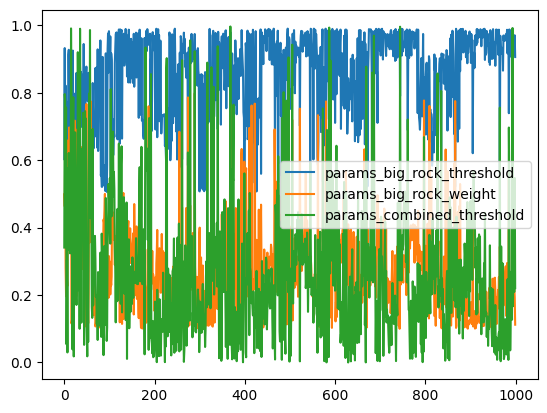

In [32]:
study.trials_dataframe().filter(like="params").plot()

Aggregated mean IoU 0.5098816156387329 is higher than baseline


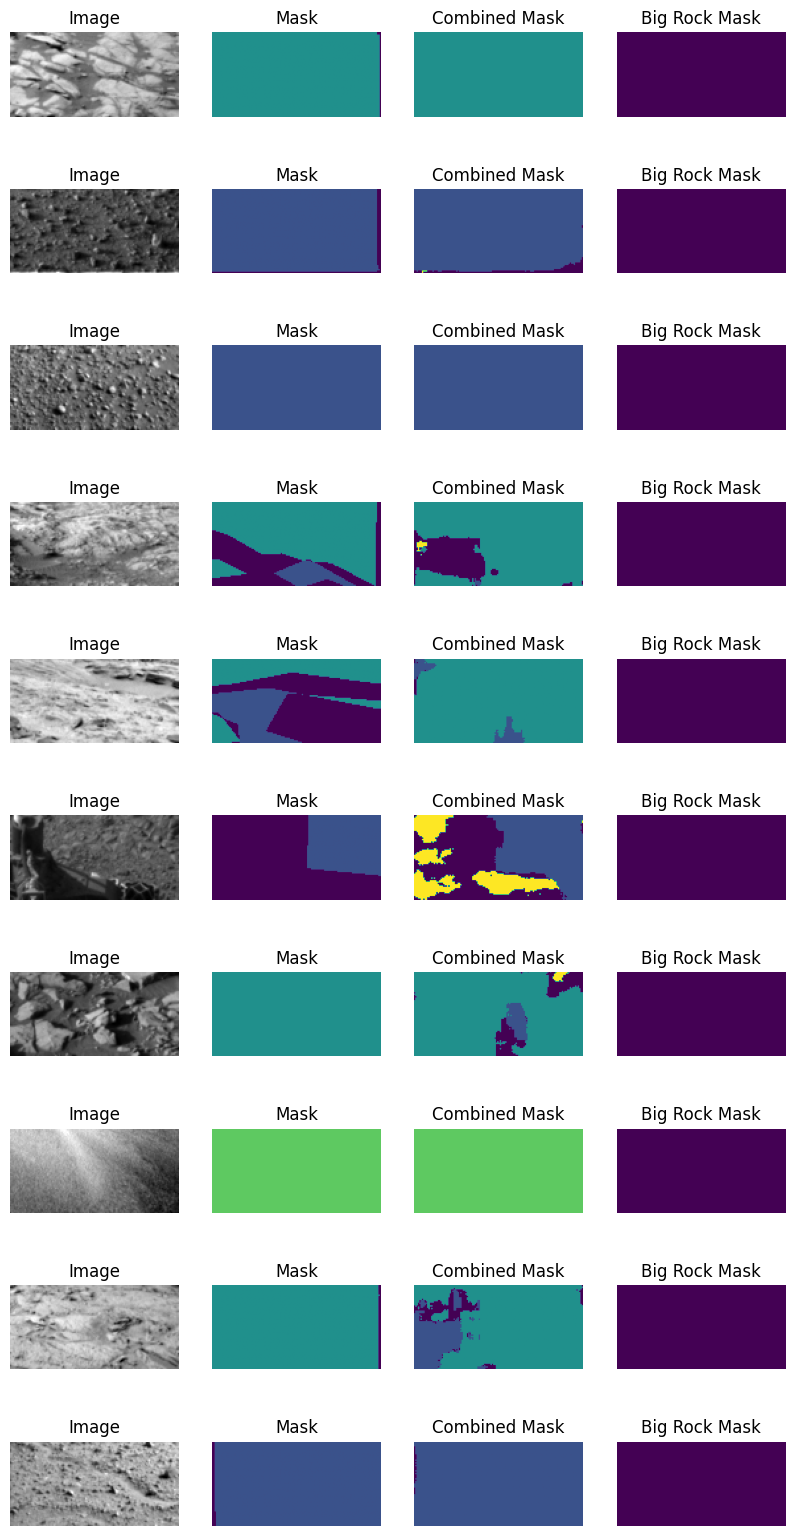

In [33]:
_ = evaluate_aggregation(
    partial(weighted_threshold_merge, **study.best_params),
    y_val,
    combined_val_predictions,
    big_rock_probas,
)

In [34]:
weighted_threshold_argmax = weighted_threshold_merge(combined_val_predictions, big_rock_probas, **study.best_params)
plot_predictions(
    X_val[big_rock_mask],
    y_val[big_rock_mask],
    weighted_threshold_argmax[big_rock_mask],
    big_rock_val_argmax[big_rock_mask],
    n=big_rock_mask.sum(),
)

## Compute submission

In [35]:
combined_test_predictions = combined_model.predict(X_test)
big_rock_test_predictions = big_rock_model.predict(X_test)

314/314 ━━━━━━━━━━━━━━━━━━━━ 163s 519ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 210s 669ms/step


In [36]:
optimisation_test_argmax = weighted_threshold_merge(
    combined_test_predictions,
    big_rock_test_predictions[:, :, :, 1][..., np.newaxis],
    **study.best_params,
)

In [37]:
print(optimisation_test_argmax.shape)
print(np.unique(optimisation_test_argmax))

(10022, 64, 128)
[0 1 2 3 4]


In [38]:
predicted_masks = optimisation_test_argmax

In [44]:
predicted_masks = replace_background(
    np.argmax(combined_test_predictions, axis=-1),
    np.argmax(big_rock_test_predictions, axis=-1),
)

In [45]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [46]:
# Create and download the csv submission file
submission_filename = "submission.csv"
submission_df = y_to_df(predicted_masks)
submission_df.to_csv(submission_filename, index=False)